# Project Title: OLA - Ensemble Learning

## Problem Statement
- Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola.
- Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.
- As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly.
- Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.
- You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition.
- You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like
- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

## Column Profiling:
- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates -cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

## Concepts Tested:
- Ensemble Learning- Bagging
- Ensemble Learning- Boosting
- KNN Imputation of Missing Values
- Working with an imbalanced dataset

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import figure

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import t
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pylab
import missingno as msno
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from category_encoders import TargetEncoder 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report, precision_score, recall_score, f1_score, classification_report
from sklearn.impute import KNNImputer, SimpleImputer

In [2]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types] 

In [3]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<5:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<5:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [4]:
def remove_outlier(df_in, col_name, thresh=5):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        if round(outlier_fraction*100, 2) < 100.00:
            fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
            sns.boxplot(data=df_in, y=col_name,palette='viridis')
        if outlier_fraction <= thresh/100:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            if round(outlier_fraction*100, 2) < 100.00:
                fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
                plt.show()
            return df_in
    else:
        return df_in

In [5]:
def vif_pruning(features, vif_threshold):
    vifs = []
    columns = []
    result = []
    feature_columns = features.columns
    for column in feature_columns:
        if len(features.columns) <=1:
            vifs += [0]
            columns += [column]
            result += ["Keeping column"]
            break
        vif = round(variance_inflation_factor(features.values, features.columns.get_loc(column)), 2)
        vifs += [vif]
        columns += [column]
        if vif > vif_threshold:
            features = features.drop(column, axis=1)
            result += ["Dropping column"]
        else:
            result += ["Keeping column"]
    return features, pd.DataFrame({'VIF Score':vifs, 'Column Name':columns, 'Result':result})

# 1. Analysing Basic Metrics

In [6]:
ola = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv")

In [7]:
ola.head(5)

Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining LastWorkingDate  Joining Designation  Grade  Total Business Value  Quarterly Rating
0           0  01/01/19          1  28.0     0.0  C23                2   57387      24/12/18             NaN                    1      1               2381060                 2
1           1  02/01/19          1  28.0     0.0  C23                2   57387      24/12/18             NaN                    1      1               -665480                 2
2           2  03/01/19          1  28.0     0.0  C23                2   57387      24/12/18        03/11/19                    1      1                     0                 2
3           3  11/01/20          2  31.0     0.0   C7                2   67016      11/06/20             NaN                    2      2                     0                 1
4           4  12/01/20          2  31.0     0.0   C7                2   67016      11/06/20             NaN                    2      2                     0                 1

In [8]:
data = ola.copy(deep=True)

In [9]:
data.shape

(19104, 14)

19104 data points , 14 features.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


- **MMMM-YY** : Reporting Date (Monthly) (date-time)
- **Age** : Age of the employee (numerical)
- **Gender** : Gender of the employee – Male : 0, Female: 1 (categorical)
- **City** : City Code of the employee (categorical)
- **Education_Level** : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate (categorical)
- **Income** : Monthly average Income of the employee (numerical)
- **Date Of Joining** : Joining date for the employee (date-time)
- **LastWorkingDate** : Last date of working for the employee - Target Feature (date-time, but will be converted to categorical)
- **Joining Designation** : Designation of the employee at the time of joining (categorical, ordinal)
- **Grade** : Grade of the employee at the time of reporting (categorical, ordinal)
- **Total Business Value** : The total business value acquired by the employee in a month (negative business indicates cancellation/refund or car EMI adjustments) (numerical)
- **Quarterly Rating** : Quarterly rating of the employee: 1,2,3,4,5 (categorical, ordinal - higher is better)

In [11]:
data.describe()

Unnamed: 0     Driver_ID           Age        Gender  Education_Level         Income  Joining Designation         Grade  Total Business Value  Quarterly Rating
count  19104.000000  19104.000000  19043.000000  19052.000000     19104.000000   19104.000000         19104.000000  19104.000000          1.910400e+04      19104.000000
mean    9551.500000   1415.591133     34.668435      0.418749         1.021671   65652.025126             1.690536      2.252670          5.716621e+05          2.008899
std     5514.994107    810.705321      6.257912      0.493367         0.800167   30914.515344             0.836984      1.026512          1.128312e+06          1.009832
min        0.000000      1.000000     21.000000      0.000000         0.000000   10747.000000             1.000000      1.000000         -6.000000e+06          1.000000
25%     4775.750000    710.000000     30.000000      0.000000         0.000000   42383.000000             1.000000      1.000000          0.000000e+00          1.000000
50%     9551.500000   1417.000000     34.000000      0.000000         1.000000   60087.000000             1.000000      2.000000          2.500000e+05          2.000000
75%    14327.250000   2137.000000     39.000000      1.000000         2.000000   83969.000000             2.000000      3.000000          6.997000e+05          3.000000
max    19103.000000   2788.000000     58.000000      1.000000         2.000000  188418.000000             5.000000      5.000000          3.374772e+07          4.000000

In [12]:
data.describe(include='object')

MMM-YY   City Dateofjoining LastWorkingDate
count      19104  19104         19104            1616
unique        24     29           869             493
top     01/01/19    C20      23/07/15        29/07/20
freq        1022   1008           192              70

Since  unnamed and driver_id columns have the highest correlation and they are the samehere, dropping unnamed column

In [13]:
data.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [14]:
data.nunique()

MMM-YY                     24
Driver_ID                2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Income                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

## 1.1 Missing Value Check

In [15]:
(data.isna().sum()/len(data))*100

MMM-YY                   0.000000
Driver_ID                0.000000
Age                      0.319305
Gender                   0.272194
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
LastWorkingDate         91.541039
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

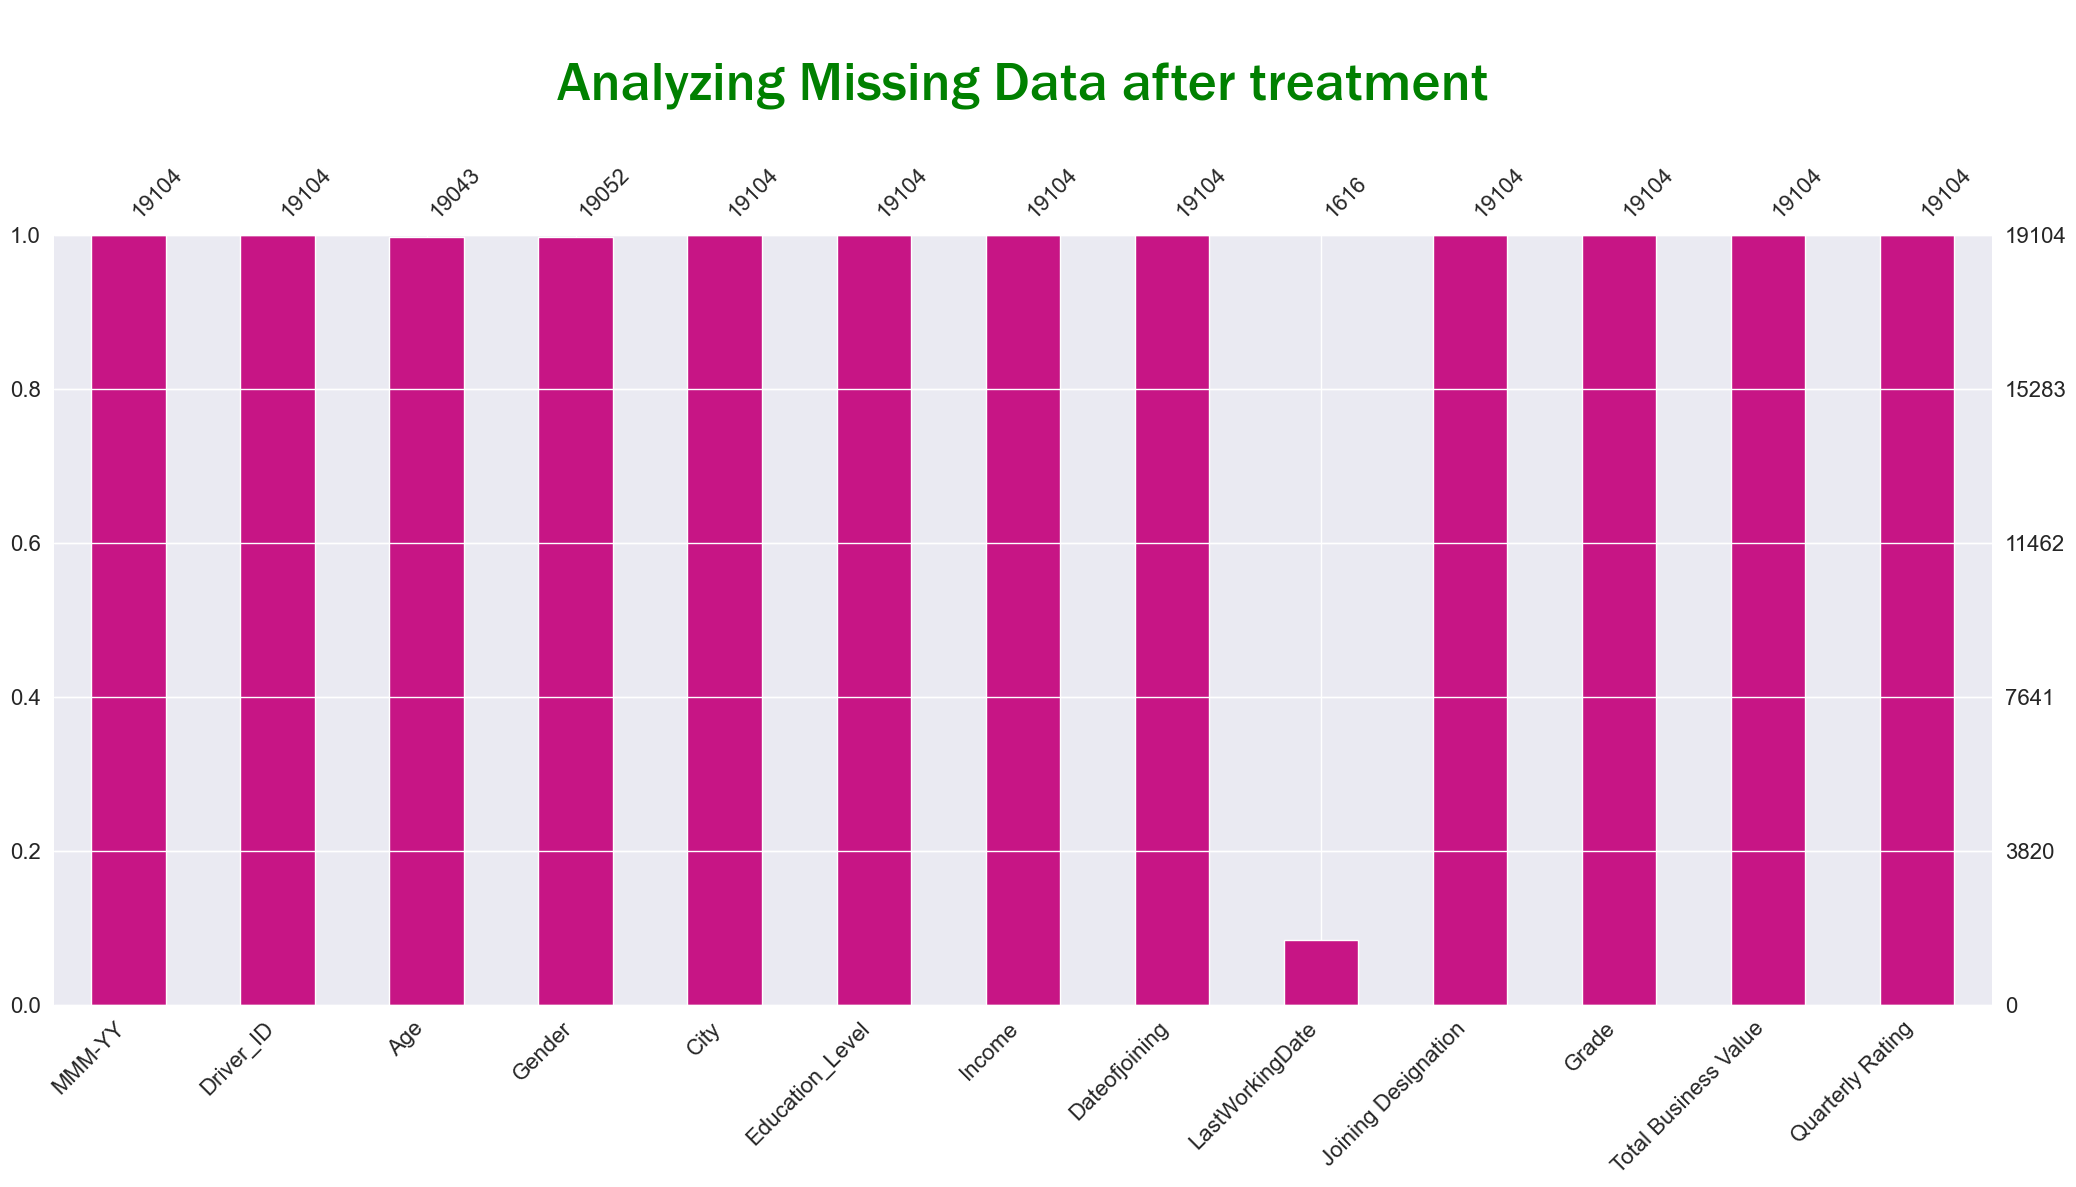

In [16]:
values = {"emp_title": 'Unknown', "emp_length": '< 1 year', "title": 'Unknown', "revol_util": 0, 'mort_acc': 0, 'pub_rec_bankruptcies': 0}
data = data.fillna(value=values)
msno.bar(data, color='mediumvioletred')
plt.title("\nAnalyzing Missing Data after treatment\n",fontname='Franklin Gothic Medium', fontsize=40, color="green")
plt.show()

In [17]:
def missing_df(data_fun):
    total_missing_df = data_fun.isna().sum().sort_values(ascending = False)
    percentage_missing_df = ((data_fun.isna().sum()/len(data)*100)).sort_values(ascending = False)
    missingDF = pd.concat([total_missing_df, percentage_missing_df],axis = 1, keys=['Total', 'Percent'])
    return missingDF

missing_data = missing_df(data)
missing_data[missing_data["Total"]>0]

Total    Percent
LastWorkingDate  17488  91.541039
Age                 61   0.319305
Gender              52   0.272194

- There are missing values found in Age, Gender
- LastWorkingDate feature contains missing values which indicates the driver has not left the company yet.

## 1.2 Descriptive Statistics

In [18]:
data.describe().round(1)

Driver_ID      Age   Gender  Education_Level    Income  Joining Designation    Grade  Total Business Value  Quarterly Rating
count    19104.0  19043.0  19052.0          19104.0   19104.0              19104.0  19104.0               19104.0           19104.0
mean      1415.6     34.7      0.4              1.0   65652.0                  1.7      2.3              571662.1               2.0
std        810.7      6.3      0.5              0.8   30914.5                  0.8      1.0             1128312.2               1.0
min          1.0     21.0      0.0              0.0   10747.0                  1.0      1.0            -6000000.0               1.0
25%        710.0     30.0      0.0              0.0   42383.0                  1.0      1.0                   0.0               1.0
50%       1417.0     34.0      0.0              1.0   60087.0                  1.0      2.0              250000.0               2.0
75%       2137.0     39.0      1.0              2.0   83969.0                  2.0      3.0              699700.0               3.0
max       2788.0     58.0      1.0              2.0  188418.0                  5.0      5.0            33747720.0               4.0

In [19]:
data.describe().T

count           mean           std        min      25%       50%       75%         max
Driver_ID             19104.0    1415.591133  8.107053e+02        1.0    710.0    1417.0    2137.0      2788.0
Age                   19043.0      34.668435  6.257912e+00       21.0     30.0      34.0      39.0        58.0
Gender                19052.0       0.418749  4.933670e-01        0.0      0.0       0.0       1.0         1.0
Education_Level       19104.0       1.021671  8.001671e-01        0.0      0.0       1.0       2.0         2.0
Income                19104.0   65652.025126  3.091452e+04    10747.0  42383.0   60087.0   83969.0    188418.0
Joining Designation   19104.0       1.690536  8.369837e-01        1.0      1.0       1.0       2.0         5.0
Grade                 19104.0       2.252670  1.026512e+00        1.0      1.0       2.0       3.0         5.0
Total Business Value  19104.0  571662.074958  1.128312e+06 -6000000.0      0.0  250000.0  699700.0  33747720.0
Quarterly Rating      19104.0       2.008899  1.009832e+00        1.0      1.0       2.0       3.0         4.0

In [20]:
data.describe(include = 'object')

MMM-YY   City Dateofjoining LastWorkingDate
count      19104  19104         19104            1616
unique        24     29           869             493
top     01/01/19    C20      23/07/15        29/07/20
freq        1022   1008           192              70

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [22]:
from tabulate import tabulate
data.columns
# Finding Unique values from all columns in dataset
print("\nTotal unique values", end ='\n\n')
df_dict = {}
col = []
total_count = []
for i in data.columns:
    col.append(i)
    total_count.append(data[i].nunique())
df_dict = {'Column Names':col, 'Total count of Unique records':total_count}
print(tabulate(df_dict, headers='keys', tablefmt='fancy_grid',showindex =range(1,data.shape[1]+1)))


Total unique values

╒════╤══════════════════════╤═════════════════════════════════╕
│    │ Column Names         │   Total count of Unique records │
╞════╪══════════════════════╪═════════════════════════════════╡
│  1 │ MMM-YY               │                              24 │
├────┼──────────────────────┼─────────────────────────────────┤
│  2 │ Driver_ID            │                            2381 │
├────┼──────────────────────┼─────────────────────────────────┤
│  3 │ Age                  │                              36 │
├────┼──────────────────────┼─────────────────────────────────┤
│  4 │ Gender               │                               2 │
├────┼──────────────────────┼─────────────────────────────────┤
│  5 │ City                 │                              29 │
├────┼──────────────────────┼─────────────────────────────────┤
│  6 │ Education_Level      │                               3 │
├────┼──────────────────────┼─────────────────────────────────┤
│  7 │ Income     

### 1.2.1 Analyzing missing Age values.

In [23]:
drivers_missing_age = data[data['Age'].isnull()]['Driver_ID']

In [24]:
data[data['Driver_ID'].isin(drivers_missing_age)].head()

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining LastWorkingDate  Joining Designation  Grade  Total Business Value  Quarterly Rating
68  10/01/19         20  26.0     1.0  C19                0   40342      25/10/19             NaN                    3      3                     0                 1
69  11/01/19         20  26.0     1.0  C19                0   40342      25/10/19             NaN                    3      3                     0                 1
70  12/01/19         20  26.0     1.0  C19                0   40342      25/10/19             NaN                    3      3                     0                 1
71  01/01/20         20  26.0     1.0  C19                0   40342      25/10/19             NaN                    3      3                     0                 1
72  02/01/20         20   NaN     1.0  C19                0   40342      25/10/19             NaN                    3      3                     0                 1

As we can see, some records for some drivers don't have Age details mentioned, but the remaining records for the same driver will have correct Age details. So, no need to use any imputation technique on Age column as we are anyway going to group on Driver_ID column and pick non-null Age value.

### 1.2.2 Analyzing missing Gender values.

In [25]:
drivers_missing_gender = data[data['Gender'].isnull()]['Driver_ID']

In [26]:
data[data['Driver_ID'].isin(drivers_missing_gender)].head()

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income Dateofjoining LastWorkingDate  Joining Designation  Grade  Total Business Value  Quarterly Rating
239  01/01/19         43  27.0     1.0  C15                0   12906      13/07/18             NaN                    1      1                359890                 1
240  02/01/19         43  27.0     NaN  C15                0   12906      13/07/18        20/02/19                    1      1                     0                 1
257  01/01/19         49  21.0     0.0  C20                0   53039      25/05/18             NaN                    1      2                171760                 1
258  02/01/19         49  21.0     NaN  C20                0   53039      25/05/18             NaN                    1      2                     0                 1
259  03/01/19         49  21.0     0.0  C20                0   53039      25/05/18             NaN                    1      2                392890                 1

As we can see, some records for some drivers don't have Gender details mentioned, but the remaining records for the same driver will have correct Gender details. So, no need to use any imputation technique on Gender column as we are anyway going to group on Driver_ID column and pick non-null Gender value.

## 1.3 SimpleImputer

In [27]:
from sklearn.impute import SimpleImputer

In [28]:
imputer = SimpleImputer(strategy='most_frequent')

In [29]:
data["Gender"] = imputer.fit_transform(X=data["Gender"].values.reshape(-1,1),y=data["LastWorkingDate"].values.reshape(-1,1))
data["Gender"].value_counts(dropna=False)

0.0    11126
1.0     7978
Name: Gender, dtype: int64

In [30]:
data.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

## 1.4 TargetEncoder

In [31]:
from category_encoders import TargetEncoder
TE = TargetEncoder()

In [32]:
num_vars = data.select_dtypes(np.number)
num_vars.columns

Index(['Driver_ID', 'Age', 'Gender', 'Education_Level', 'Income', 'Joining Designation', 'Grade', 'Total Business Value', 'Quarterly Rating'], dtype='object')

<AxesSubplot:>

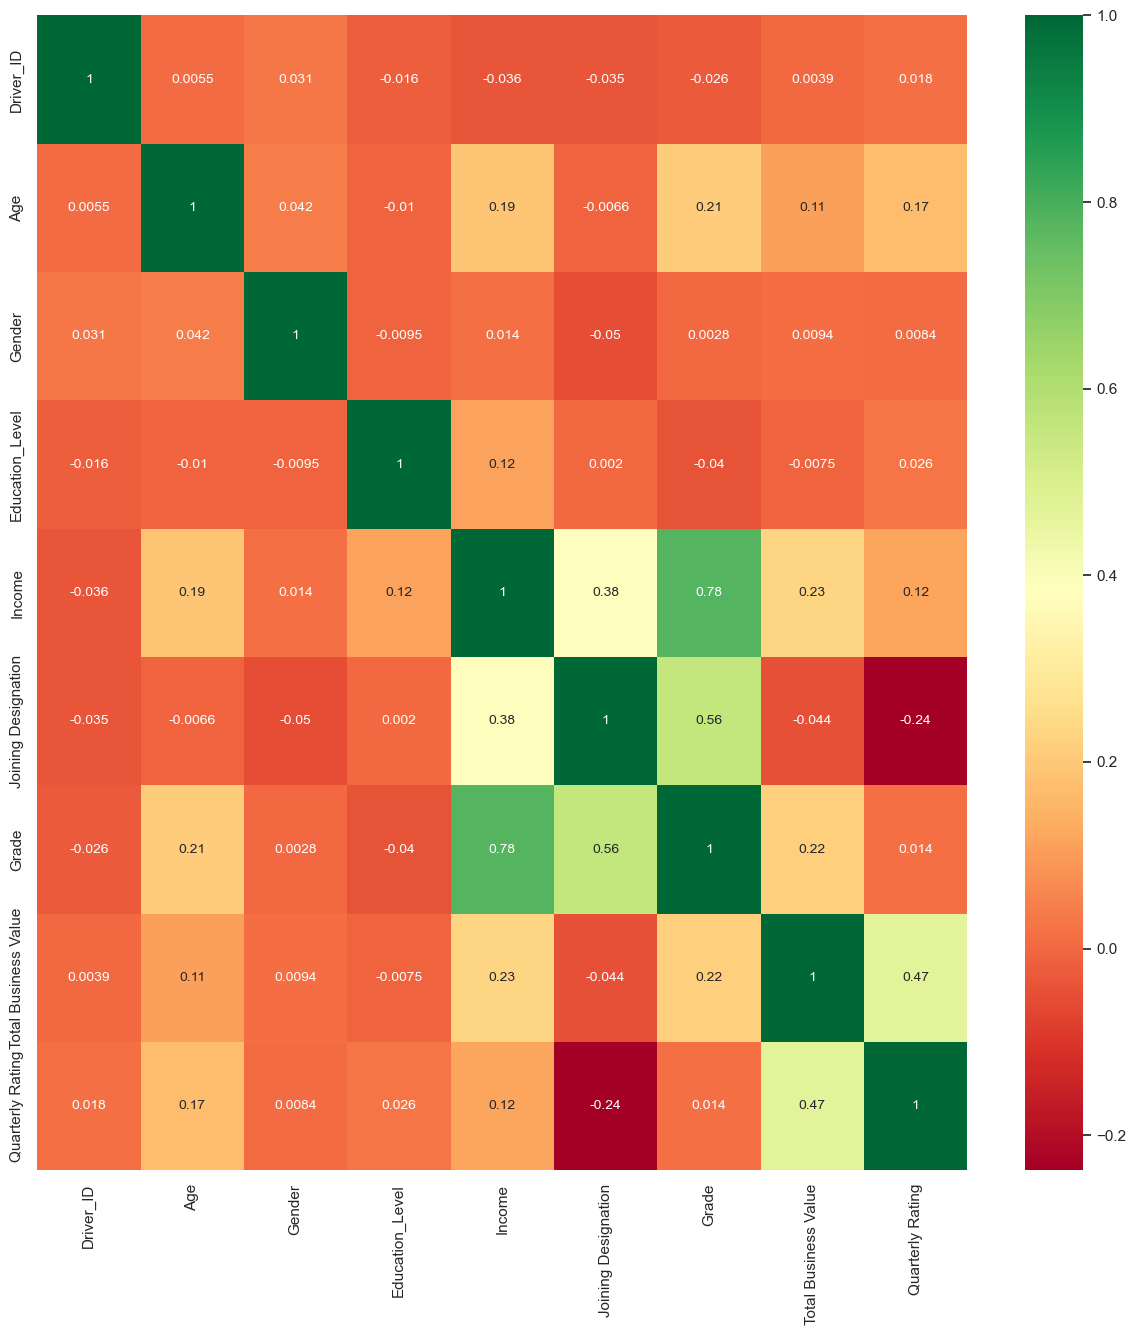

In [33]:
plt.figure(figsize=(15, 15))
sns.heatmap(num_vars.corr(),annot=True, cmap="RdYlGn", annot_kws={"size":10})

## 1.5 KNNImputer

In [34]:
import numpy as np
from sklearn.impute import KNNImputer

In [35]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(num_vars)
data_new = imputer.transform(num_vars)

In [36]:
data_new = pd.DataFrame(data_new)

In [37]:
data_new.columns = num_vars.columns

In [38]:
data_new.isnull().sum()

Driver_ID               0
Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
dtype: int64

We have successfully imputed the missing values using KNNImputer

In [39]:
data_new.nunique()

Driver_ID                2381
Age                        71
Gender                      2
Education_Level             3
Income                   2383
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

## 1.6 Concatenating dataframes

In [40]:
resultant_columns = list(set(data.columns).difference(set(num_vars)))
resultant_columns

['Dateofjoining', 'City', 'MMM-YY', 'LastWorkingDate']

In [41]:
df = pd.concat([data_new, data[resultant_columns]], axis=1)
df.shape

(19104, 13)

In [42]:
df.isna().sum()

Driver_ID                   0
Age                         0
Gender                      0
Education_Level             0
Income                      0
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
Dateofjoining               0
City                        0
MMM-YY                      0
LastWorkingDate         17488
dtype: int64

# 2 Feature Creation and Feature Transformation.

In [43]:
# # Target variable creation: Create a column called target which tells whether the driver has left the company- 
# # driver whose last working day is present will have the value 1

first =  (df.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()
first['LastWorkingDate'].replace({True:1,False:0},inplace=True)
first.rename(columns={'LastWorkingDate':'target'},inplace=True)
first.head()

Driver_ID  target
0        1.0       0
1        2.0       1
2        4.0       0
3        5.0       0
4        6.0       1

In [44]:
# Create a column which tells whether the quarterly rating has increased for that driver - 
# for those whose quarterly rating has increased we assign the value 1
QR1 =  (df.groupby('Driver_ID').agg({'Quarterly Rating':'first'})['Quarterly Rating']).reset_index()
QR2 = (df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating']).reset_index()

In [45]:
QR1.shape,QR2.shape

((2381, 2), (2381, 2))

In [46]:
QR1.isna().sum(),QR2.isna().sum()

(Driver_ID           0
 Quarterly Rating    0
 dtype: int64,
 Driver_ID           0
 Quarterly Rating    0
 dtype: int64)

In [47]:
first = first.merge(QR1,on='Driver_ID')
first = first.merge(QR2,on='Driver_ID')
first.head()

Driver_ID  target  Quarterly Rating_x  Quarterly Rating_y
0        1.0       0                 2.0                 2.0
1        2.0       1                 1.0                 1.0
2        4.0       0                 1.0                 1.0
3        5.0       0                 1.0                 1.0
4        6.0       1                 1.0                 2.0

In [48]:
first['Promotion'] = np.where(first['Quarterly Rating_x'] == first['Quarterly Rating_y'], 0,1)

In [49]:
# Create a column which tells whether the monthly income has increased for that driver - 
# for those whose monthly income has increased we assign the value 1
incm1 =  (df.groupby('Driver_ID').agg({'Income':'first'})['Income']).reset_index()
incm2 = (df.groupby('Driver_ID').agg({'Income':'last'})['Income']).reset_index()

In [50]:
incm1.shape,incm2.shape

((2381, 2), (2381, 2))

In [51]:
incm1.isna().sum(),incm2.isna().sum()

(Driver_ID    0
 Income       0
 dtype: int64,
 Driver_ID    0
 Income       0
 dtype: int64)

In [52]:
first = first.merge(incm1,on='Driver_ID')
first = first.merge(incm2,on='Driver_ID')
first.head()

Driver_ID  target  Quarterly Rating_x  Quarterly Rating_y  Promotion  Income_x  Income_y
0        1.0       0                 2.0                 2.0          0   57387.0   57387.0
1        2.0       1                 1.0                 1.0          0   67016.0   67016.0
2        4.0       0                 1.0                 1.0          0   65603.0   65603.0
3        5.0       0                 1.0                 1.0          0   46368.0   46368.0
4        6.0       1                 1.0                 2.0          1   78728.0   78728.0

In [53]:
first['Raise'] = np.where(first['Income_x'] == first['Income_y'], 0,1)

In [54]:
first.head()

Driver_ID  target  Quarterly Rating_x  Quarterly Rating_y  Promotion  Income_x  Income_y  Raise
0        1.0       0                 2.0                 2.0          0   57387.0   57387.0      0
1        2.0       1                 1.0                 1.0          0   67016.0   67016.0      0
2        4.0       0                 1.0                 1.0          0   65603.0   65603.0      0
3        5.0       0                 1.0                 1.0          0   46368.0   46368.0      0
4        6.0       1                 1.0                 2.0          1   78728.0   78728.0      0

In [55]:
first.tail()

Driver_ID  target  Quarterly Rating_x  Quarterly Rating_y  Promotion  Income_x  Income_y  Raise
2376     2784.0       1                 3.0                 4.0          1   82815.0   82815.0      0
2377     2785.0       0                 1.0                 1.0          0   12105.0   12105.0      0
2378     2786.0       0                 2.0                 1.0          1   35370.0   35370.0      0
2379     2787.0       0                 2.0                 1.0          1   69498.0   69498.0      0
2380     2788.0       1                 1.0                 2.0          1   70254.0   70254.0      0

In [56]:
first = first[['Driver_ID','target','Raise','Promotion']]
first.head()

Driver_ID  target  Raise  Promotion
0        1.0       0      0          0
1        2.0       1      0          0
2        4.0       0      0          0
3        5.0       0      0          0
4        6.0       1      0          1

## 2.1 Merging records for each driver and new Feature Creation.

In [57]:
functions = {'MMM-YY':'count',
             'Driver_ID':'first',
             'Age':'max',
             'Gender':'last',
             'City':'last',
             'Education_Level':'last',
             'Dateofjoining':'first',
             'LastWorkingDate':'last',
             'Grade':'last',
             'Total Business Value':'sum',
             'Income':'sum',
             'Dateofjoining':'first',
             'LastWorkingDate':'last',
             'Joining Designation':'last',
             'Quarterly Rating':'first'}
df = df.groupby([df['Driver_ID']]).aggregate(functions)
df['month'] = pd.to_datetime(data['Dateofjoining']).dt.month
df['year'] = pd.DatetimeIndex(df['Dateofjoining']).year
df.rename(columns={'MMM-YY':'Reportings'},inplace=True)

In [58]:
df.reset_index(drop=True, inplace=True)
df = df.merge(first,on='Driver_ID')
df.head()

Reportings  Driver_ID   Age  Gender City  Education_Level Dateofjoining LastWorkingDate  Grade  Total Business Value    Income  Joining Designation  Quarterly Rating  month  year  target  Raise  Promotion
0           3        1.0  28.0     0.0  C23              2.0      24/12/18        03/11/19    1.0             1715580.0  172161.0                  1.0               2.0     12  2018       0      0          0
1           2        2.0  31.0     0.0   C7              2.0      11/06/20            None    2.0                   0.0  134032.0                  2.0               1.0     12  2020       1      0          0
2           5        4.0  43.0     0.0  C13              2.0      12/07/19        27/04/20    2.0              350000.0  328015.0                  2.0               1.0     11  2019       0      0          0
3           3        5.0  29.0     0.0   C9              0.0      01/09/19        03/07/19    1.0              120360.0  139104.0                  1.0               1.0     12  2019       0      0          0
4           5        6.0  31.0     1.0  C11              1.0      31/07/20            None    3.0             1265000.0  393640.0                  3.0               1.0     12  2020       1      0          1

In [59]:
import regex
df['Age'] = df['Age'].astype('int64')
df['Cities'] = df['City'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Reportings            2381 non-null   int64  
 1   Driver_ID             2381 non-null   float64
 2   Age                   2381 non-null   int64  
 3   Gender                2381 non-null   float64
 4   City                  2381 non-null   object 
 5   Education_Level       2381 non-null   float64
 6   Dateofjoining         2381 non-null   object 
 7   LastWorkingDate       1616 non-null   object 
 8   Grade                 2381 non-null   float64
 9   Total Business Value  2381 non-null   float64
 10  Income                2381 non-null   float64
 11  Joining Designation   2381 non-null   float64
 12  Quarterly Rating      2381 non-null   float64
 13  month                 2381 non-null   int64  
 14  year                  2381 non-null   int64  
 15  target               

In [61]:
df['MMM-YY'] = pd.to_datetime(data['MMM-YY'])
df['grade'] = data['Grade'].astype('int64')
df['income'] = data['Income'].astype('int64')
df['rating'] = data['Quarterly Rating'].astype('int64')
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])
df['City'] = df['City'].astype('string')
df.sort_values(by=['Driver_ID', 'Reportings'], ascending=True)
df['Gender'].replace({'M':0,'F':1},inplace=True)
df['Gender'] = df['Gender'].astype('int64')
df.dtypes

Reportings                       int64
Driver_ID                      float64
Age                              int64
Gender                           int64
City                            string
Education_Level                float64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Grade                          float64
Total Business Value           float64
Income                         float64
Joining Designation            float64
Quarterly Rating               float64
month                            int64
year                             int64
target                           int64
Raise                            int32
Promotion                        int32
Cities                           int32
MMM-YY                  datetime64[ns]
grade                            int64
income                           int64
rating                           int64
dtype: object

In [62]:
df.describe().T

count          mean           std        min       25%       50%        75%         max
Reportings            2381.0  8.023520e+00  6.783590e+00        1.0       3.0       5.0       10.0        24.0
Driver_ID             2381.0  1.397559e+03  8.061616e+02        1.0     695.0    1400.0     2100.0      2788.0
Age                   2381.0  3.376186e+01  5.932037e+00       21.0      30.0      33.0       37.0        58.0
Gender                2381.0  4.086518e-01  4.916880e-01        0.0       0.0       0.0        1.0         1.0
Education_Level       2381.0  1.007560e+00  8.162900e-01        0.0       0.0       1.0        2.0         2.0
Grade                 2381.0  2.096598e+00  9.415218e-01        1.0       1.0       2.0        3.0         5.0
Total Business Value  2381.0  4.586742e+06  9.127115e+06 -1385530.0       0.0  817680.0  4173650.0  95331060.0
Income                2381.0  5.267603e+05  6.231633e+05    10883.0  139895.0  292980.0   651456.0   4522032.0
Joining Designation   2381.0  1.820244e+00  8.414334e-01        1.0       1.0       2.0        2.0         5.0
Quarterly Rating      2381.0  1.486350e+00  8.343483e-01        1.0       1.0       1.0        2.0         4.0
month                 2381.0  6.975220e+00  3.007801e+00        1.0       5.0       7.0       10.0        12.0
year                  2381.0  2.018536e+03  1.609597e+00     2013.0    2018.0    2019.0     2020.0      2020.0
target                2381.0  3.212936e-01  4.670713e-01        0.0       0.0       0.0        1.0         1.0
Raise                 2381.0  1.805964e-02  1.331951e-01        0.0       0.0       0.0        0.0         1.0
Promotion             2381.0  3.427131e-01  4.747162e-01        0.0       0.0       0.0        1.0         1.0
Cities                2381.0  1.533557e+01  8.371843e+00        1.0       8.0      15.0       22.0        29.0
grade                 2381.0  2.367913e+00  1.028932e+00        1.0       2.0       2.0        3.0         5.0
income                2381.0  6.850146e+04  3.329678e+04    11236.0   43053.0   63918.0    87902.0    188418.0
rating                2381.0  1.944981e+00  1.030581e+00        1.0       1.0       2.0        3.0         4.0

In [63]:
df1 = df.groupby('Driver_ID').agg(reporting_start_date=('MMM-YY', 'min'),
                           reporting_end_date=('MMM-YY', 'max'),
                            start_monthly_income=('income', 'first'),
                            end_monthly_income=('Income', 'last'),
                            exit_date=('LastWorkingDate', 'max'),
                            designation=('Joining Designation', 'max'),
                            start_grade=('grade', 'first'),
                            end_grade=('Grade', 'last'),
                            start_rating=('Quarterly Rating', 'first'),
                            end_rating=('rating', 'last')
                           ).reset_index()

In [64]:
df['income_raised'] = ((df1['end_monthly_income'] - df1['start_monthly_income'])>0).astype('int64')
df['grade_raised'] = ((df1['end_grade'] - df1['start_grade'])>0).astype('int64')
df['rating_raised'] = ((df1['end_rating'] - df1['start_rating'])>0).astype('int64')
df['has_left'] = (df1['exit_date'].isnull()).astype('int64')
df['reporting_start_year'] = pd.to_datetime(df1['reporting_start_date']).dt.year
df['reporting_start_month'] = pd.to_datetime(df1['reporting_start_date']).dt.month
df['reporting_start_day'] = pd.to_datetime(df1['reporting_start_date']).dt.day
df['reporting_end_year'] = pd.to_datetime(df1['reporting_end_date']).dt.year
df['reporting_end_month'] = pd.to_datetime(df1['reporting_end_date']).dt.month
df['reporting_end_day'] = pd.to_datetime(df1['reporting_end_date']).dt.day
df['joining_year'] = pd.to_datetime(df['Dateofjoining']).dt.year
df['joining_month'] = pd.to_datetime(df['Dateofjoining']).dt.month
df['joining_day'] = pd.to_datetime(df['Dateofjoining']).dt.day
df.head()

Reportings  Driver_ID  Age  Gender City  Education_Level Dateofjoining LastWorkingDate  Grade  Total Business Value    Income  Joining Designation  Quarterly Rating  month  year  target  Raise  Promotion  Cities     MMM-YY  grade  income  rating  income_raised  grade_raised  rating_raised  has_left  reporting_start_year  reporting_start_month  reporting_start_day  reporting_end_year  reporting_end_month  reporting_end_day  joining_year  joining_month  joining_day
0           3        1.0   28       0  C23              2.0    2018-12-24      2019-03-11    1.0             1715580.0  172161.0                  1.0               2.0     12  2018       0      0          0      23 2019-01-01      1   57387       2              1             0              0         0                  2019                      1                    1                2019                    1                  1          2018             12           24
1           2        2.0   31       0   C7              2.0    2020-11-06             NaT    2.0                   0.0  134032.0                  2.0               1.0     12  2020       1      0          0       7 2019-02-01      1   57387       2              1             1              1         1                  2019                      2                    1                2019                    2                  1          2020             11            6
2           5        4.0   43       0  C13              2.0    2019-12-07      2020-04-27    2.0              350000.0  328015.0                  2.0               1.0     11  2019       0      0          0      13 2019-03-01      1   57387       2              1             1              1         0                  2019                      3                    1                2019                    3                  1          2019             12            7
3           3        5.0   29       0   C9              0.0    2019-01-09      2019-03-07    1.0              120360.0  139104.0                  1.0               1.0     12  2019       0      0          0       9 2020-11-01      2   67016       1              1             0              0         0                  2020                     11                    1                2020                   11                  1          2019              1            9
4           5        6.0   31       1  C11              1.0    2020-07-31             NaT    3.0             1265000.0  393640.0                  3.0               1.0     12  2020       1      0          1      11 2020-12-01      2   67016       1              1             1              0         1                  2020                     12                    1                2020                   12                  1          2020              7           31

In [65]:
for column in [ 'has_left']:
    df[column] = pd.Categorical(df[column])

In [66]:
resultant_columns = list(set(df1.columns).difference(set(df)))
resultant_columns

['exit_date',
 'start_grade',
 'designation',
 'reporting_end_date',
 'end_rating',
 'end_grade',
 'end_monthly_income',
 'start_rating',
 'reporting_start_date',
 'start_monthly_income']

In [67]:
df = pd.concat([df, df1[resultant_columns]], axis=1)
df.shape

(2381, 46)

In [68]:
df = df.drop(['MMM-YY','LastWorkingDate', 'exit_date', 'Dateofjoining', 'Driver_ID', 'reporting_start_date', 'reporting_end_date'], axis=1)

In [69]:
df.duplicated().sum()

0

No Duplicate records in the dataset

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Reportings             2381 non-null   int64   
 1   Age                    2381 non-null   int64   
 2   Gender                 2381 non-null   int64   
 3   City                   2381 non-null   string  
 4   Education_Level        2381 non-null   float64 
 5   Grade                  2381 non-null   float64 
 6   Total Business Value   2381 non-null   float64 
 7   Income                 2381 non-null   float64 
 8   Joining Designation    2381 non-null   float64 
 9   Quarterly Rating       2381 non-null   float64 
 10  month                  2381 non-null   int64   
 11  year                   2381 non-null   int64   
 12  target                 2381 non-null   int64   
 13  Raise                  2381 non-null   int32   
 14  Promotion              2381 non-null   i

In [71]:
df.describe().T

count          mean           std        min       25%       50%        75%         max
Reportings             2381.0  8.023520e+00  6.783590e+00        1.0       3.0       5.0       10.0        24.0
Age                    2381.0  3.376186e+01  5.932037e+00       21.0      30.0      33.0       37.0        58.0
Gender                 2381.0  4.086518e-01  4.916880e-01        0.0       0.0       0.0        1.0         1.0
Education_Level        2381.0  1.007560e+00  8.162900e-01        0.0       0.0       1.0        2.0         2.0
Grade                  2381.0  2.096598e+00  9.415218e-01        1.0       1.0       2.0        3.0         5.0
Total Business Value   2381.0  4.586742e+06  9.127115e+06 -1385530.0       0.0  817680.0  4173650.0  95331060.0
Income                 2381.0  5.267603e+05  6.231633e+05    10883.0  139895.0  292980.0   651456.0   4522032.0
Joining Designation    2381.0  1.820244e+00  8.414334e-01        1.0       1.0       2.0        2.0         5.0
Quarterly Rating       2381.0  1.486350e+00  8.343483e-01        1.0       1.0       1.0        2.0         4.0
month                  2381.0  6.975220e+00  3.007801e+00        1.0       5.0       7.0       10.0        12.0
year                   2381.0  2.018536e+03  1.609597e+00     2013.0    2018.0    2019.0     2020.0      2020.0
target                 2381.0  3.212936e-01  4.670713e-01        0.0       0.0       0.0        1.0         1.0
Raise                  2381.0  1.805964e-02  1.331951e-01        0.0       0.0       0.0        0.0         1.0
Promotion              2381.0  3.427131e-01  4.747162e-01        0.0       0.0       0.0        1.0         1.0
Cities                 2381.0  1.533557e+01  8.371843e+00        1.0       8.0      15.0       22.0        29.0
grade                  2381.0  2.367913e+00  1.028932e+00        1.0       2.0       2.0        3.0         5.0
income                 2381.0  6.850146e+04  3.329678e+04    11236.0   43053.0   63918.0    87902.0    188418.0
rating                 2381.0  1.944981e+00  1.030581e+00        1.0       1.0       2.0        3.0         4.0
income_raised          2381.0  8.996220e-01  3.005665e-01        0.0       1.0       1.0        1.0         1.0
grade_raised           2381.0  2.889542e-01  4.533718e-01        0.0       0.0       0.0        1.0         1.0
rating_raised          2381.0  4.409912e-01  4.966100e-01        0.0       0.0       0.0        1.0         1.0
reporting_start_year   2381.0  2.019503e+03  5.000976e-01     2019.0    2019.0    2020.0     2020.0      2020.0
reporting_start_month  2381.0  6.362453e+00  3.537091e+00        1.0       3.0       6.0        9.0        12.0
reporting_start_day    2381.0  1.000000e+00  0.000000e+00        1.0       1.0       1.0        1.0         1.0
reporting_end_year     2381.0  2.019503e+03  5.000976e-01     2019.0    2019.0    2020.0     2020.0      2020.0
reporting_end_month    2381.0  6.362453e+00  3.537091e+00        1.0       3.0       6.0        9.0        12.0
reporting_end_day      2381.0  1.000000e+00  0.000000e+00        1.0       1.0       1.0        1.0         1.0
joining_year           2381.0  2.018536e+03  1.609597e+00     2013.0    2018.0    2019.0     2020.0      2020.0
joining_month          2381.0  7.357413e+00  3.143143e+00        1.0       5.0       7.0       10.0        12.0
joining_day            2381.0  1.578748e+01  9.371835e+00        1.0       7.0      15.0       24.0        31.0
start_grade            2381.0  2.367913e+00  1.028932e+00        1.0       2.0       2.0        3.0         5.0
designation            2381.0  1.820244e+00  8.414334e-01        1.0       1.0       2.0        2.0         5.0
end_rating             2381.0  1.944981e+00  1.030581e+00        1.0       1.0       2.0        3.0         4.0
end_grade              2381.0  2.096598e+00  9.415218e-01        1.0       1.0       2.0        3.0         5.0
end_monthly_income     2381.0  5.267603e+05  6.231633e+05    10883.0  139895.0  292980.0   651456.0   45

In [72]:
df = df.drop(['City'], axis=1)

# 3 Outlier Detection & Treatment.

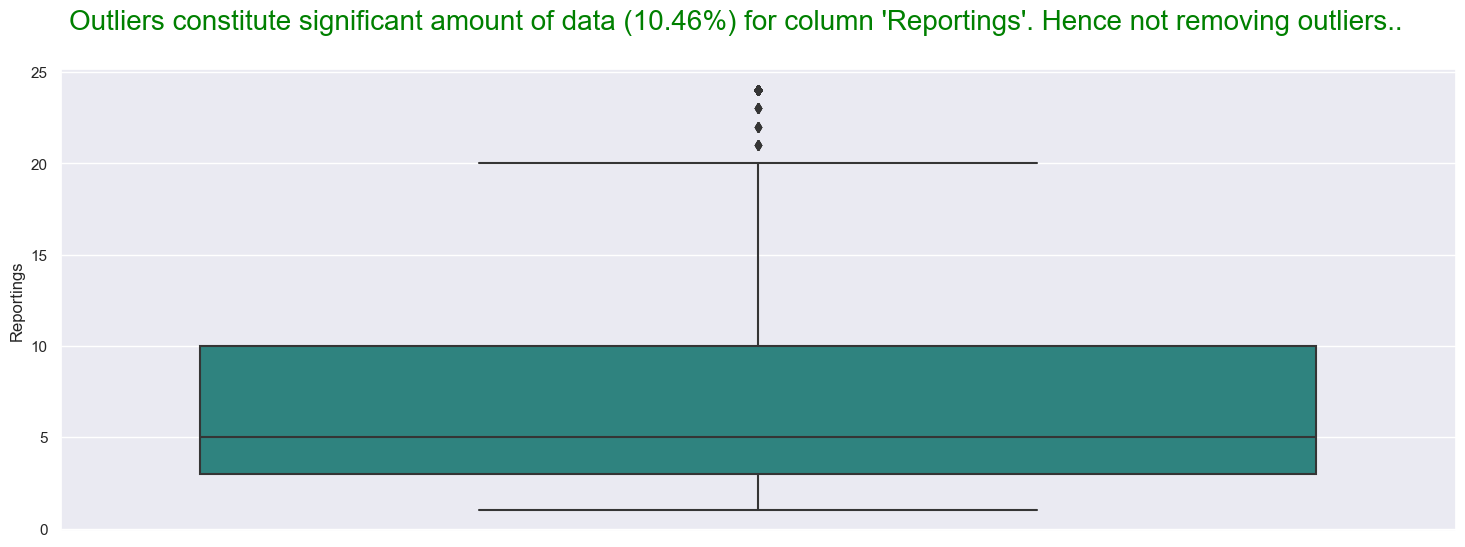

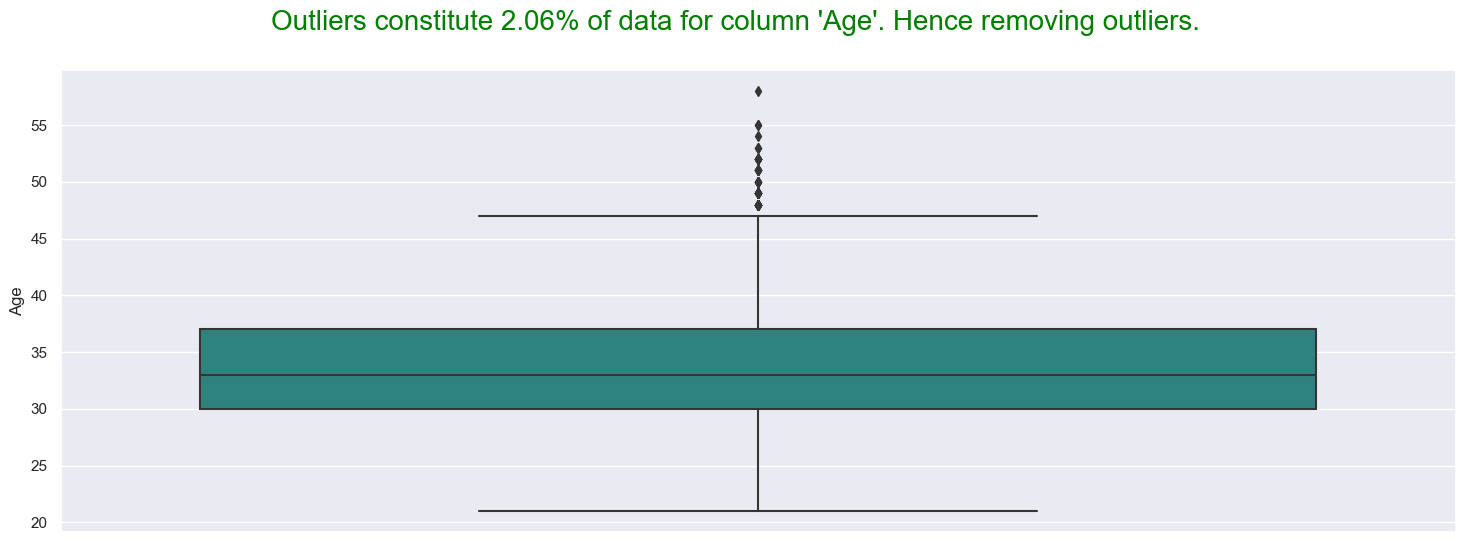

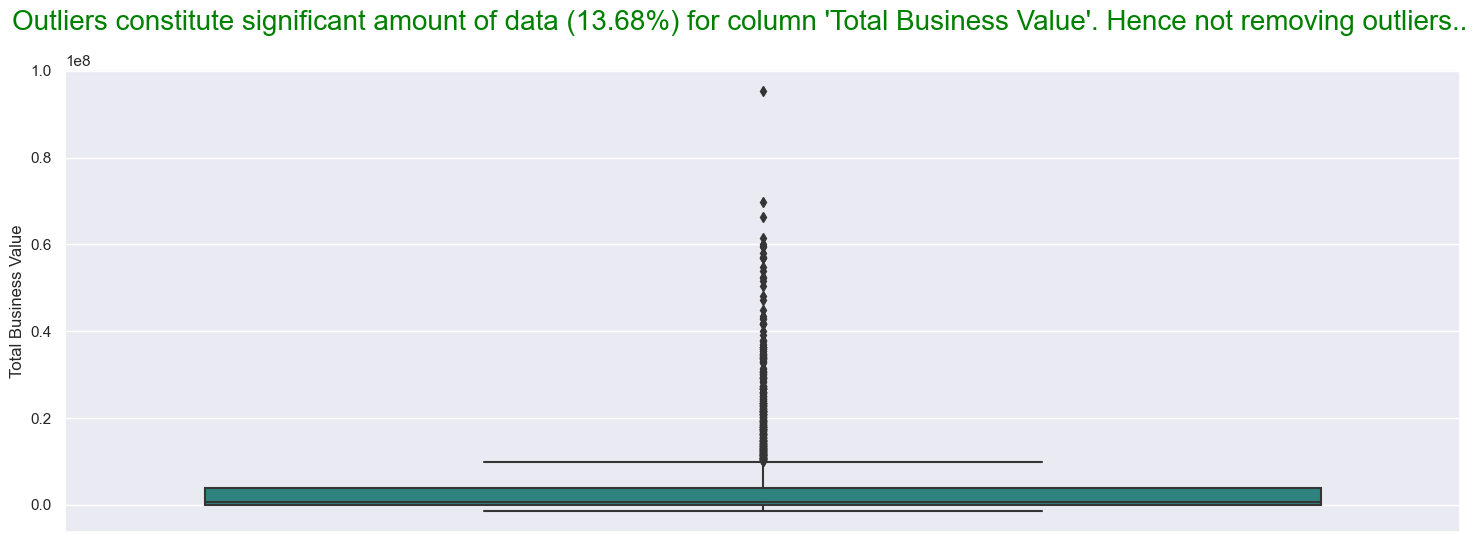

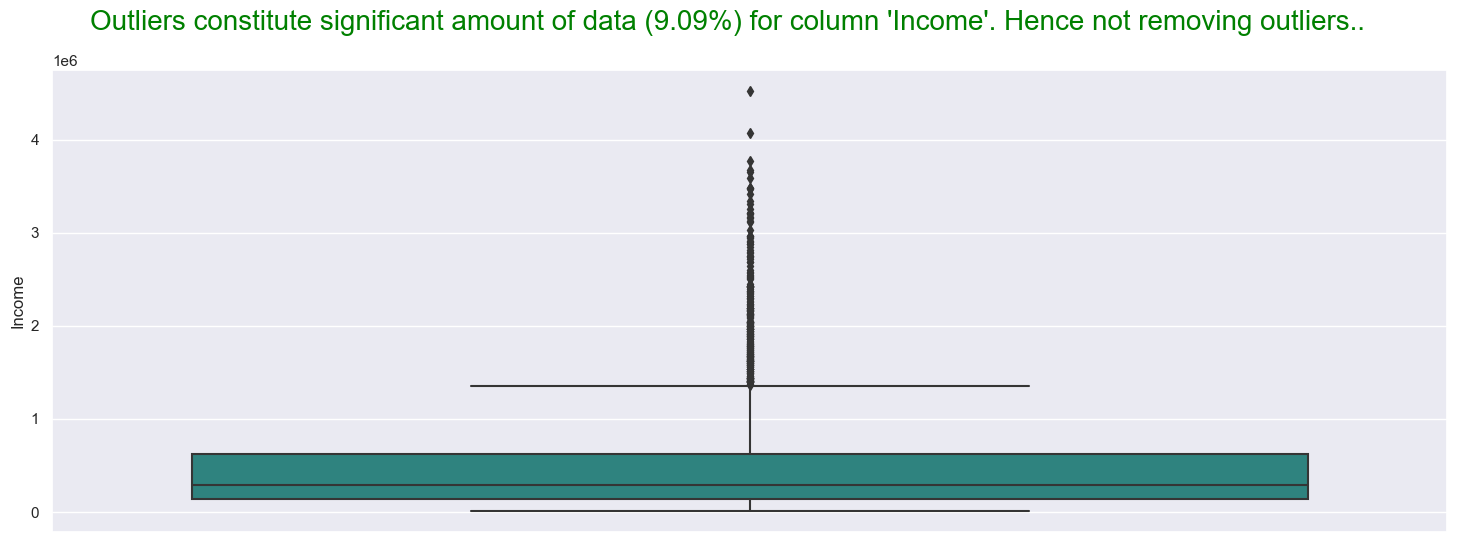

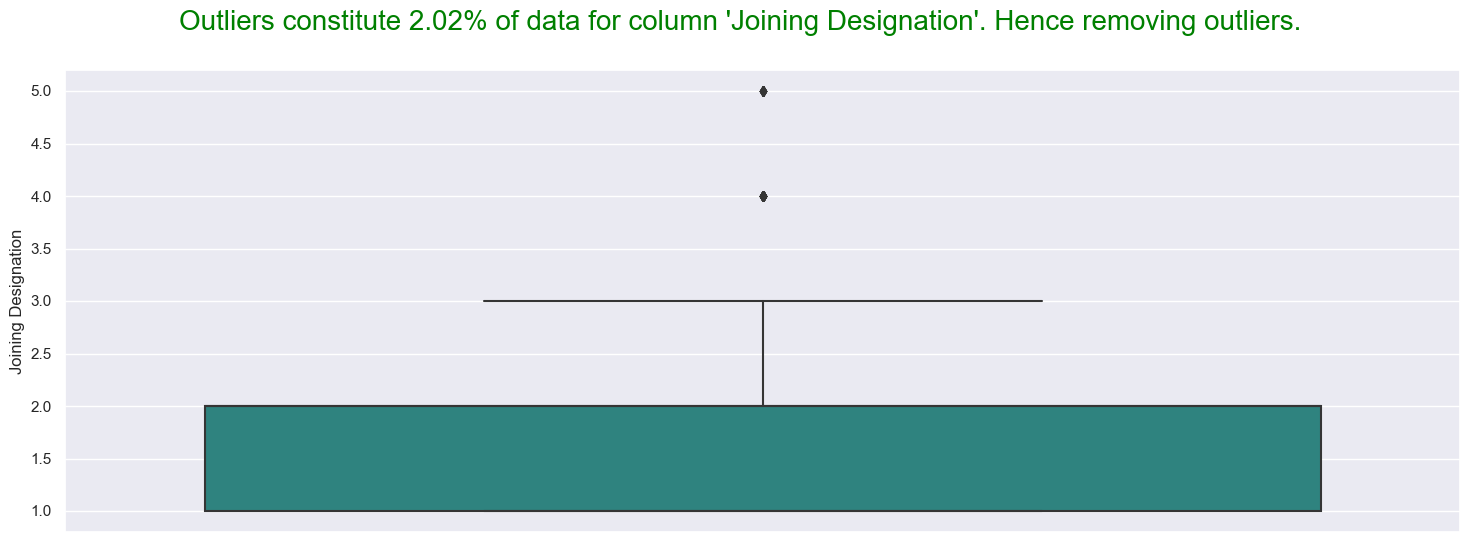

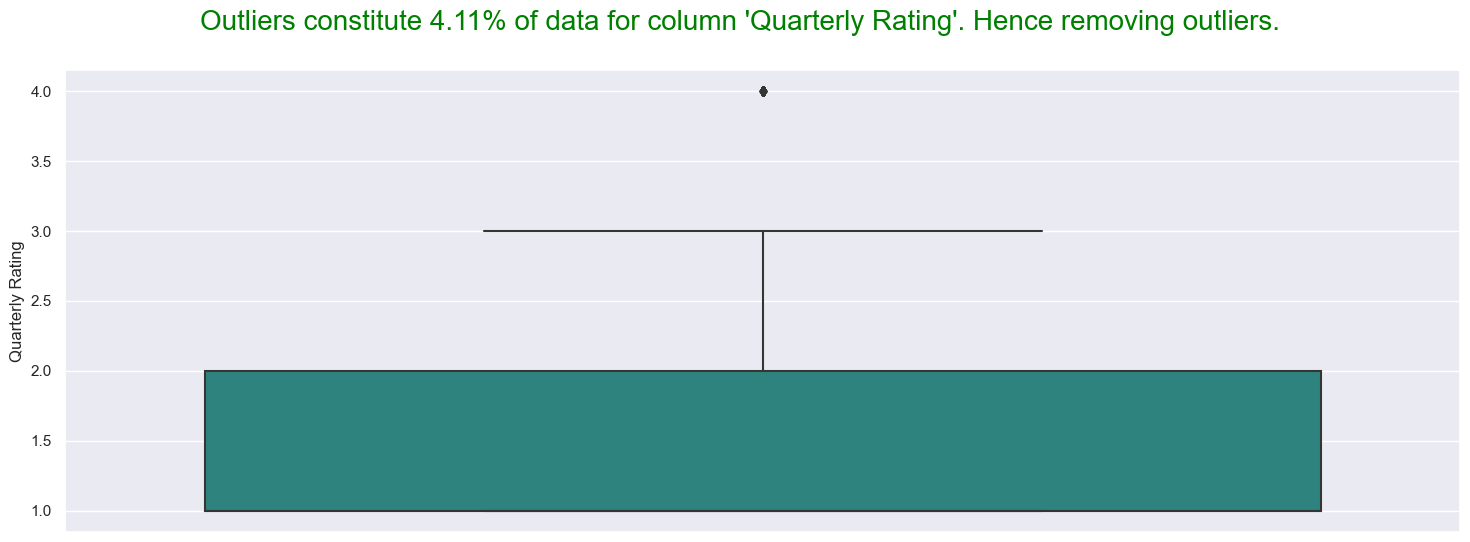

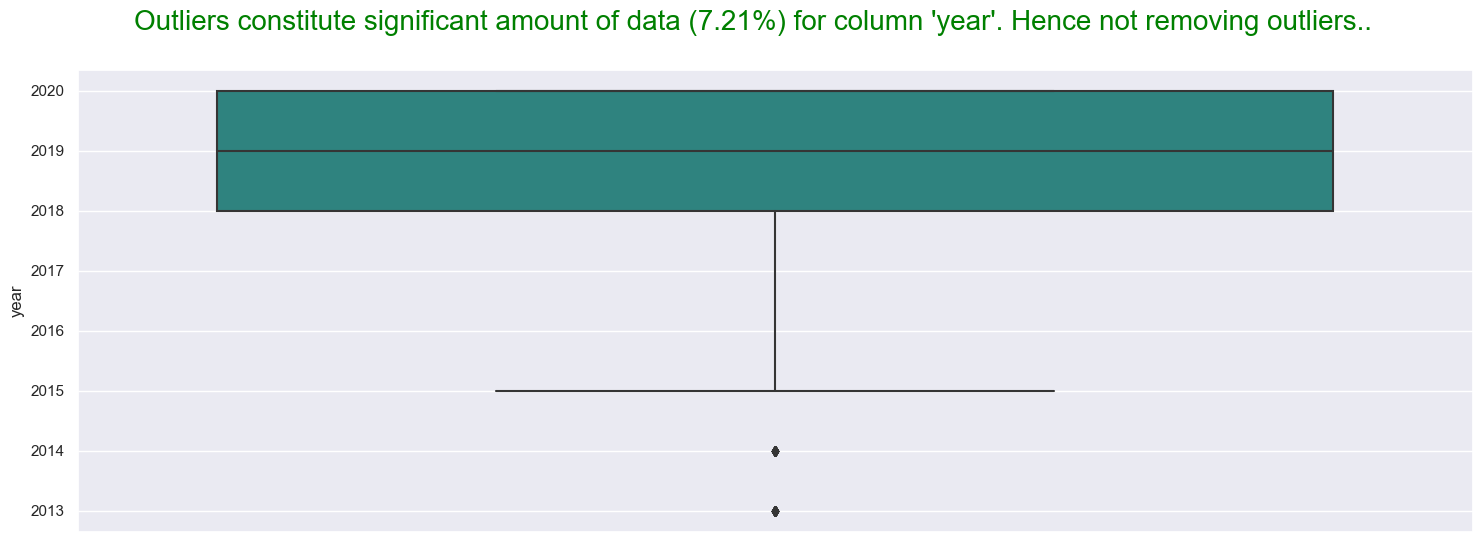

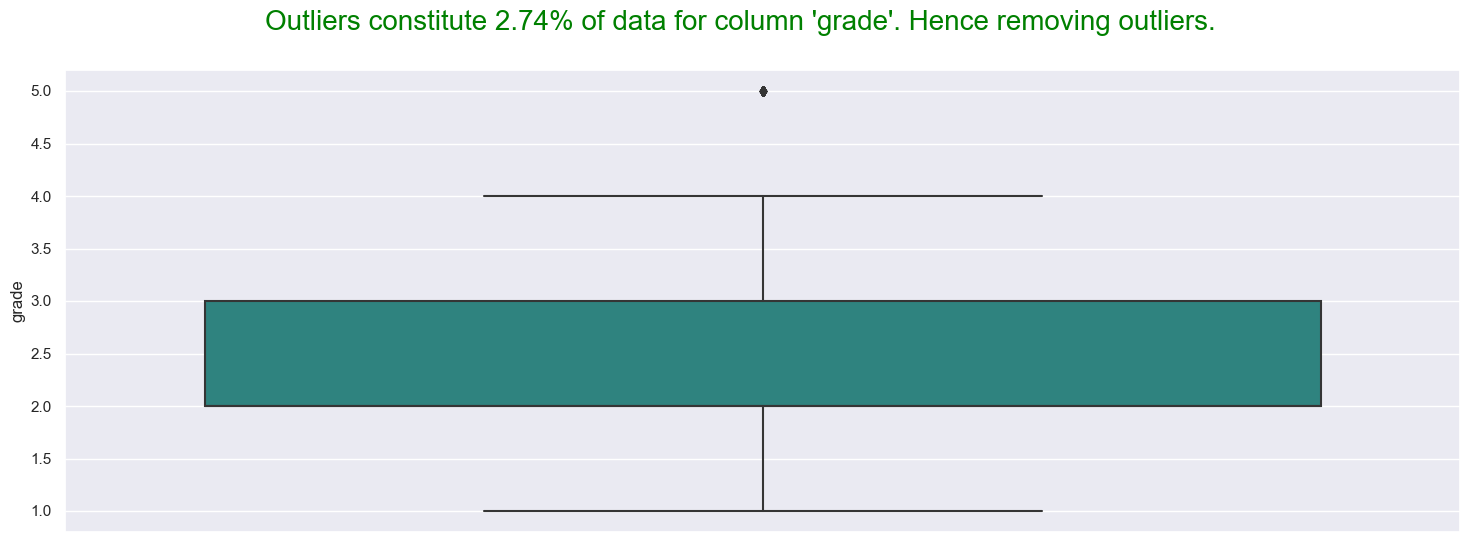

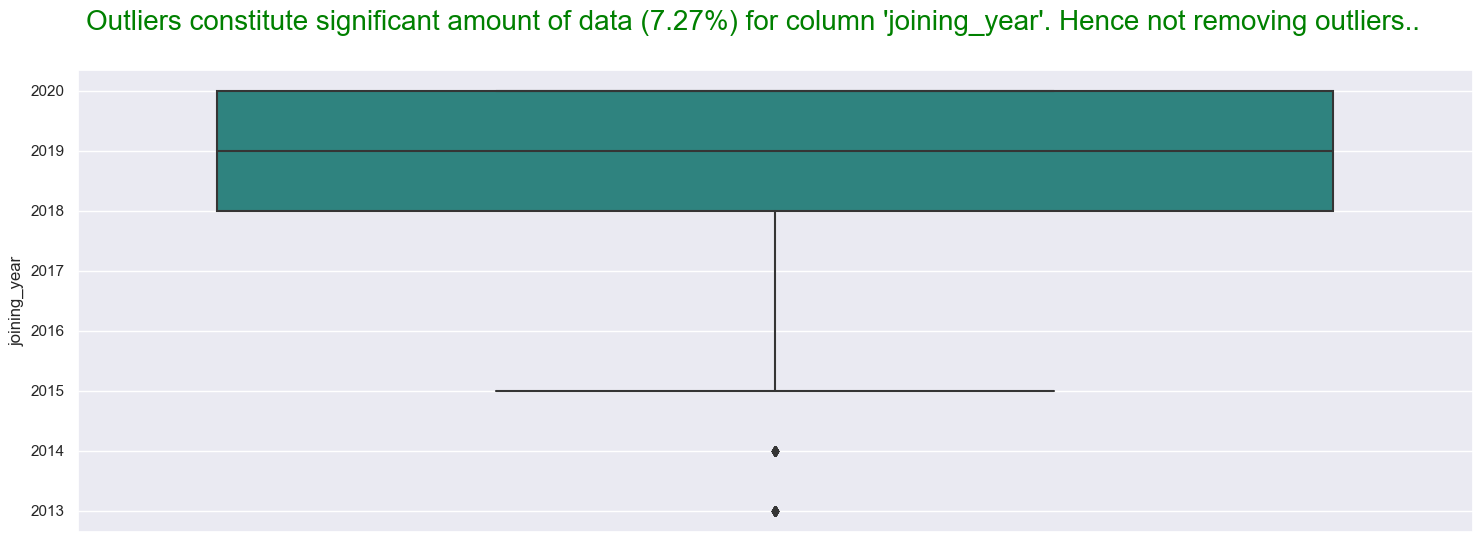

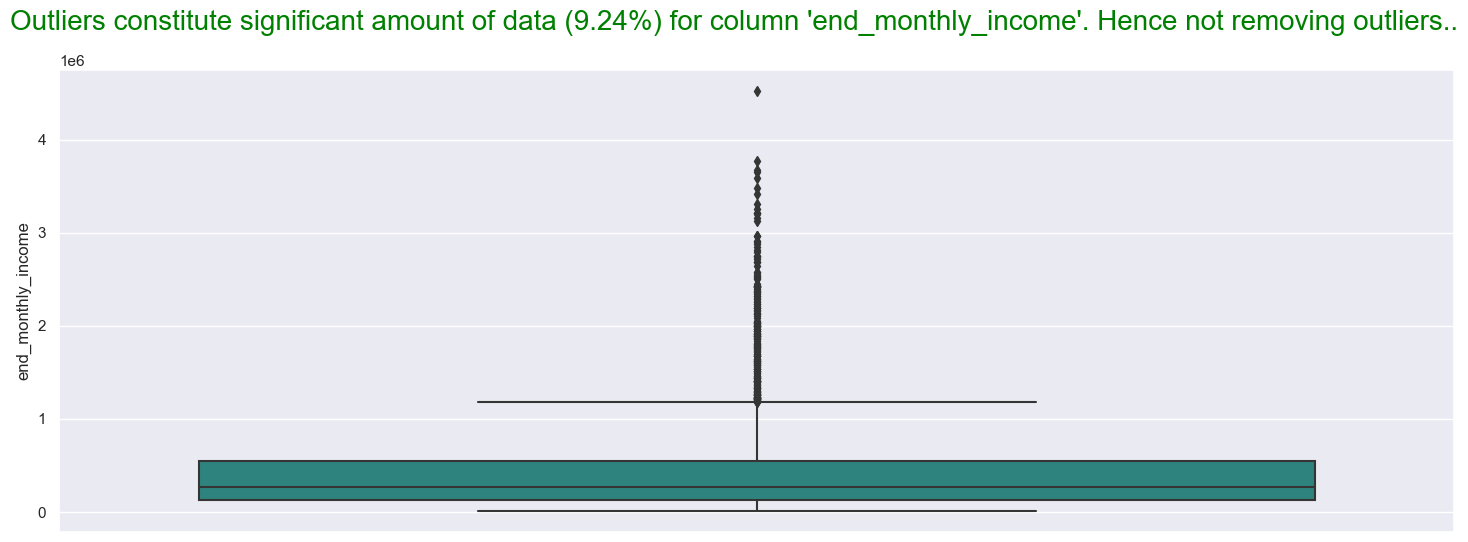

In [73]:
for column in get_columns_by_types(df, numeric_types):
    df = remove_outlier(df, column, thresh=5)

# 4 Univariate Analysis

## 4.1 Univariate Analysis (Categorical Data)

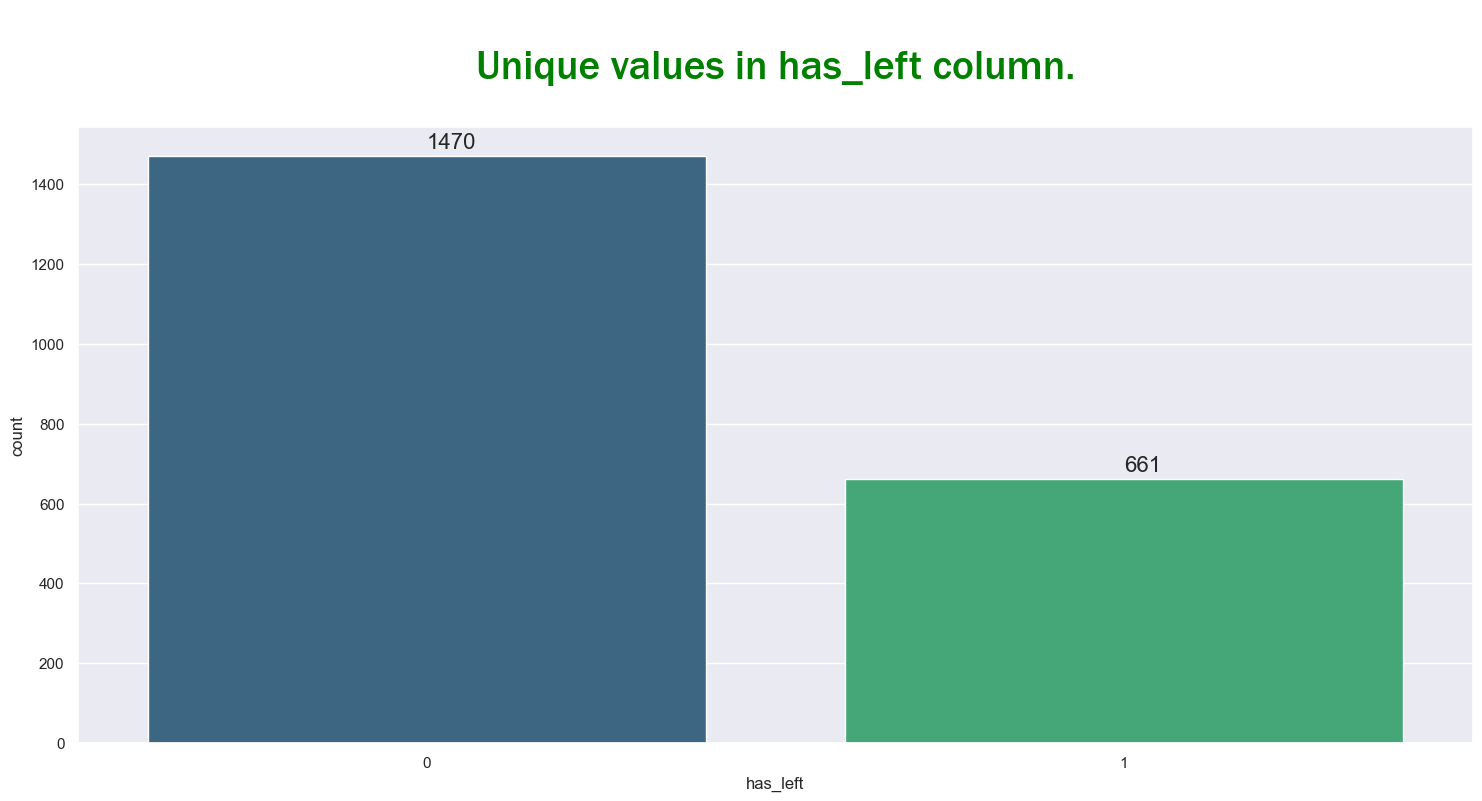

In [74]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(18,8))
    ax = sns.countplot(data=df, x=column,palette='viridis')
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.40, p.get_height()+20), size=16)
    plt.title(f"\nUnique values in {column} column.\n",fontname='Franklin Gothic Medium', fontsize=30, color="green")
    plt.show()

## 4.2 Univariate Analysis (Discrete Data).

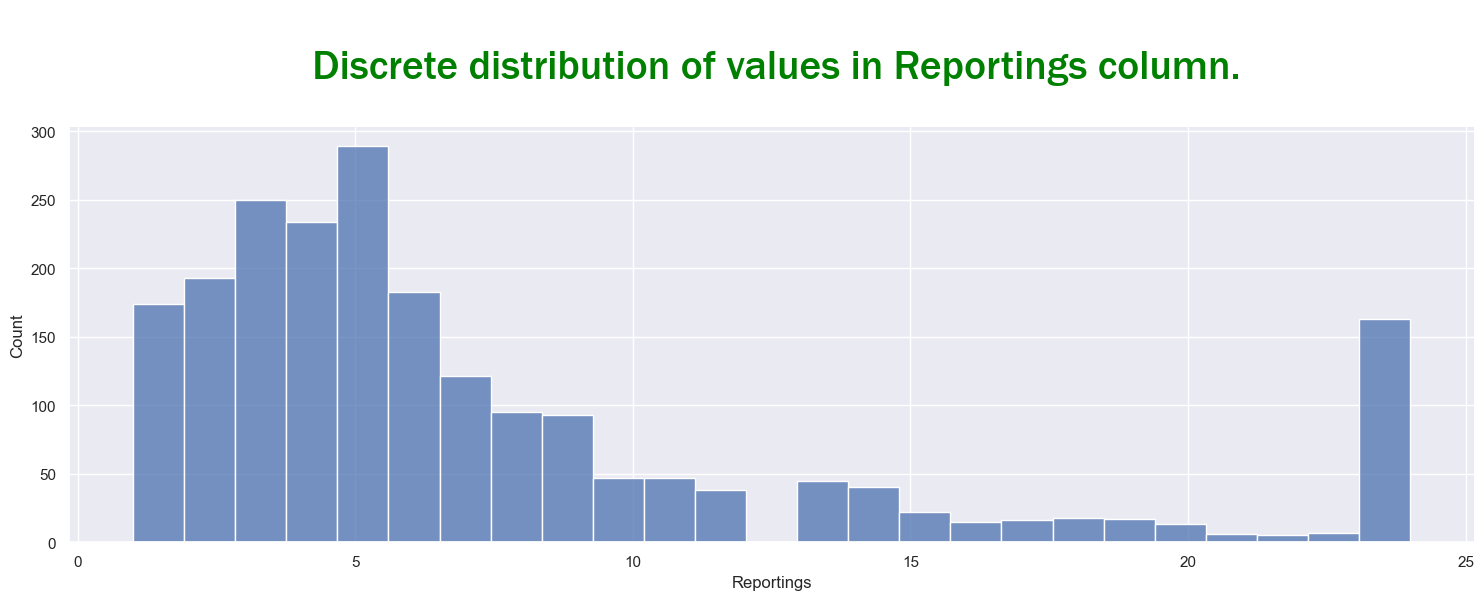

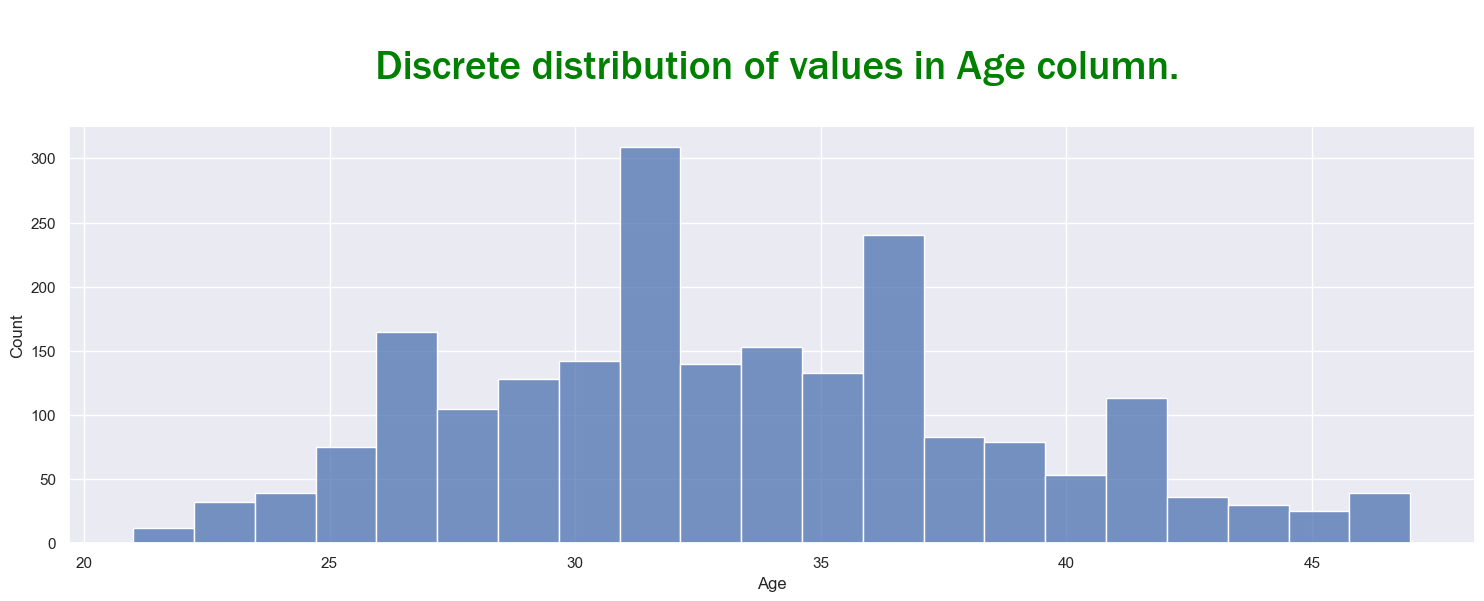

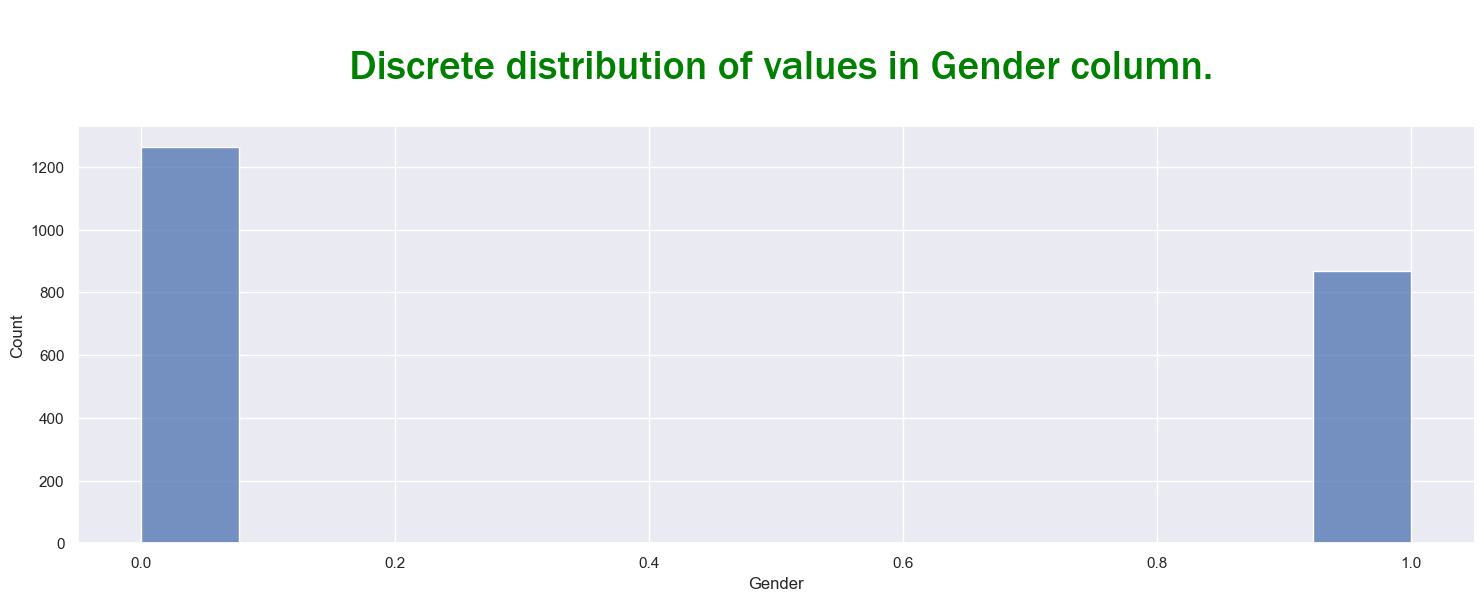

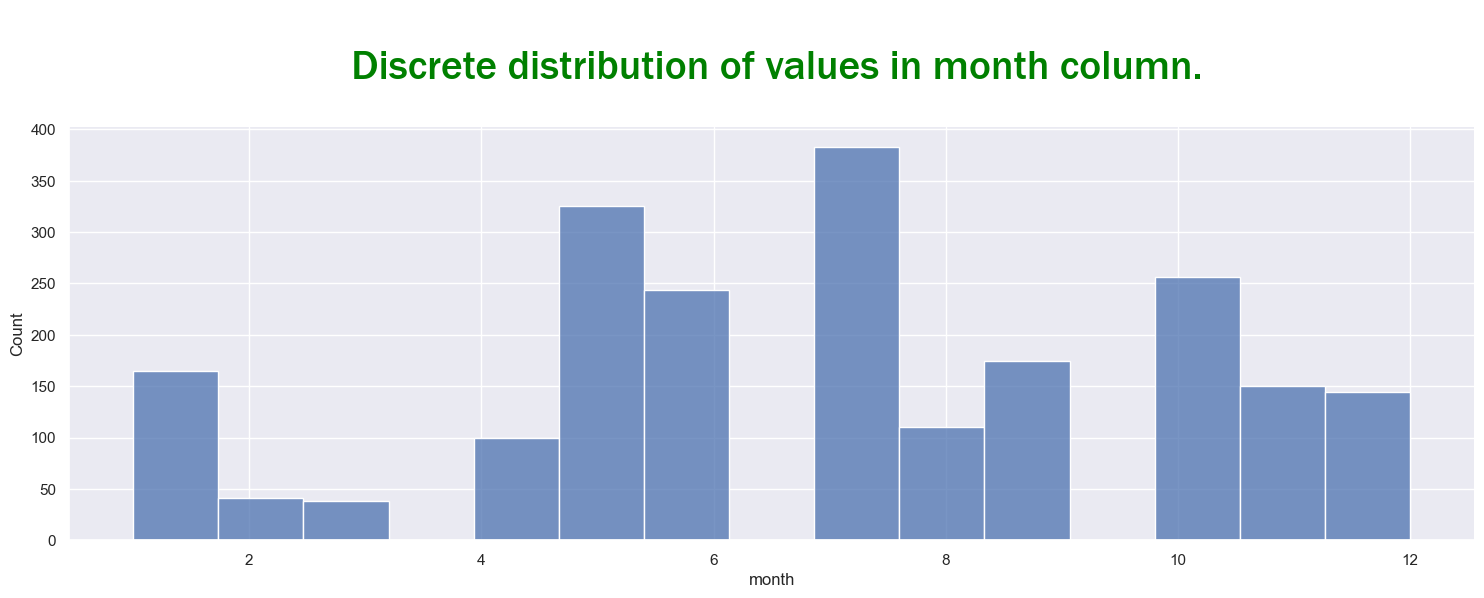

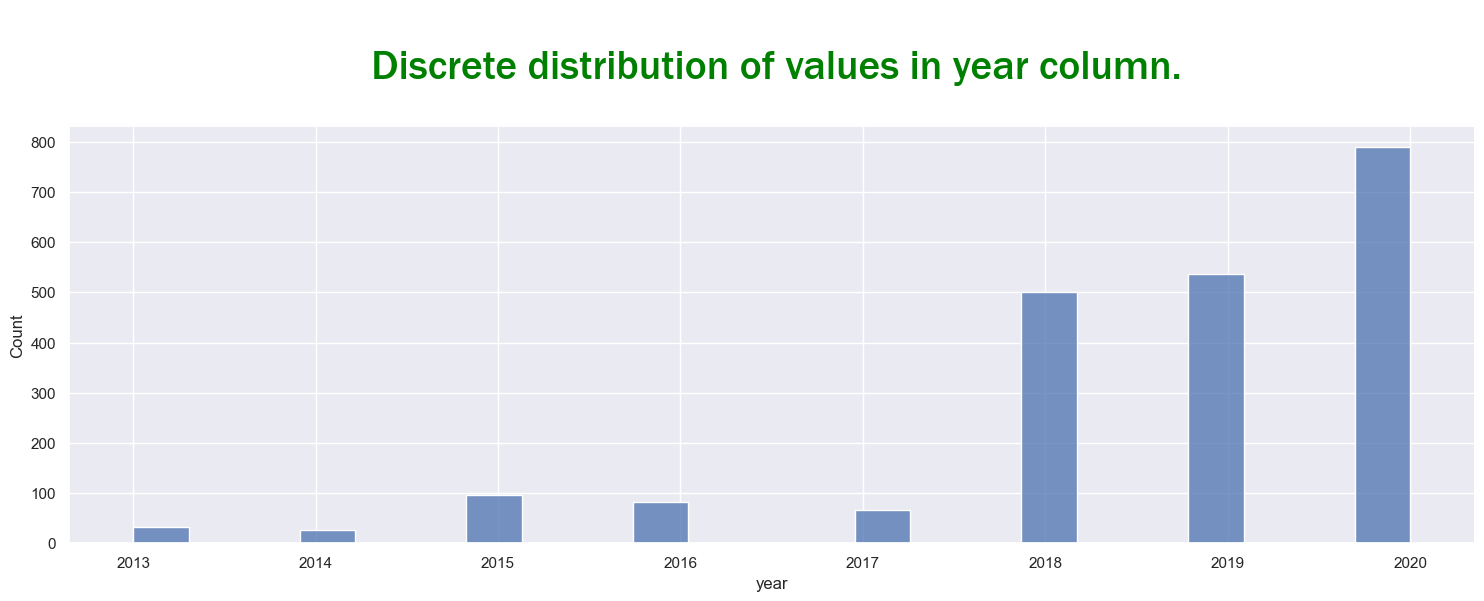

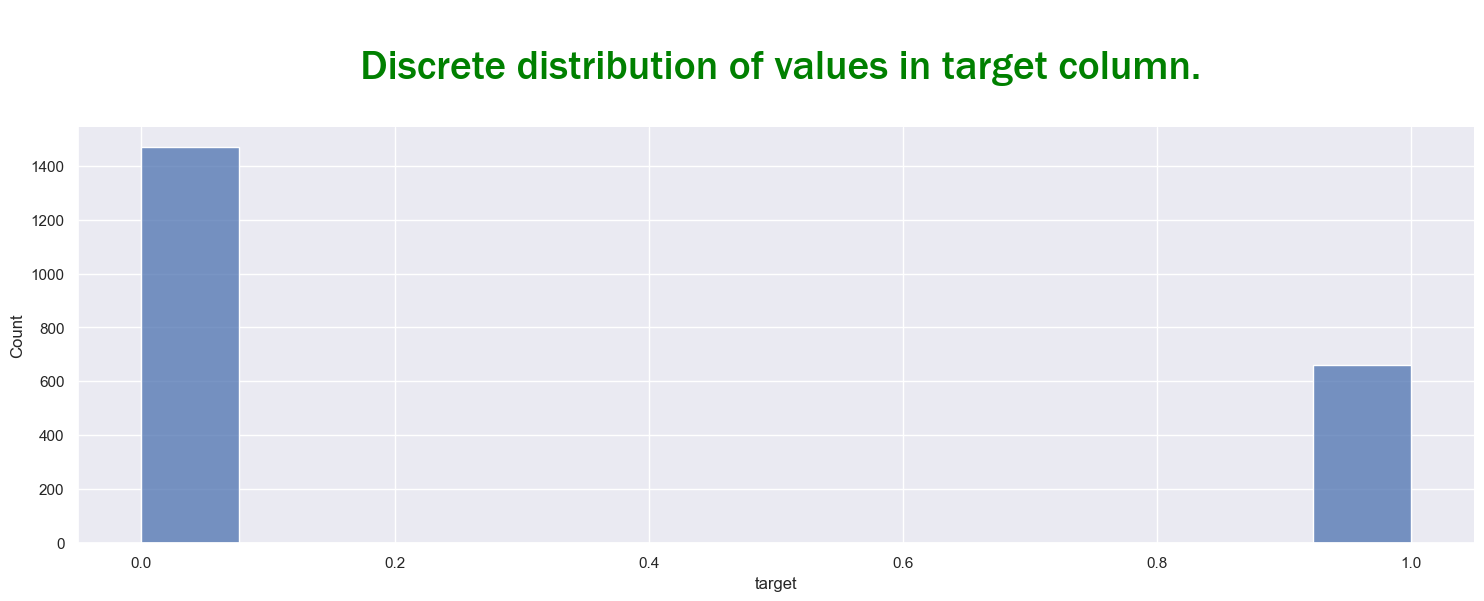

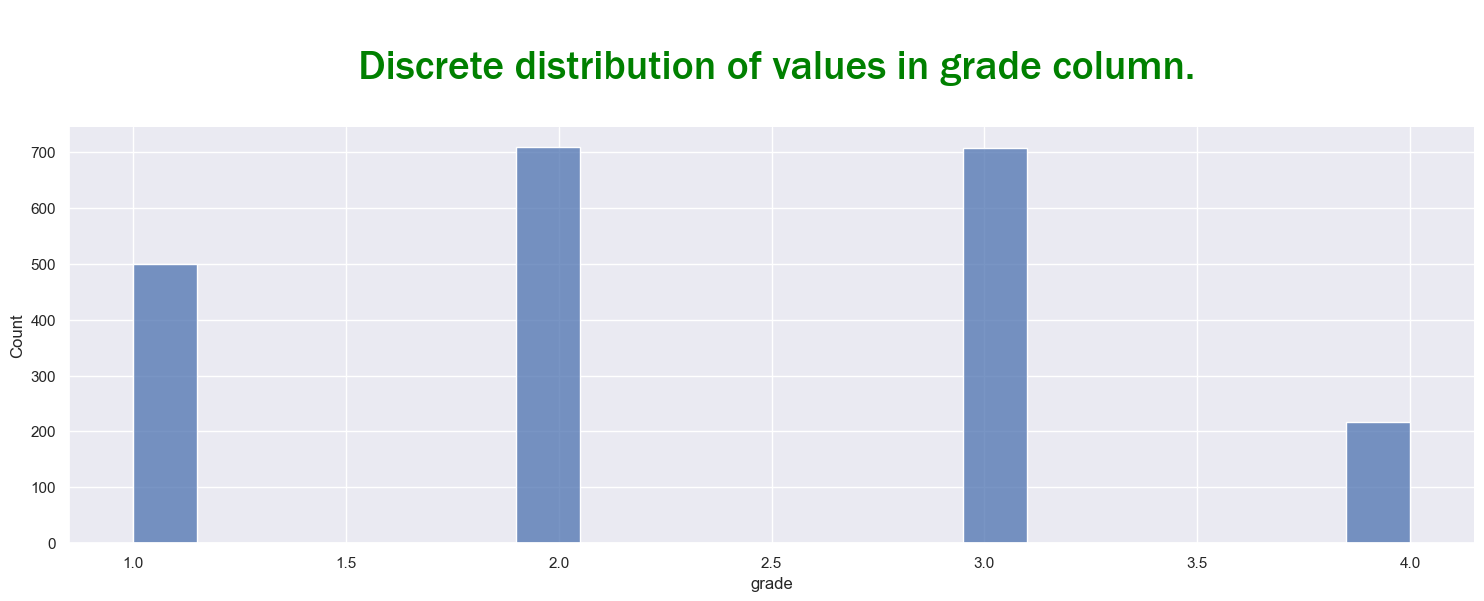

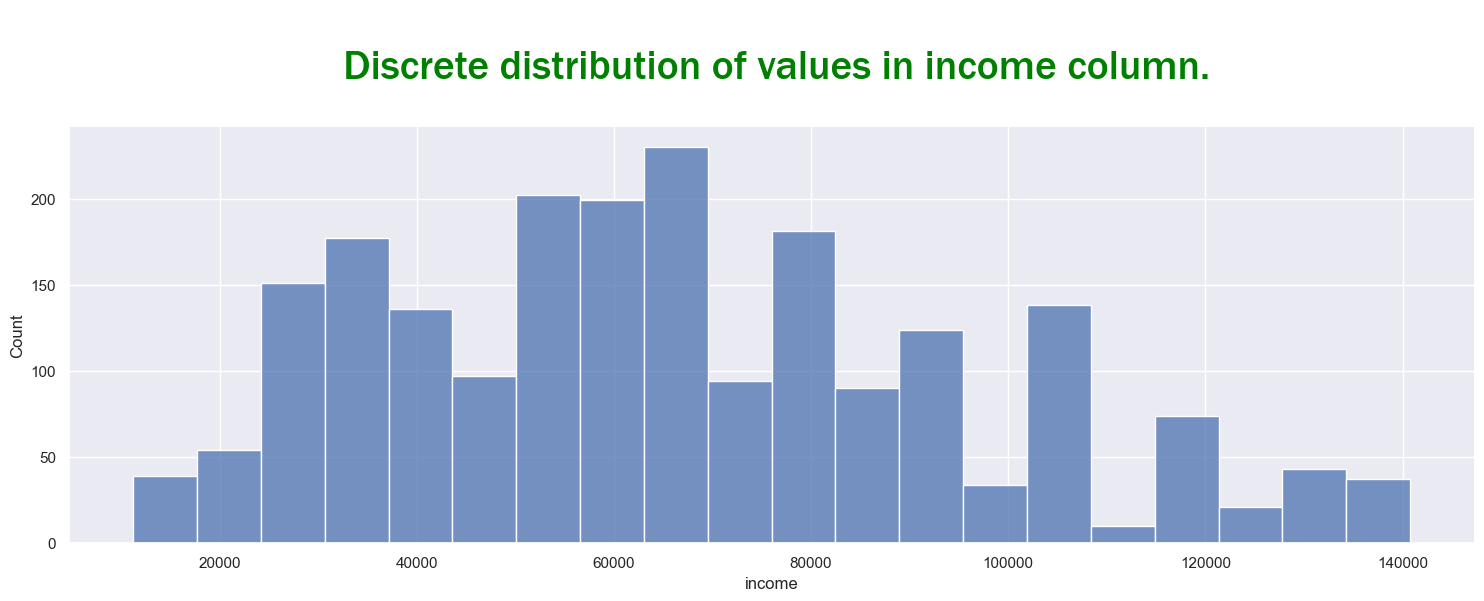

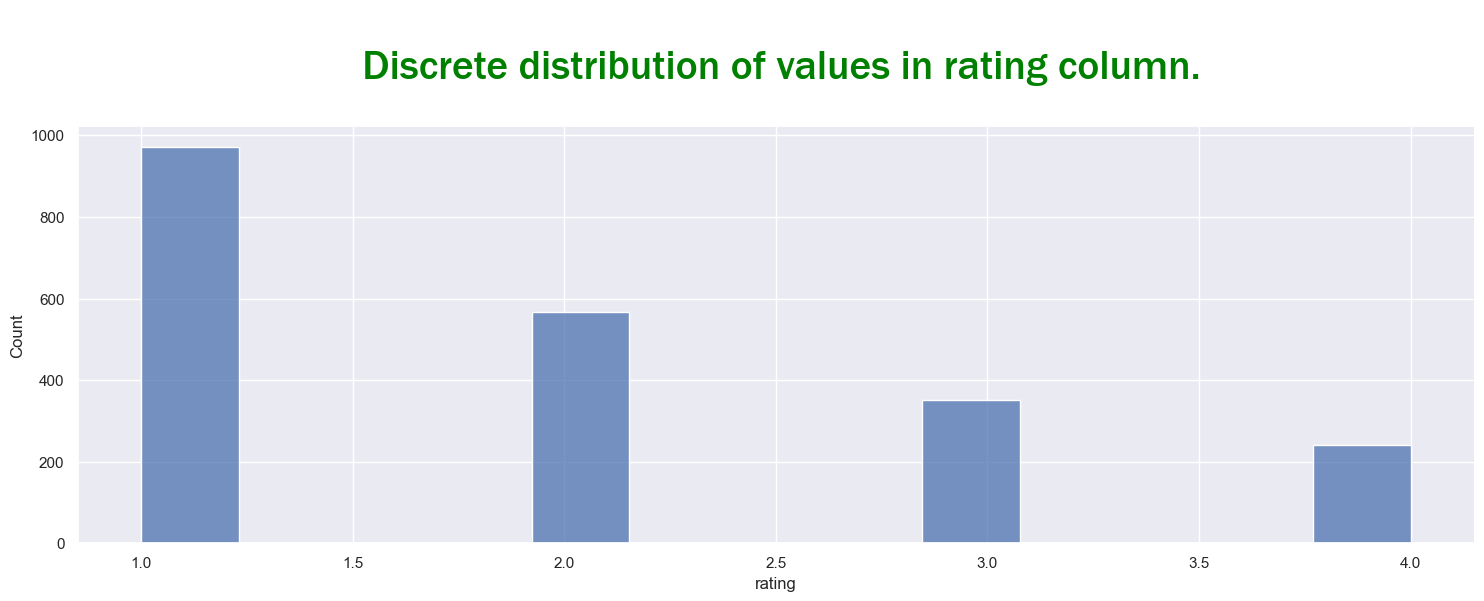

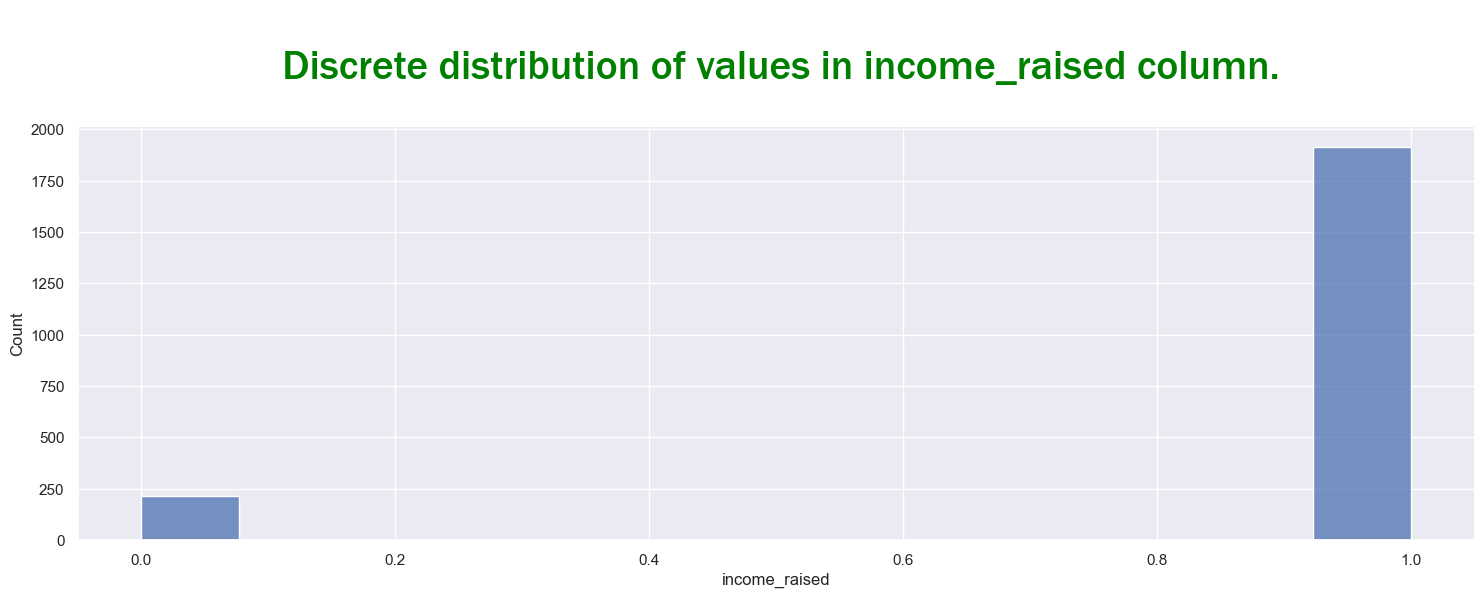

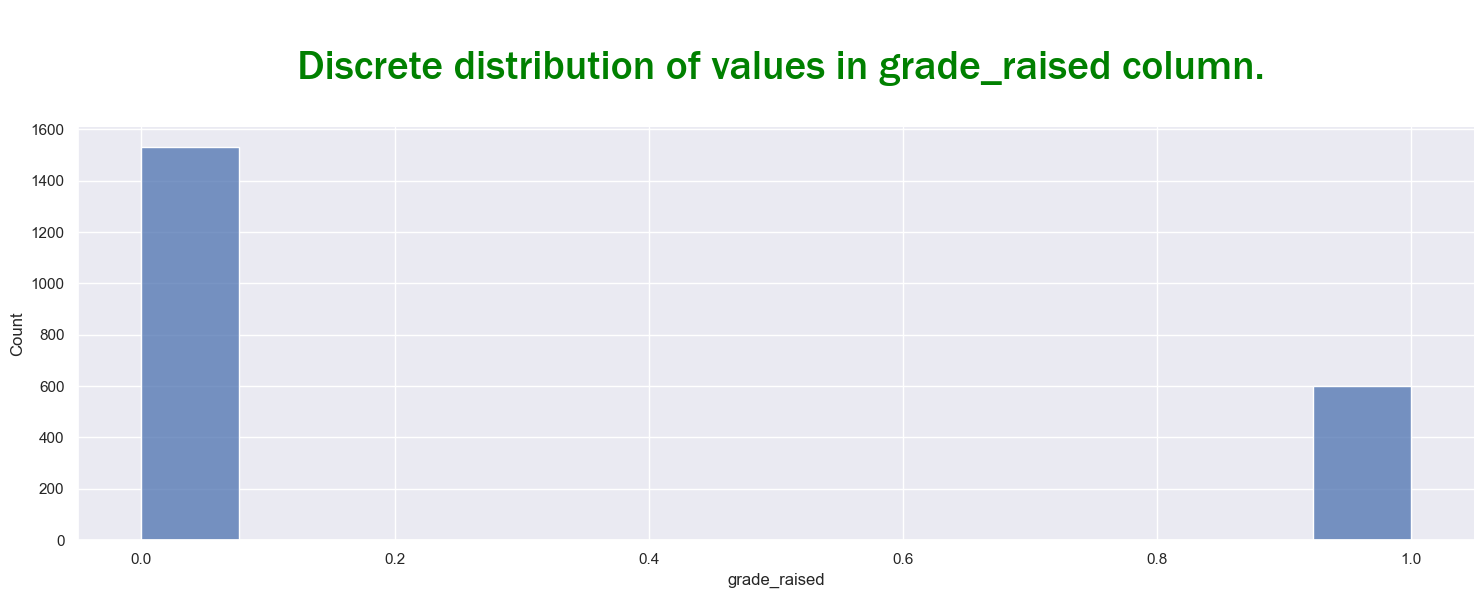

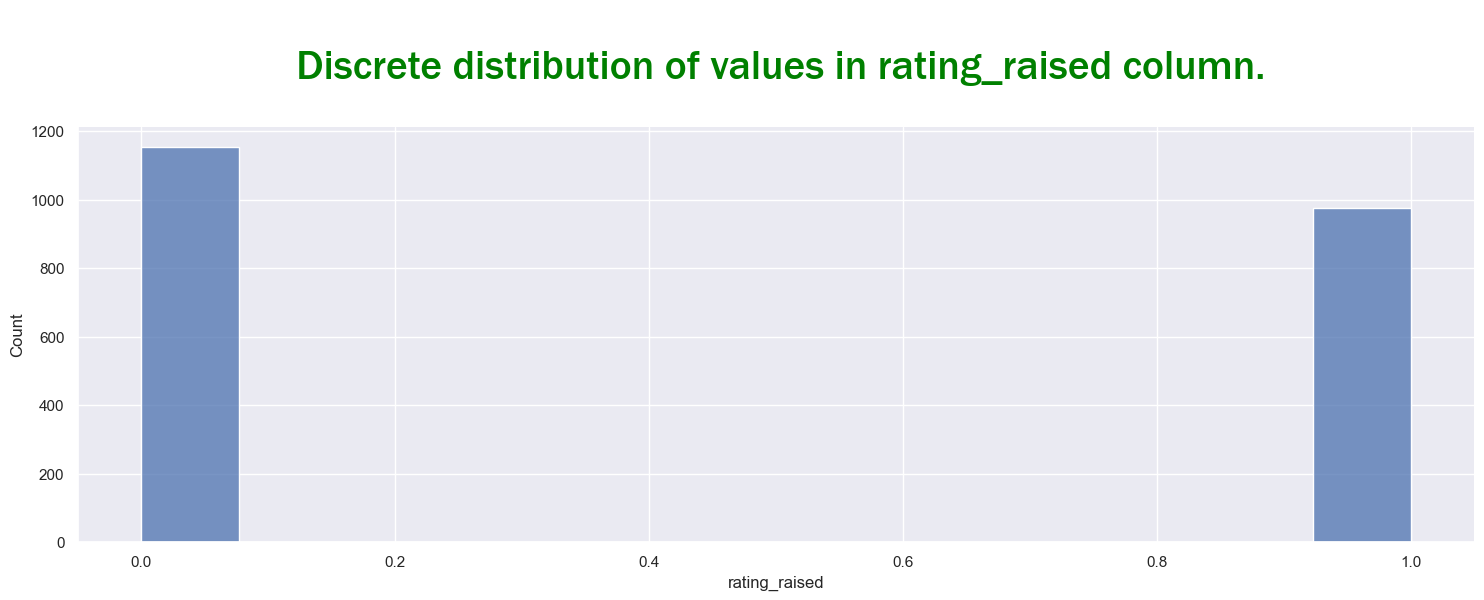

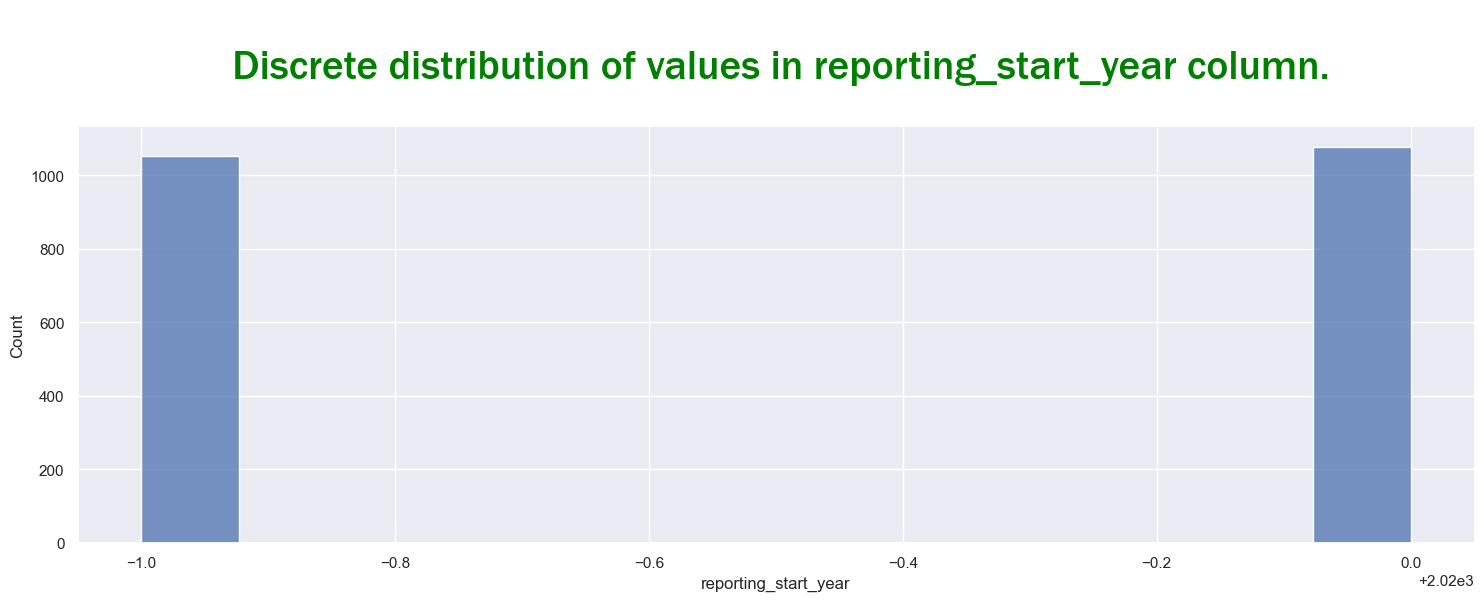

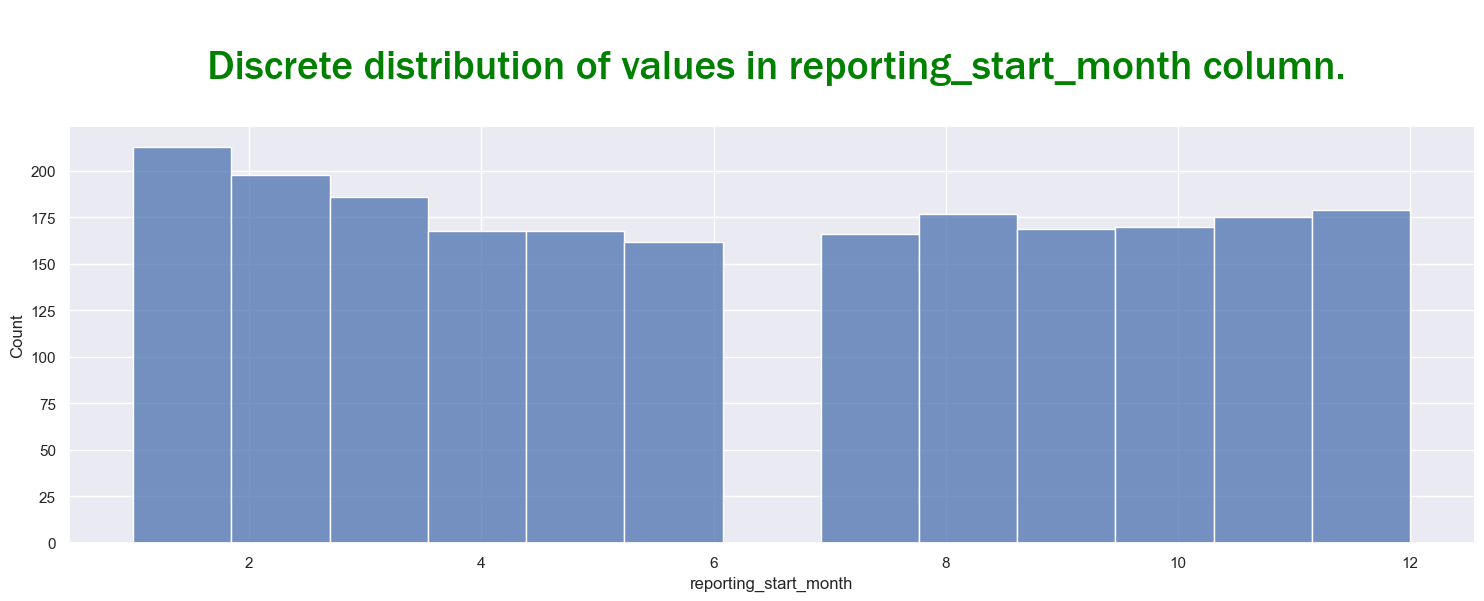

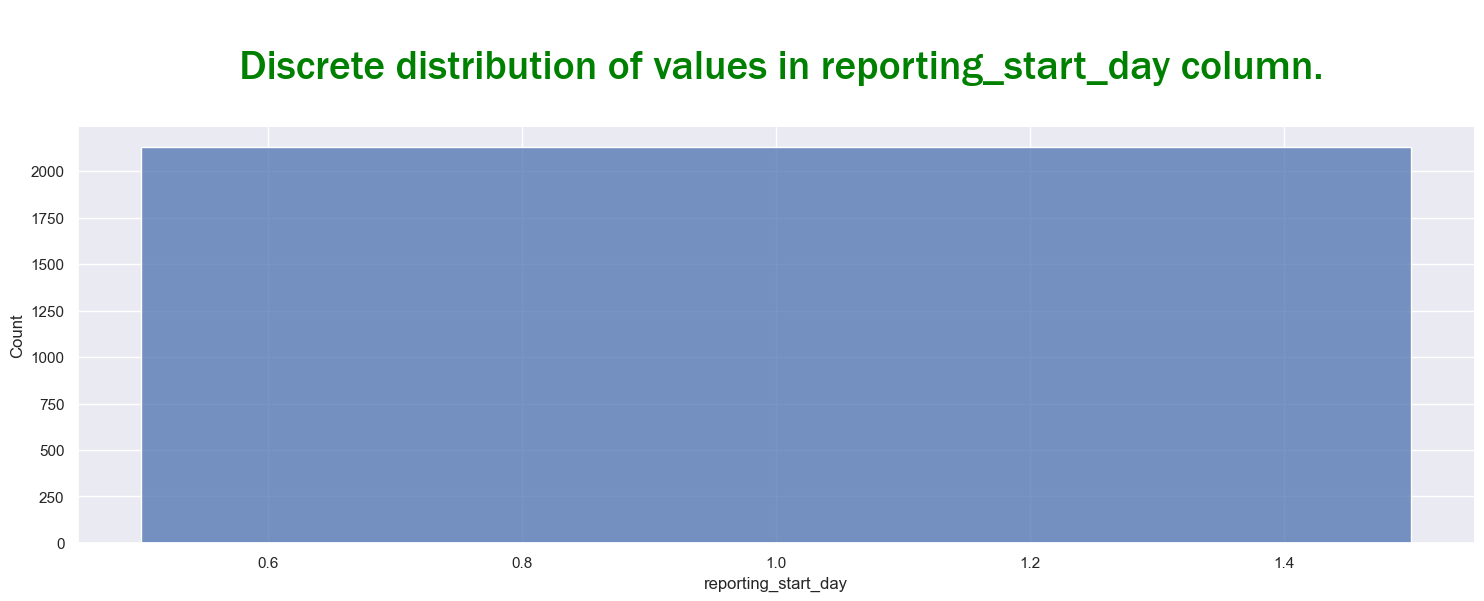

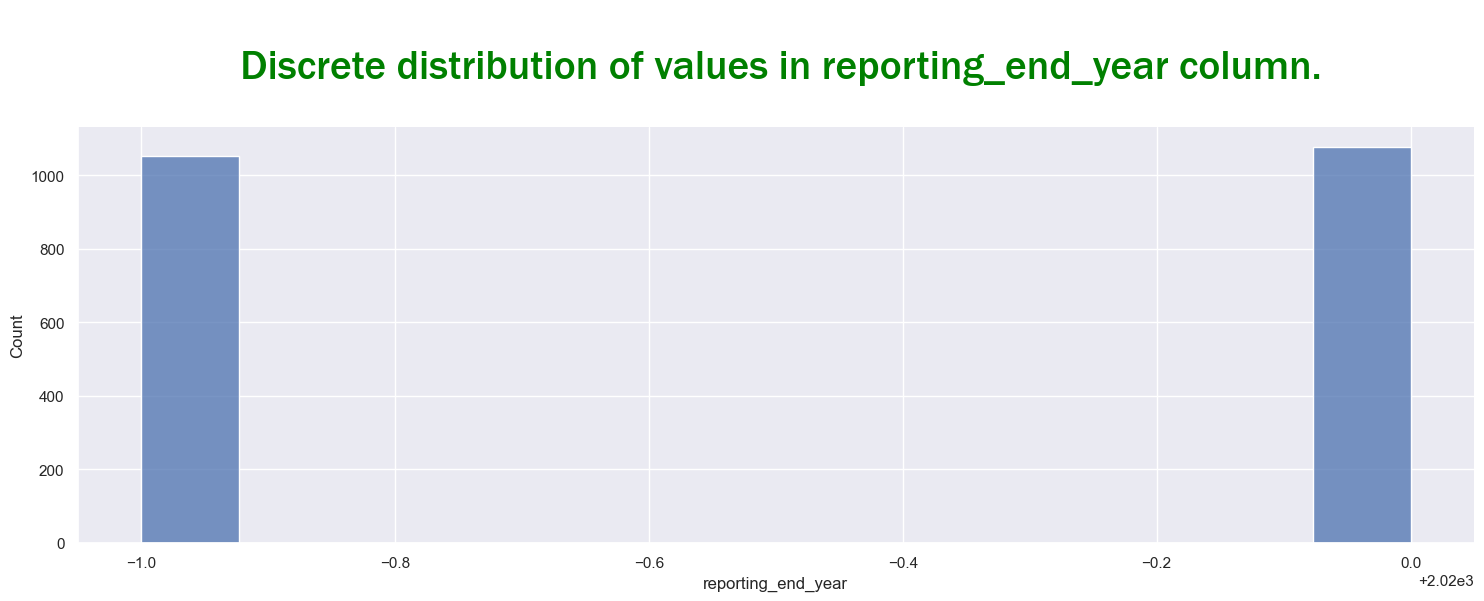

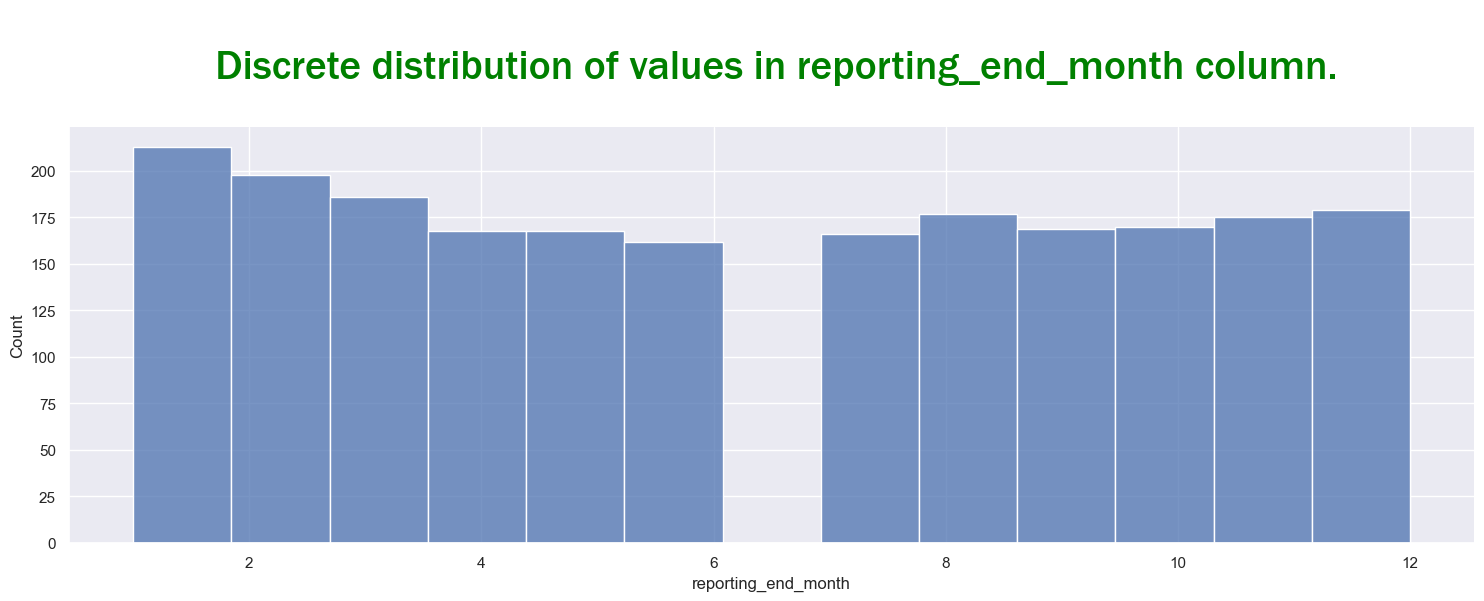

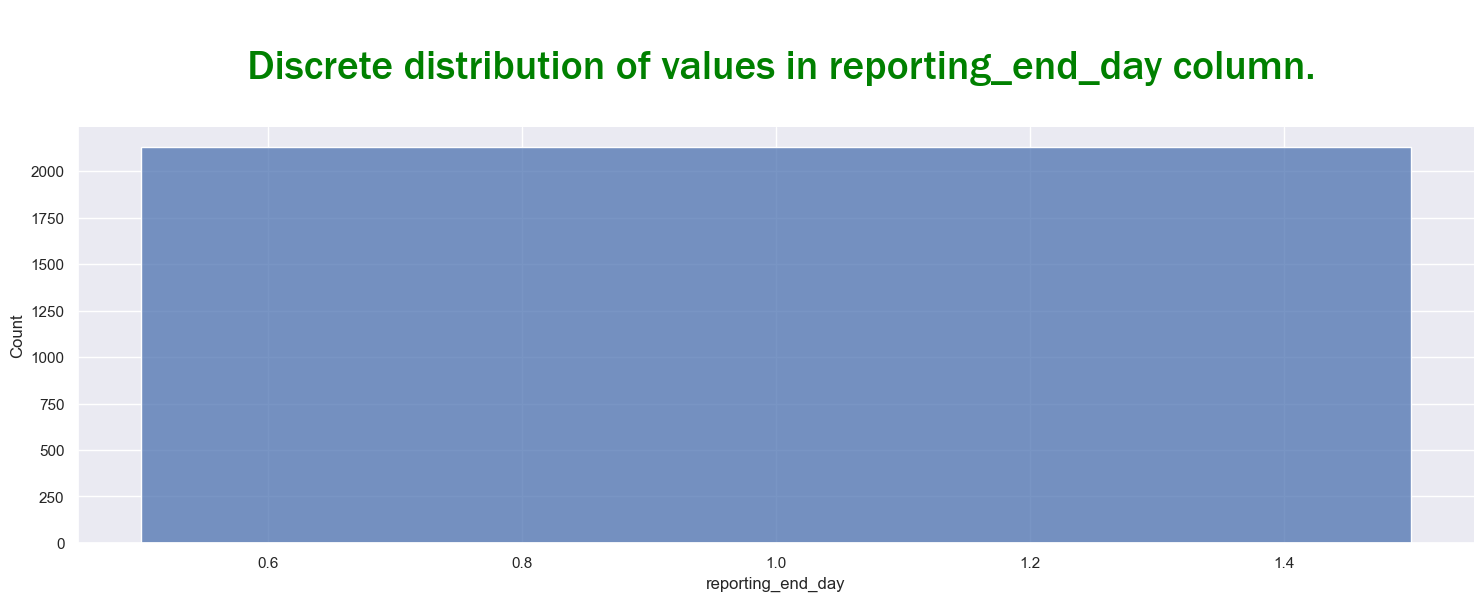

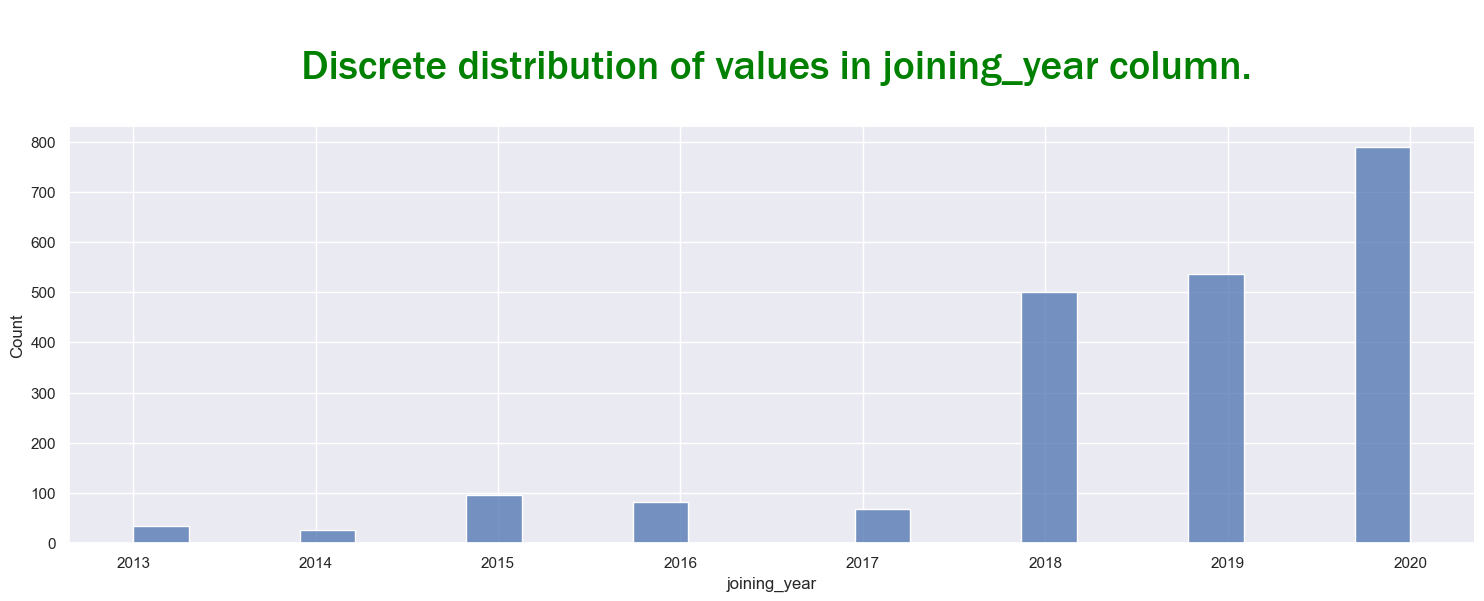

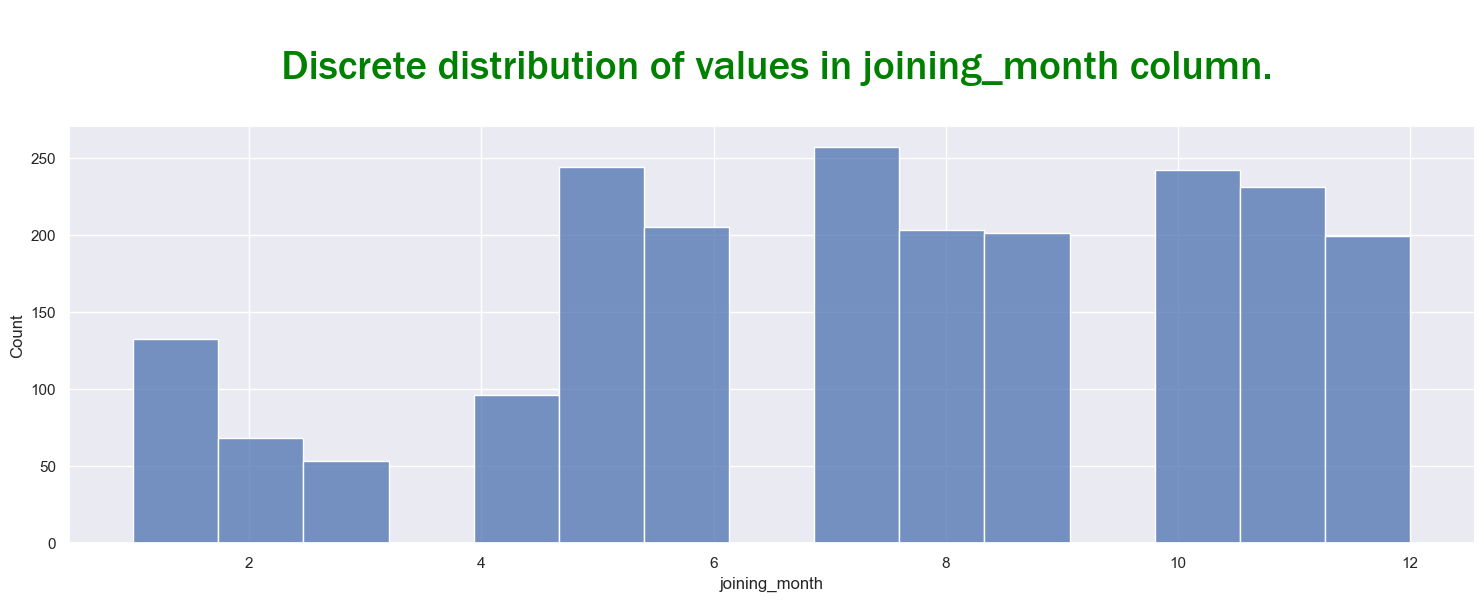

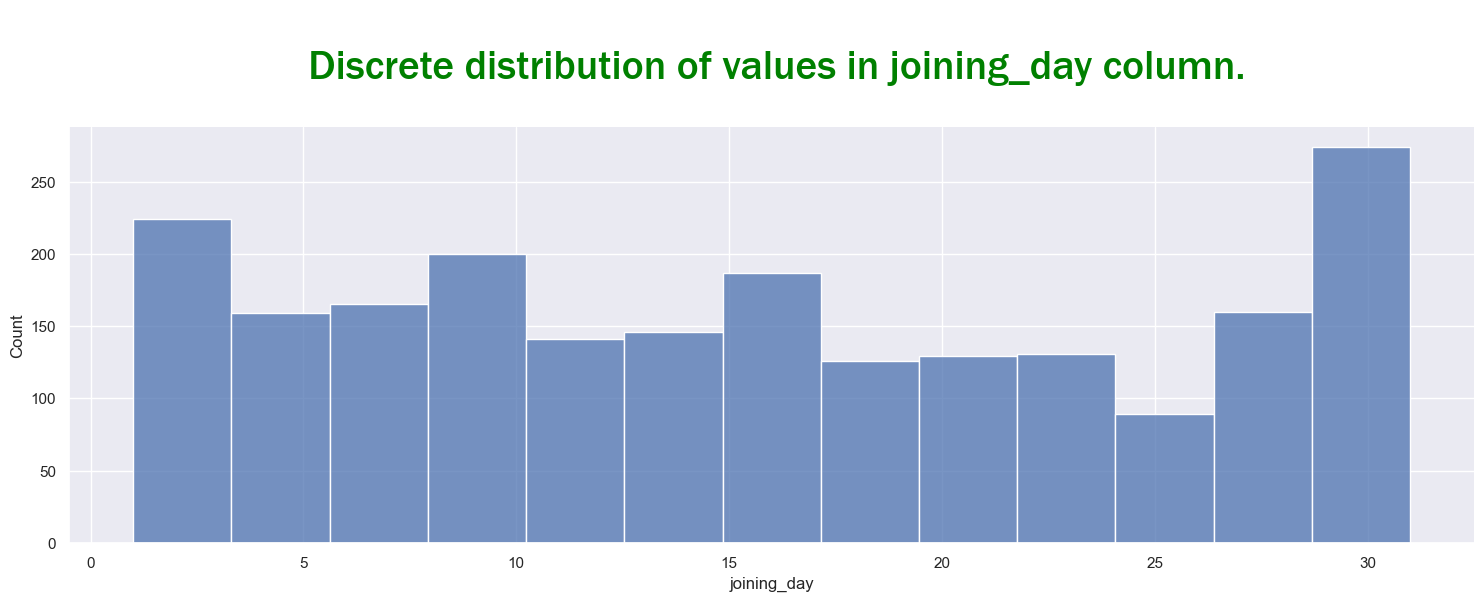

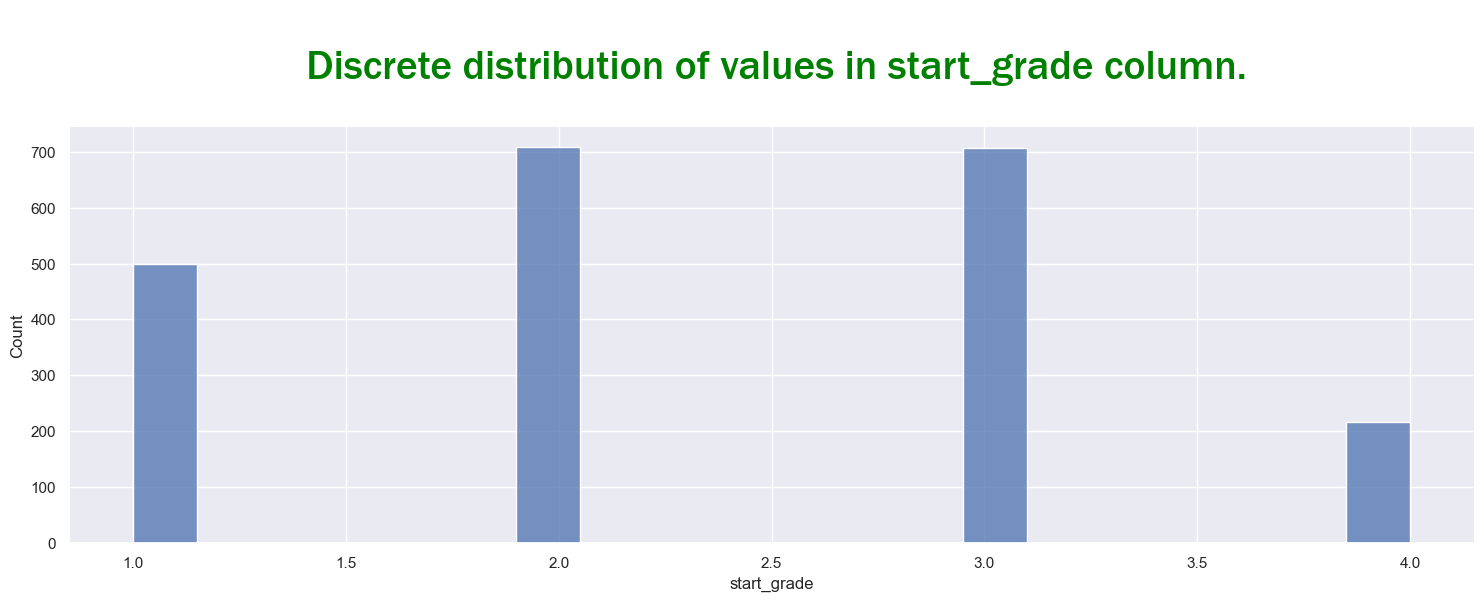

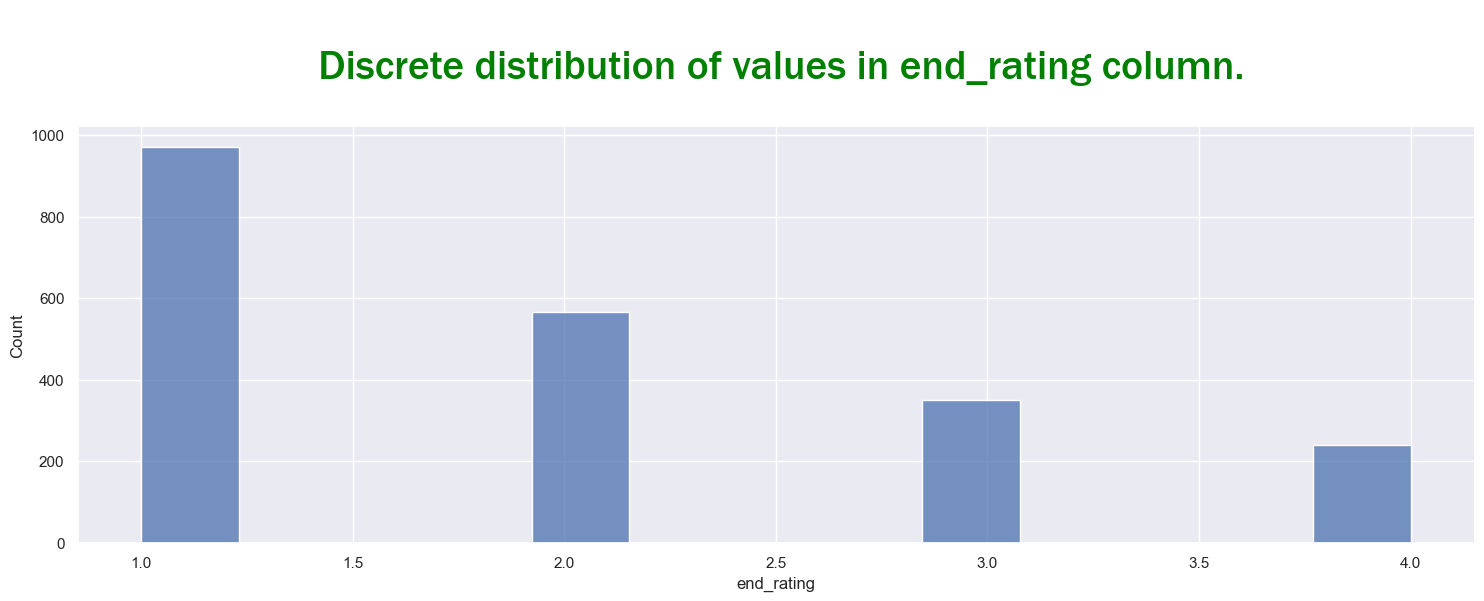

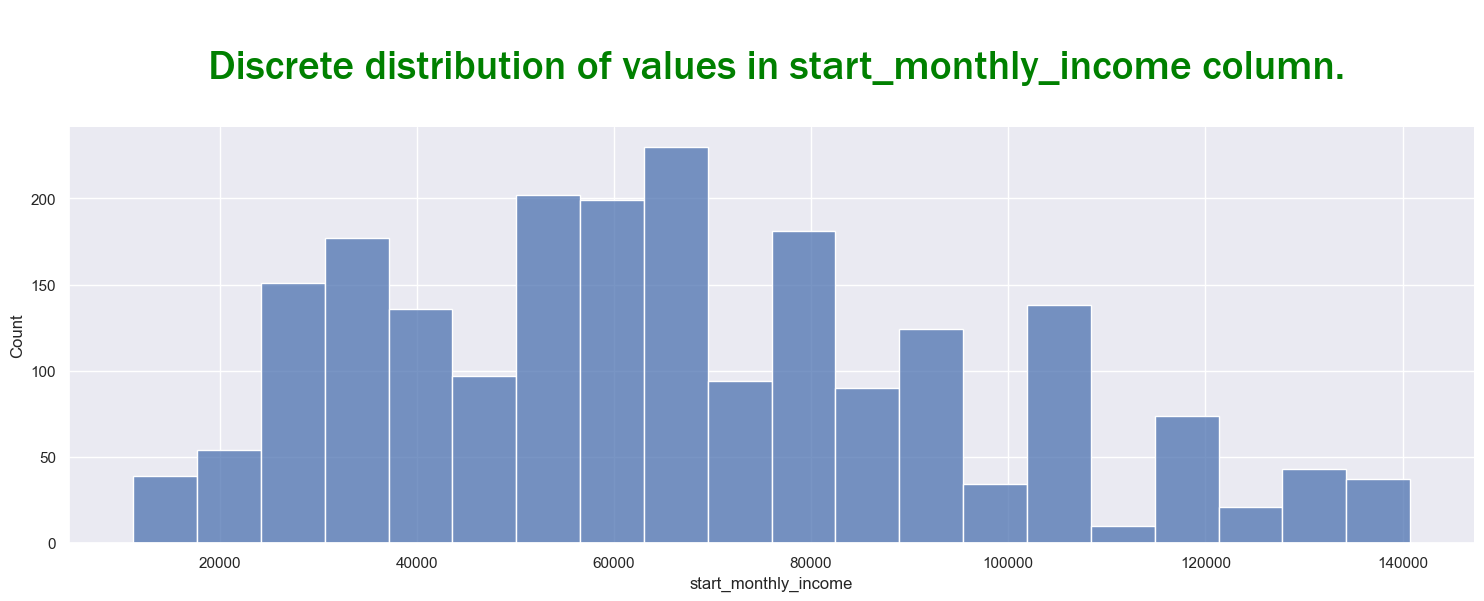

In [75]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=False, height=5, aspect=3, palette='viridis')
    plt.title(f"\n Discrete distribution of values in {column} column.\n",fontname='Franklin Gothic Medium', fontsize=30, color="green")
    plt.show()

## 4.3 Univariate Analysis (Continuous Data)

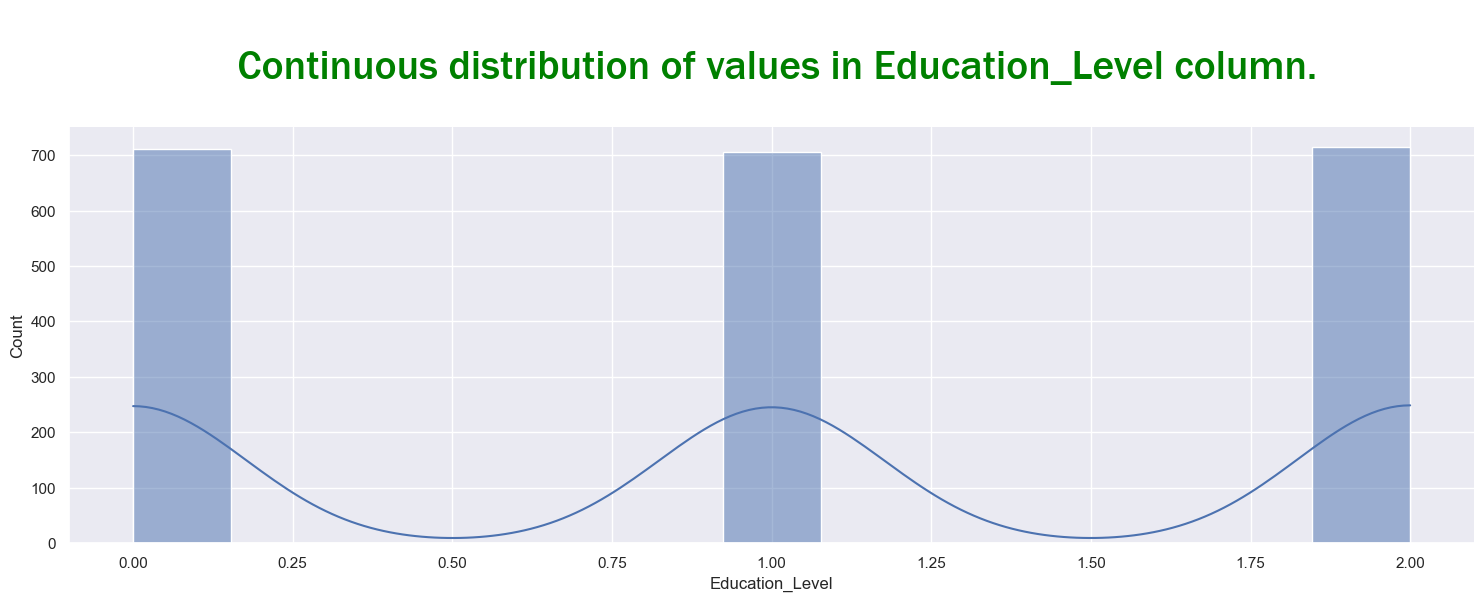

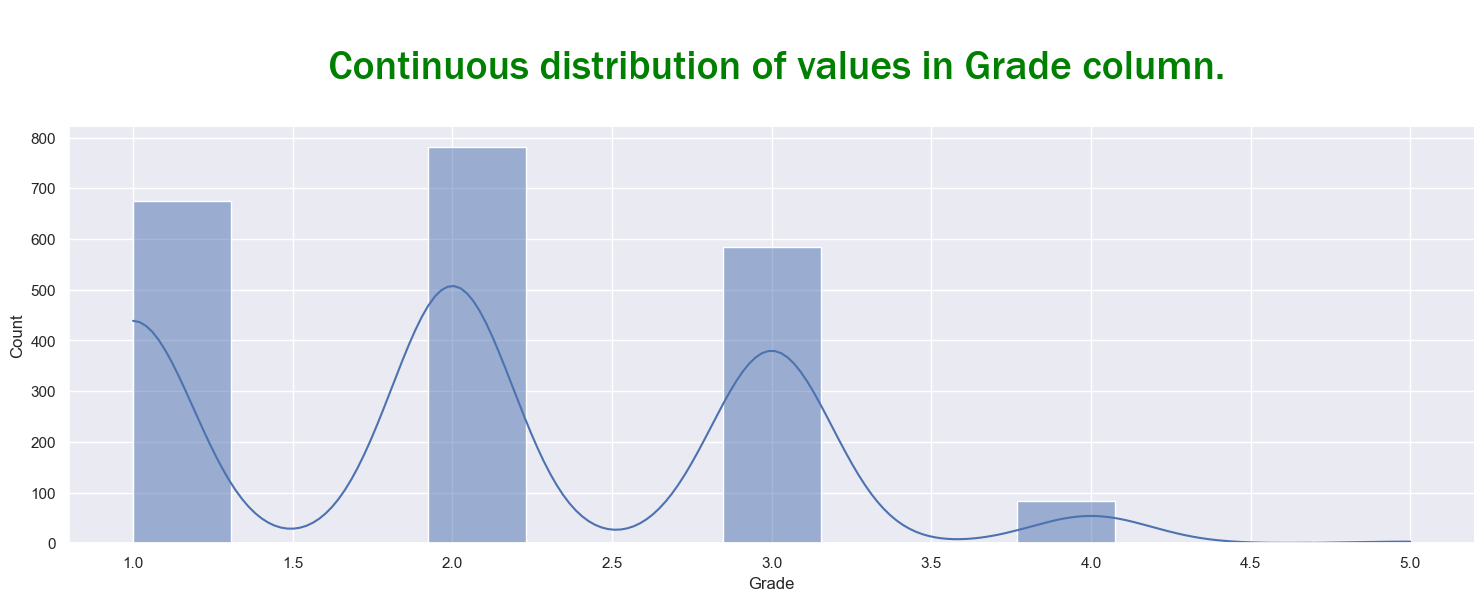

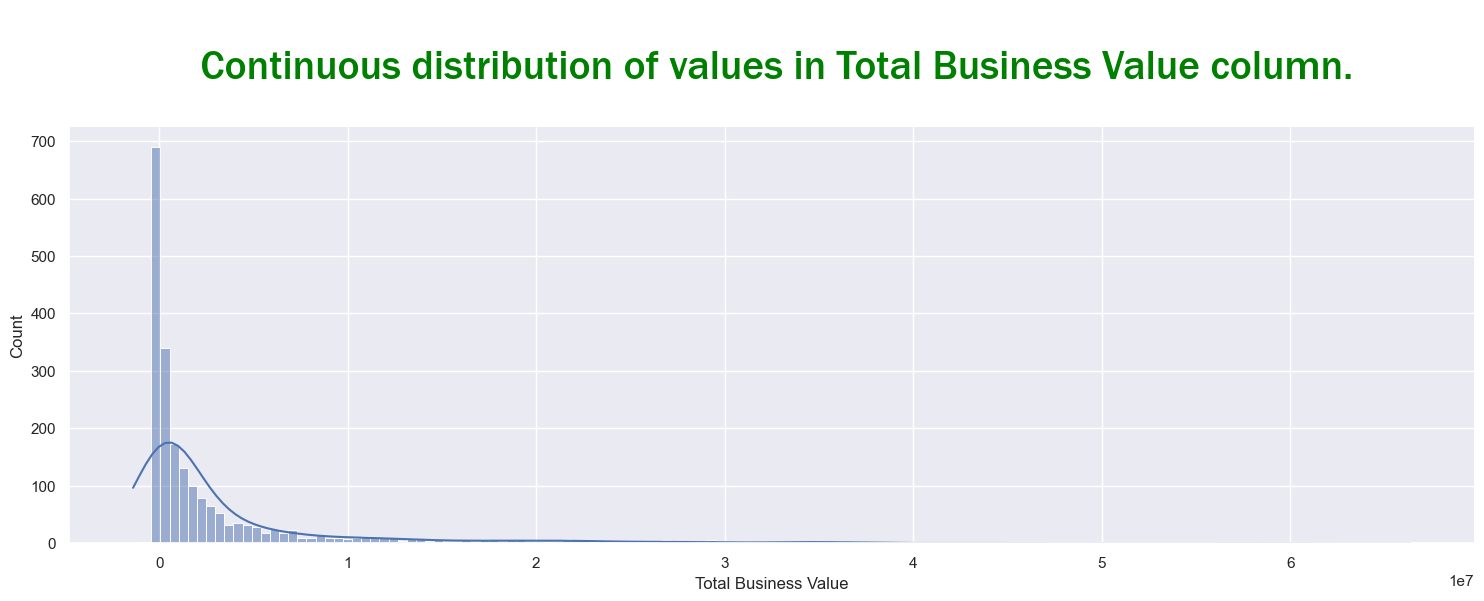

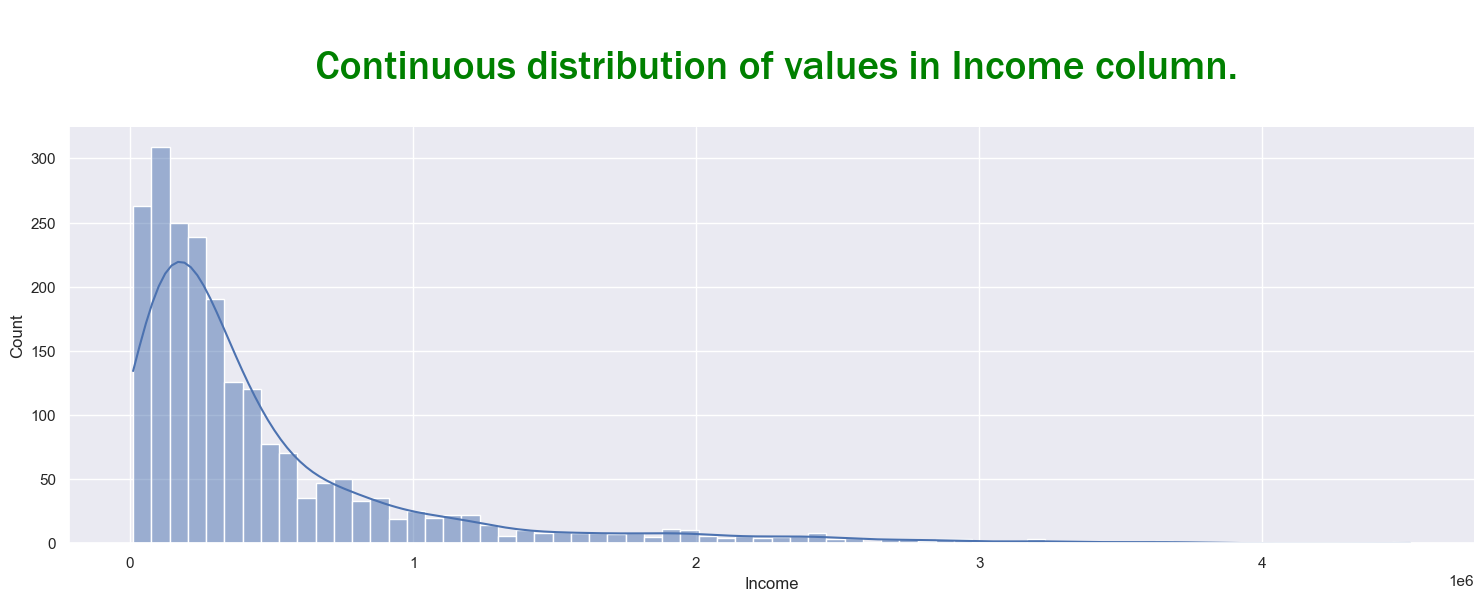

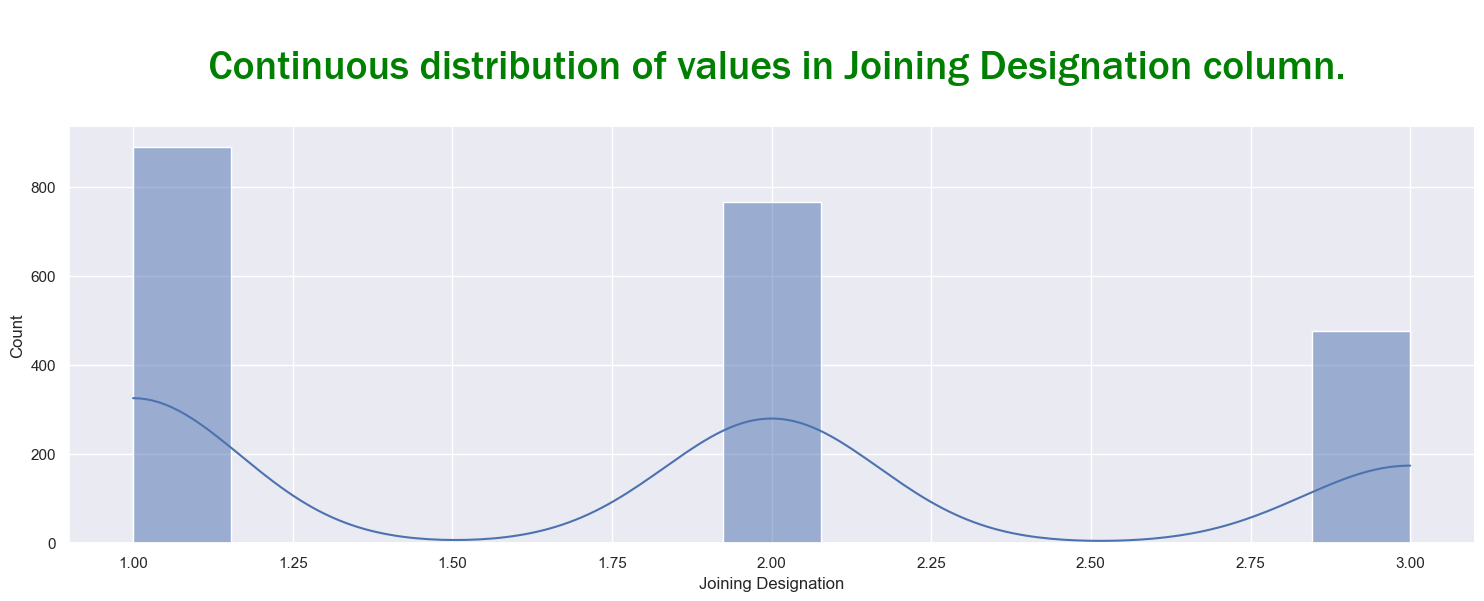

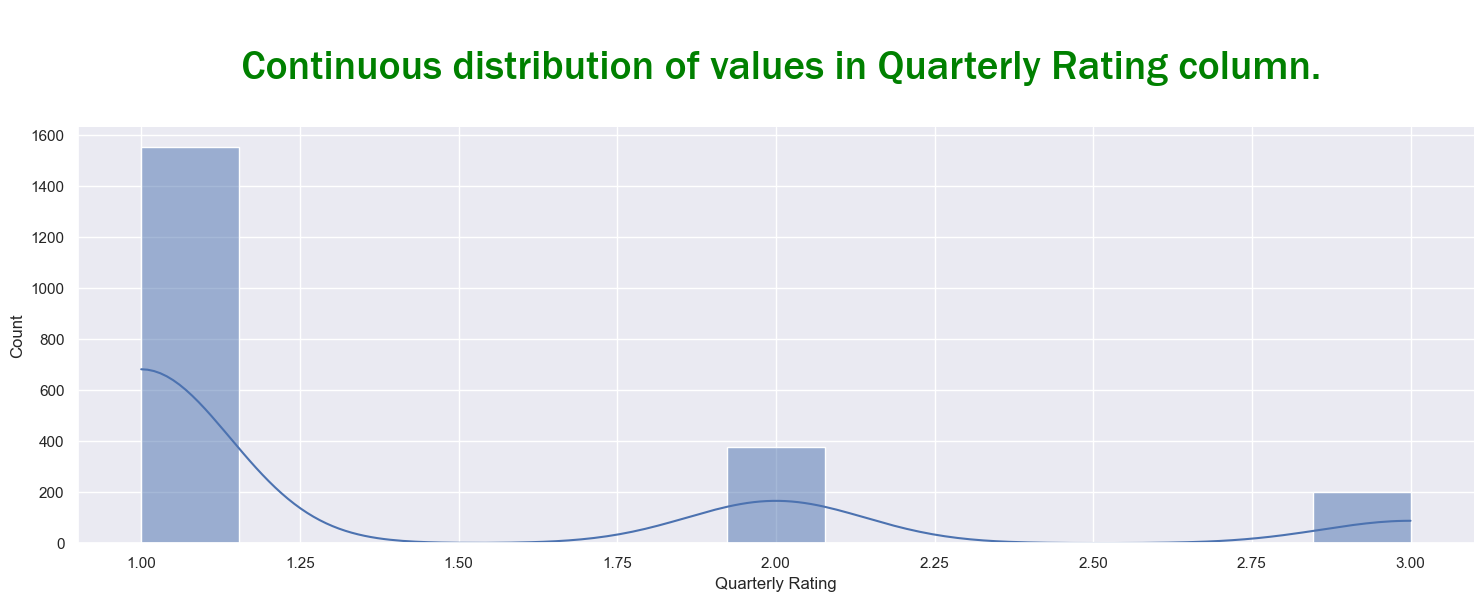

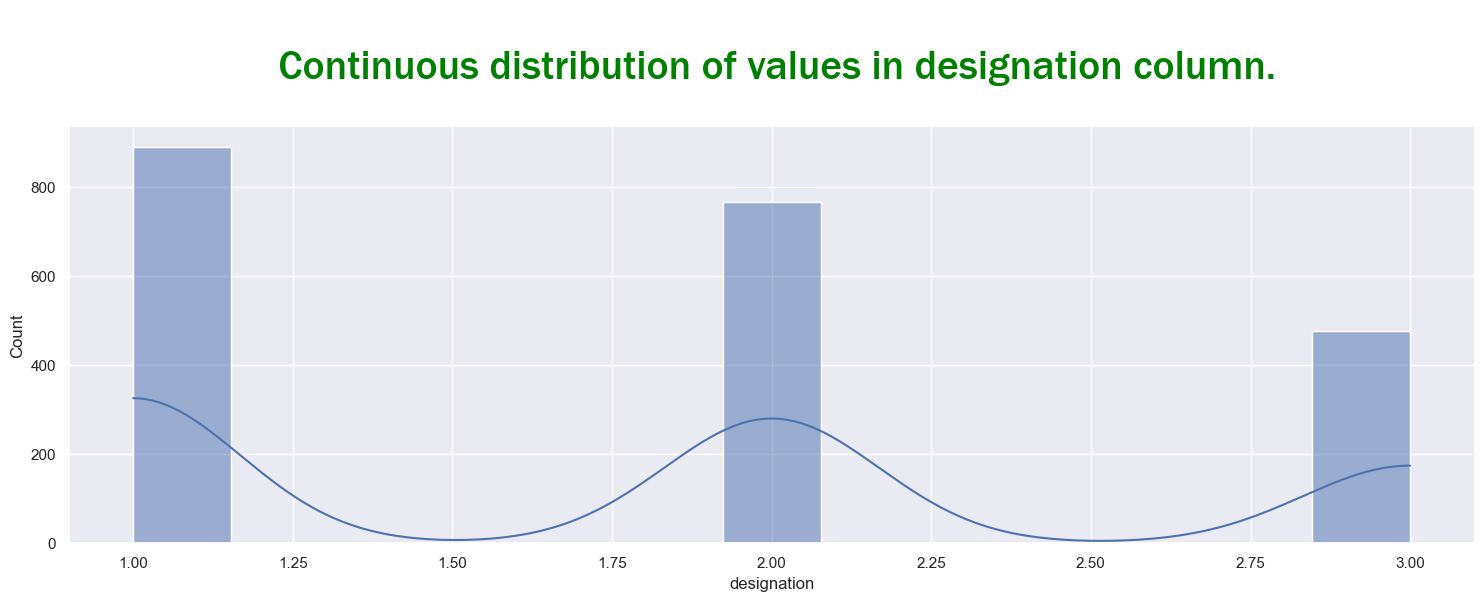

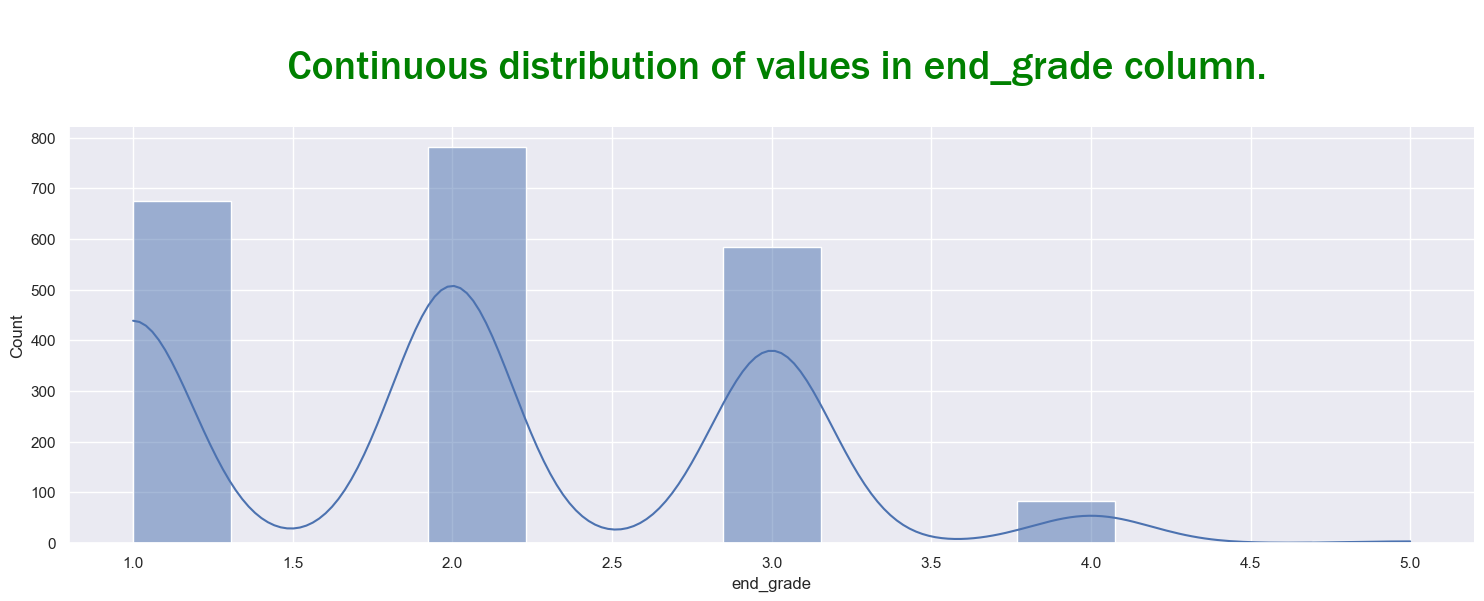

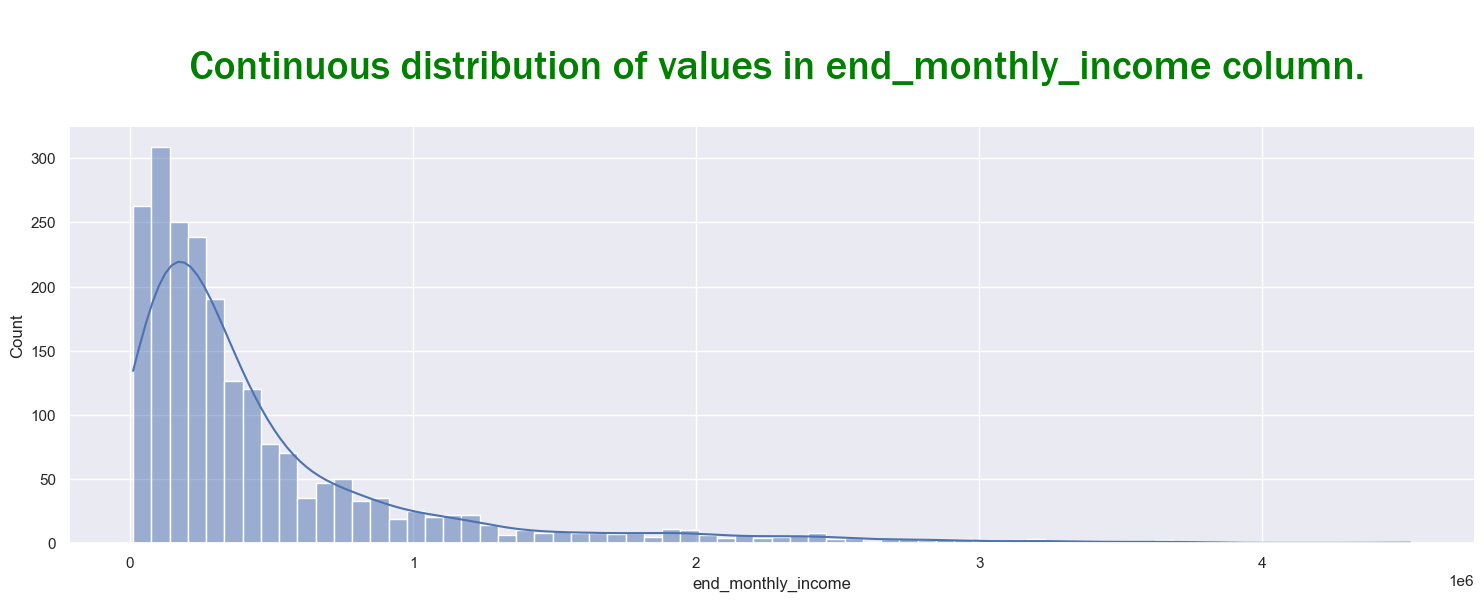

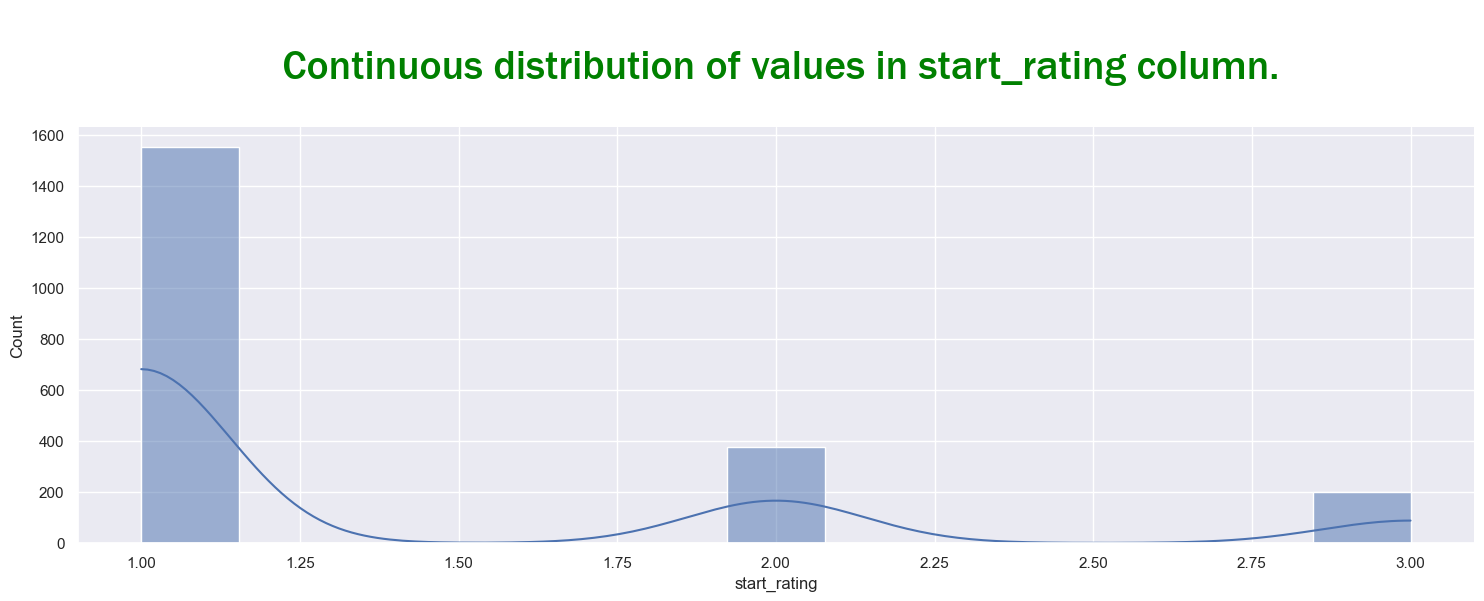

In [76]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3, palette='viridis')
    plt.title(f"\n Continuous distribution of values in {column} column.\n",fontname='Franklin Gothic Medium', fontsize=30, color="green")
    plt.show()

## 4.4 Univariate Summary

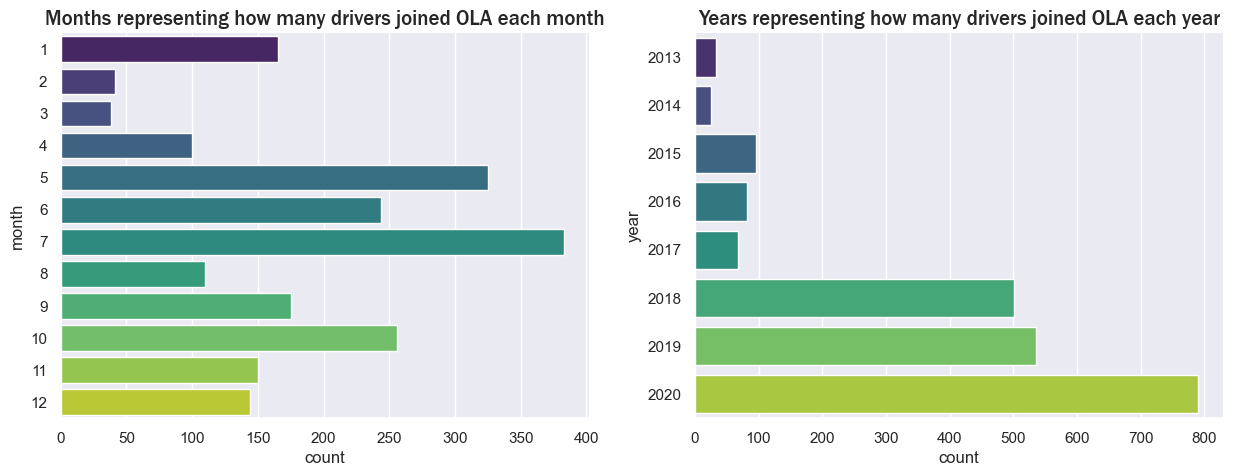

In [77]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
sns.countplot(y=df.month,palette='viridis')
plt.title('Months representing how many drivers joined OLA each month',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,2,2)
sns.countplot(y=df.year,palette='viridis')
plt.title('Years representing how many drivers joined OLA each year',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

- July received the maximum number of drivers in 8 years.
- February and March receives the least number of Drivers joining OLA.
- Joining of Drivers receives a boost of about 500% after 2017.

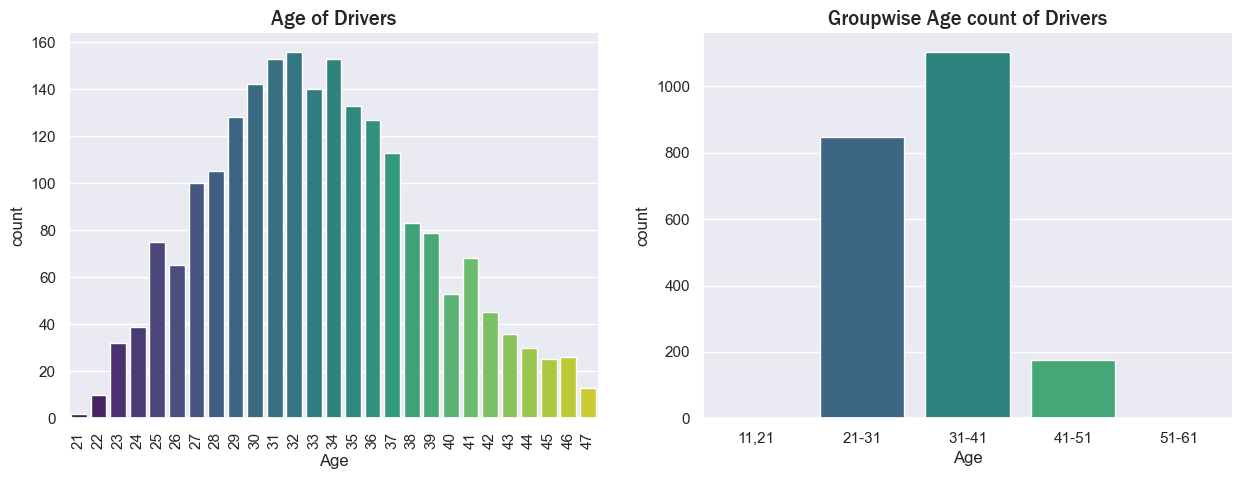

In [78]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
sns.countplot(x=df.Age,palette='viridis')
plt.title('Age of Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.xticks(rotation=90)

ax = fig.add_subplot(122)
a = pd.cut(df.Age,bins=[11,21,31,41,51,61],labels=['11,21','21-31','31-41','41-51','51-61'])
sns.countplot(x=a,palette='viridis')
plt.title('Groupwise Age count of Drivers',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()


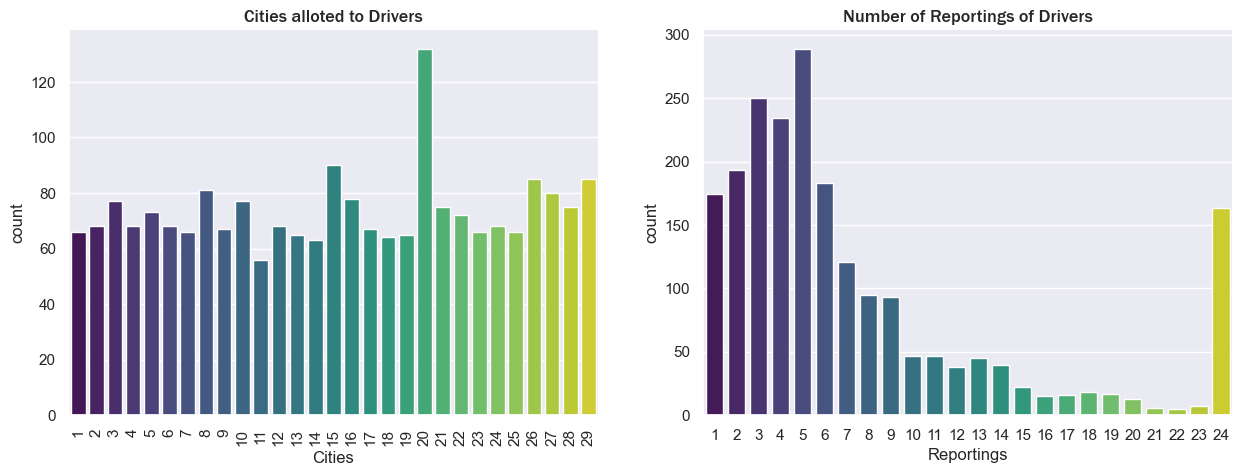

In [79]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
sns.countplot(x=df.Cities,palette='viridis')
plt.title('Cities alloted to Drivers',fontname='Franklin Gothic Medium', fontsize=13)
plt.xticks(rotation=90)

ax = fig.add_subplot(122)
sns.countplot(x=df.Reportings,palette='viridis')
plt.title('Number of Reportings of Drivers',fontname='Franklin Gothic Medium', fontsize=13)
          
sns.despine()
plt.show()

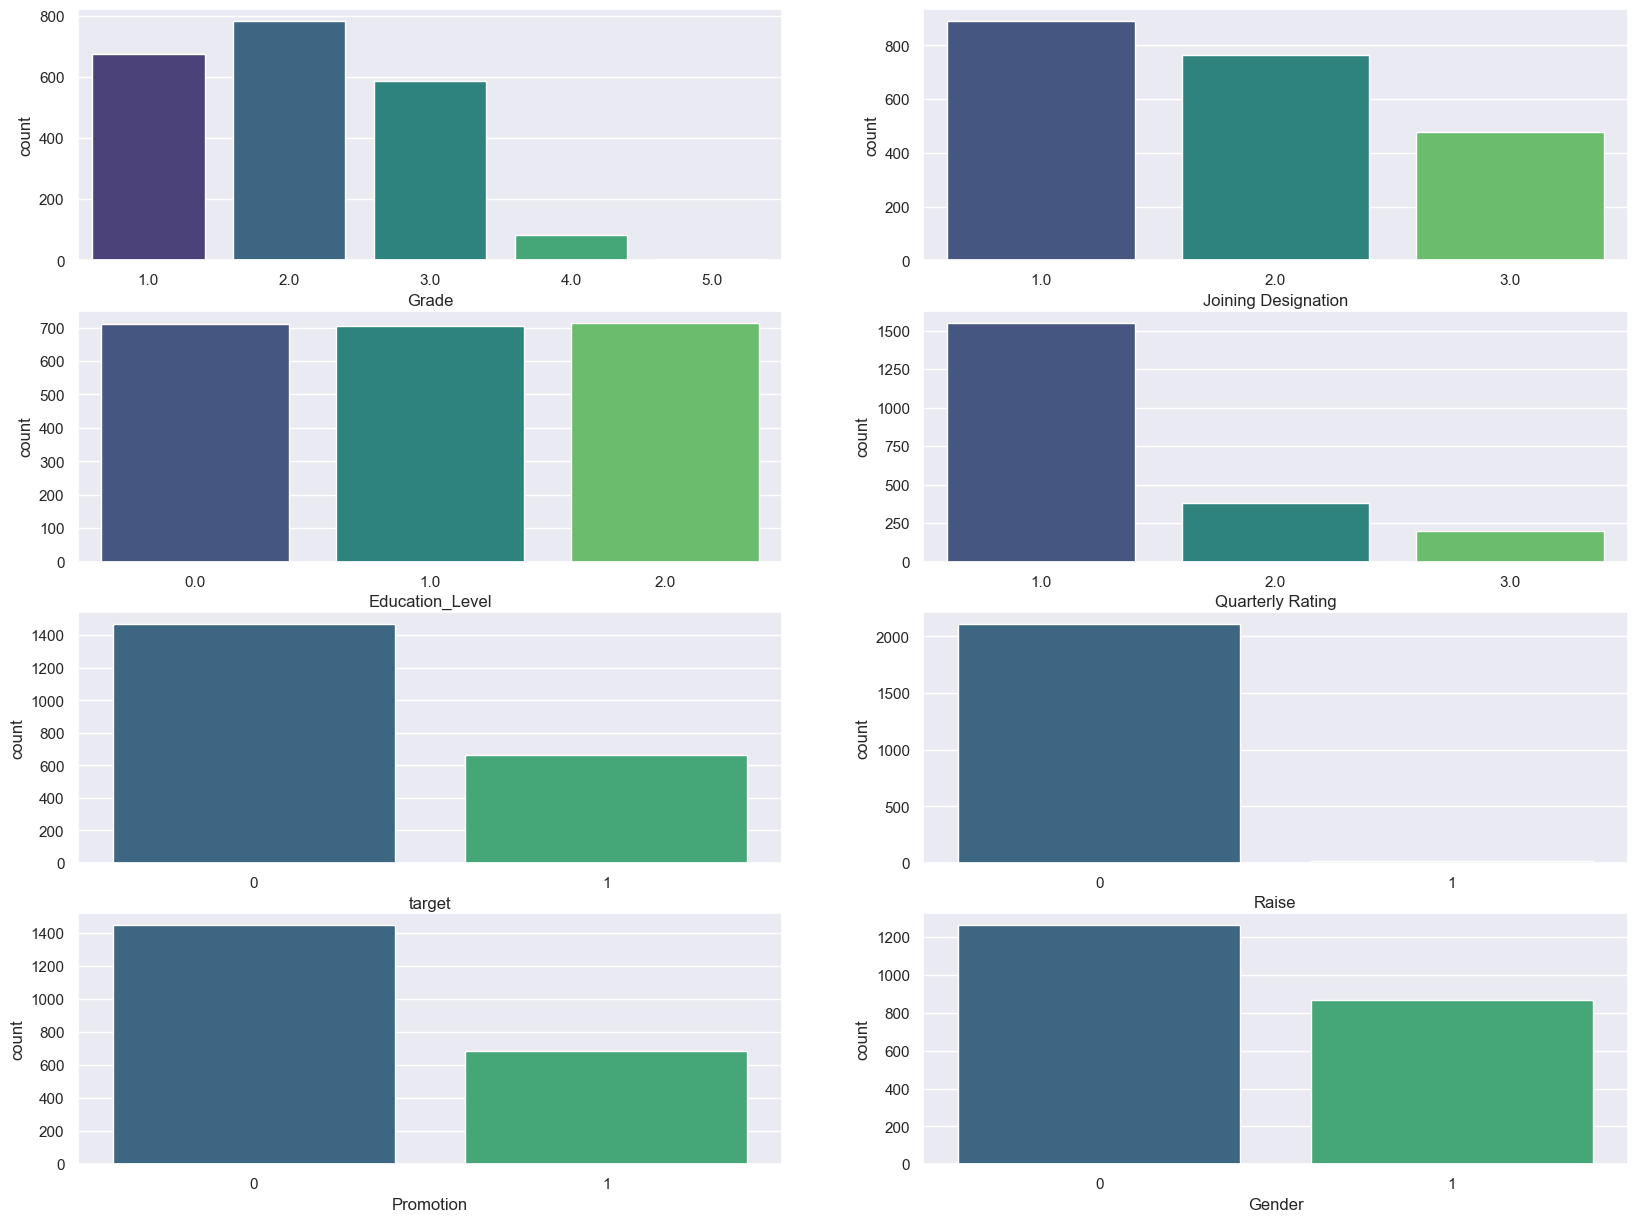

In [80]:
plt.figure(figsize=(20,15))
plt.subplot(4,2,1)
sns.countplot(x=df.Grade,palette='viridis')

plt.subplot(4,2,2)
sns.countplot(x=df['Joining Designation'],palette='viridis')

plt.subplot(4,2,3)
sns.countplot(x=df.Education_Level,palette='viridis')

plt.subplot(4,2,4)
sns.countplot(x=df['Quarterly Rating'],palette='viridis')

plt.subplot(4,2,5)
sns.countplot(x=df.target,palette='viridis')

plt.subplot(4,2,6)
sns.countplot(x=df.Raise,palette='viridis')

plt.subplot(4,2,7)
sns.countplot(x=df.Promotion,palette='viridis')

plt.subplot(4,2,8)
sns.countplot(x=df.Gender,palette='viridis')
plt.show()

- Between 21 years(min age) to 58(max age) years of age, maximum number of drivers are 32 years o
meanwhile the age group between 31-41 years of age receives the maximum number of drivers.
- 58.9% of the Drivers are male.
- City C20 has been used by the most of the drivers.
- There are 3 Education levels and all of them alomst have the equal distribution of Drivers.
- Grade 2 has been received by most of the Drivers and then the count of grade keeps on falling.

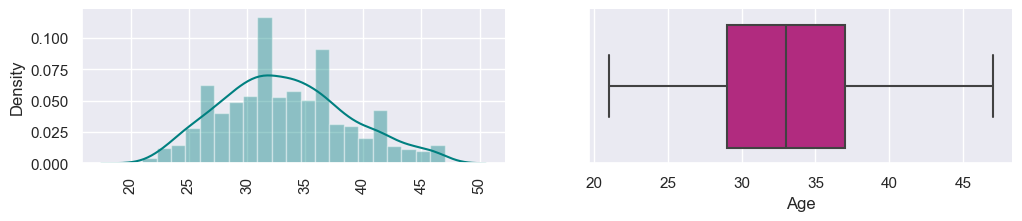

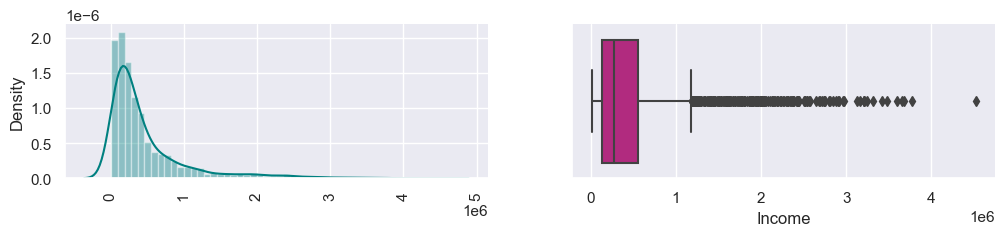

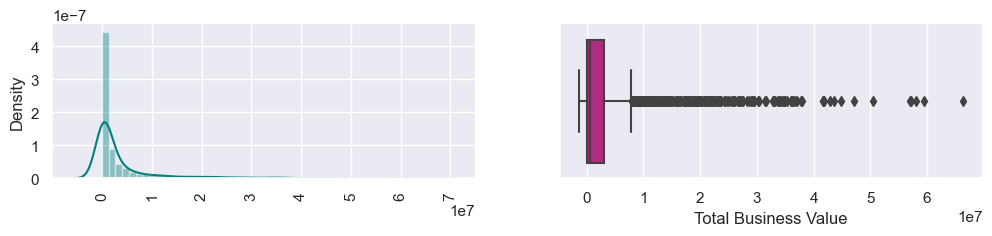

In [81]:
a =df[['Age','Income','Total Business Value']]
for i in a:
    plt.figure(figsize=(12,2))
    plt.subplot(121)
    sns.distplot(x=df[i],color='teal')
    plt.title('')
    plt.xticks(rotation=90)

    plt.subplot(122)
    sns.boxplot(x=df[i],color='mediumvioletred')
    plt.title('')
    sns.despine()
    plt.show()

# 5 Bivariate & Multivariate Analysis

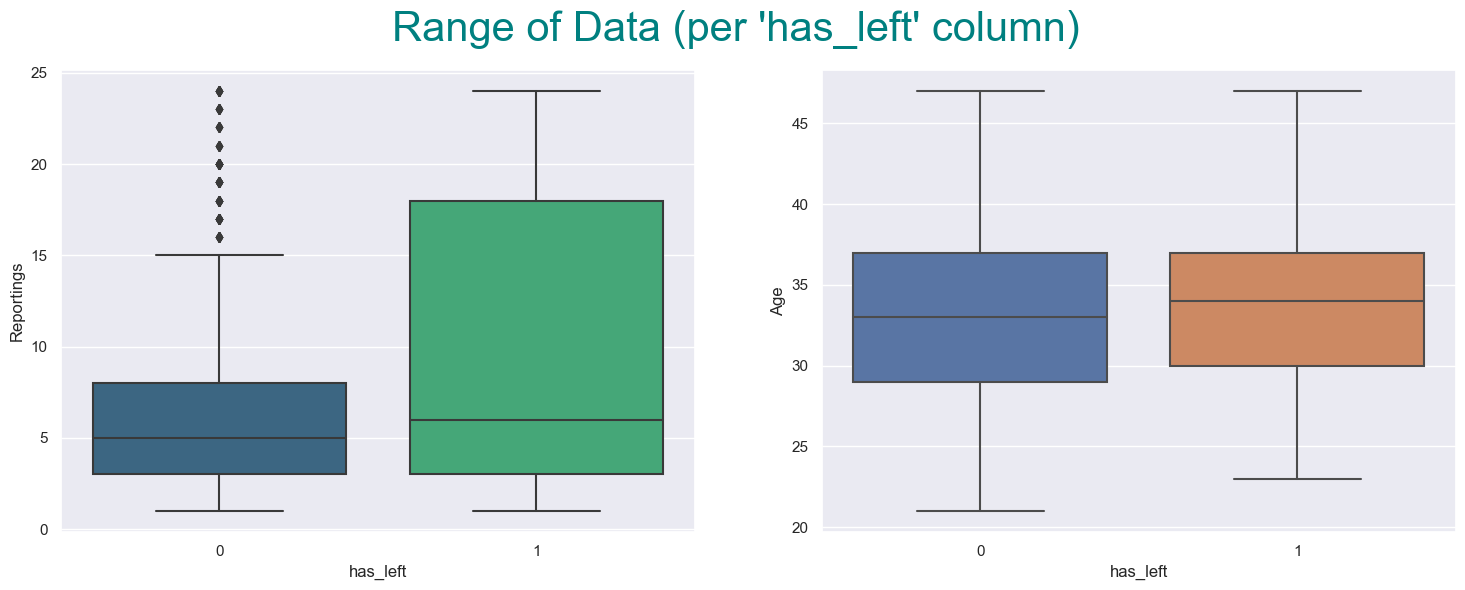

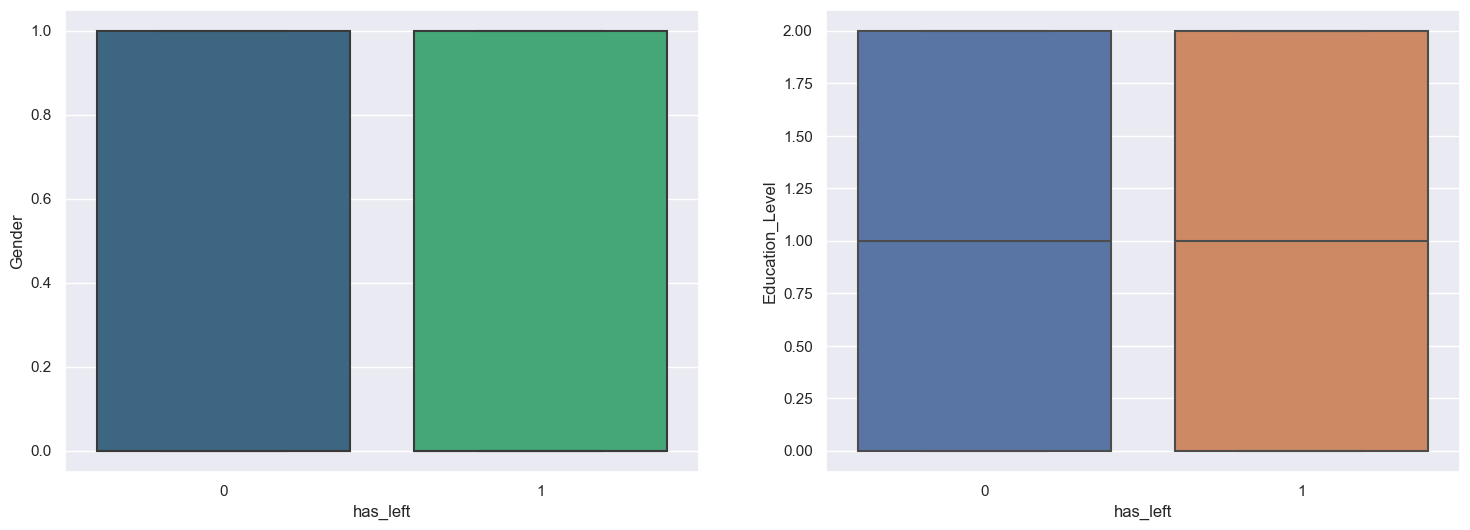

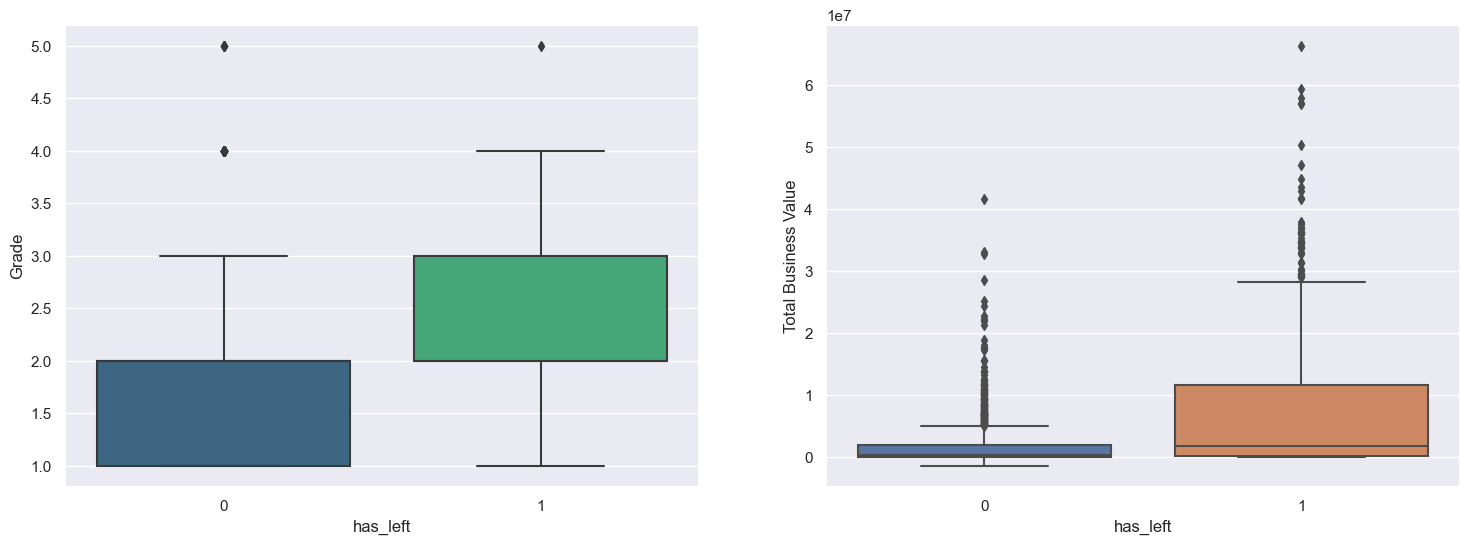

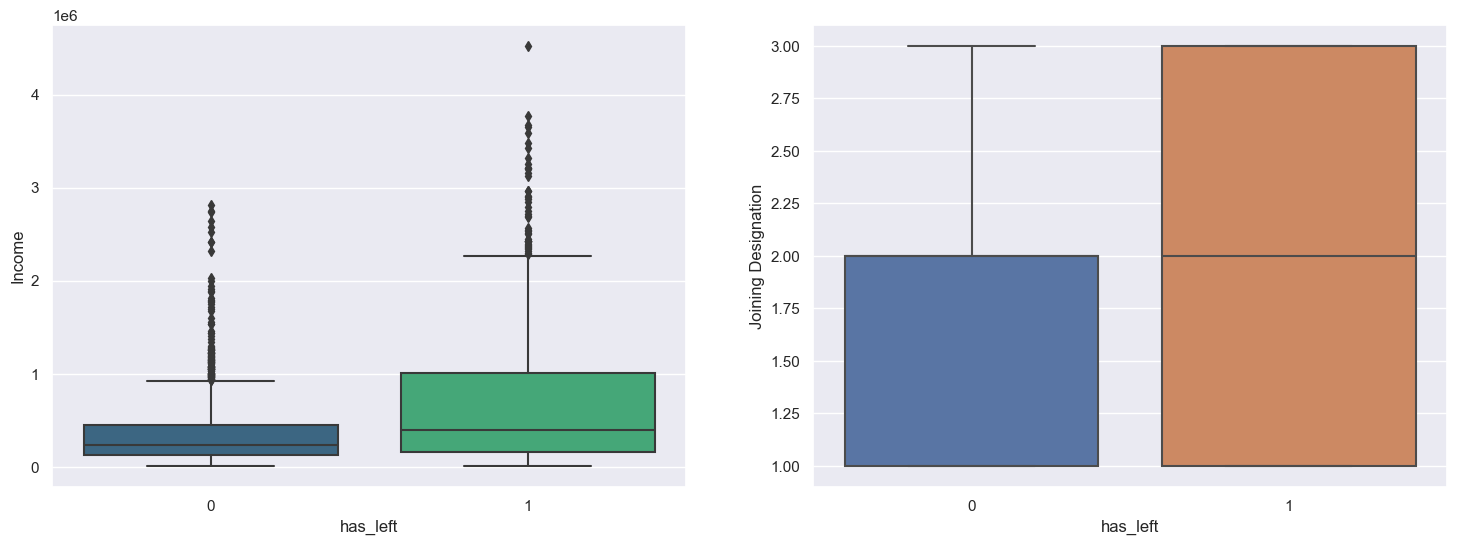

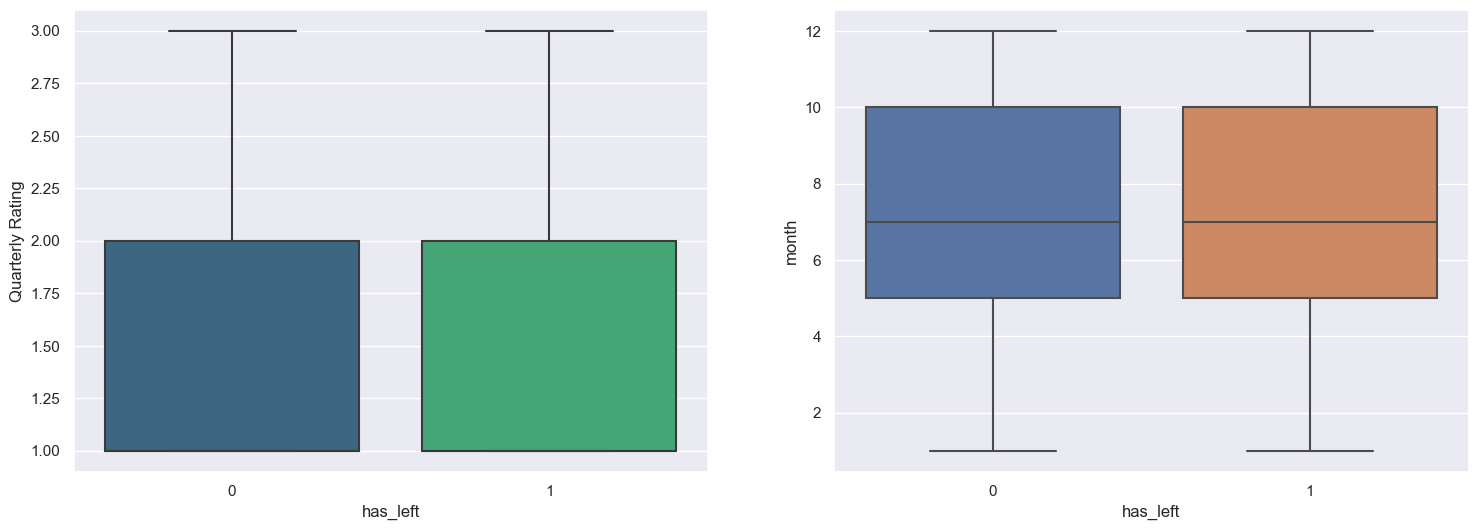

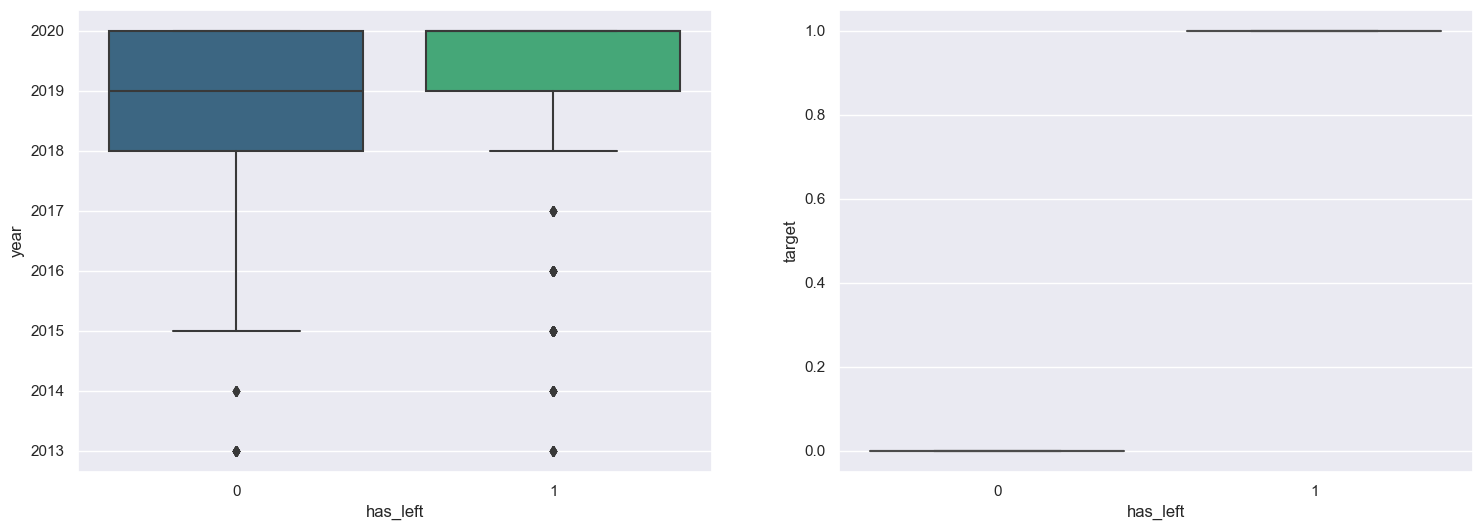

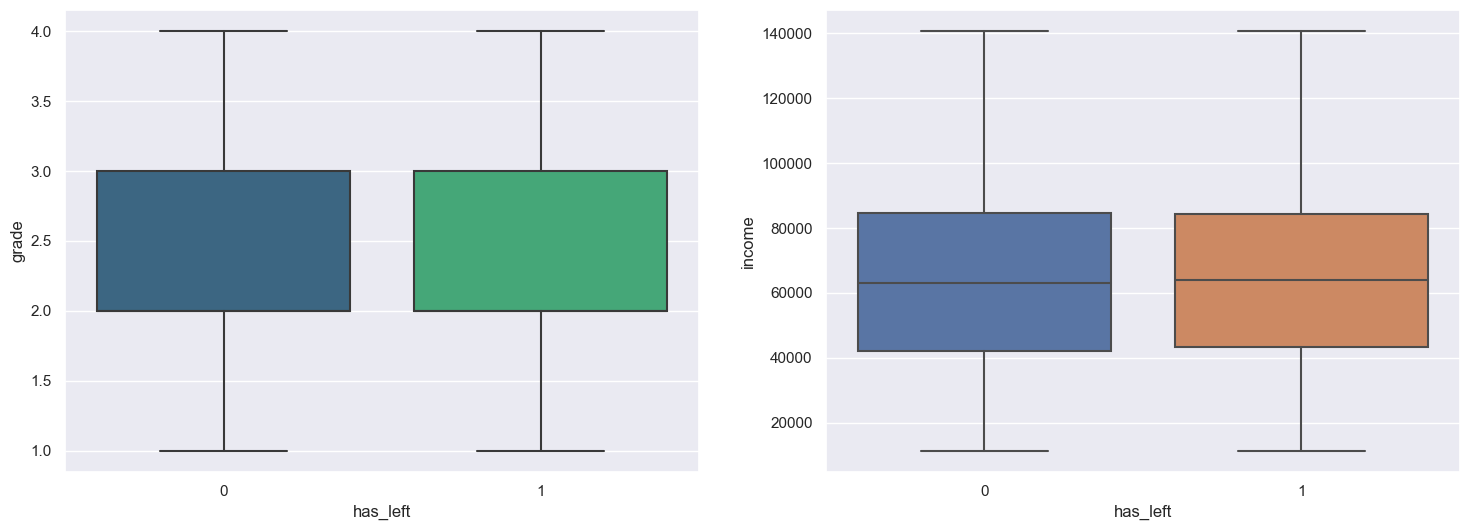

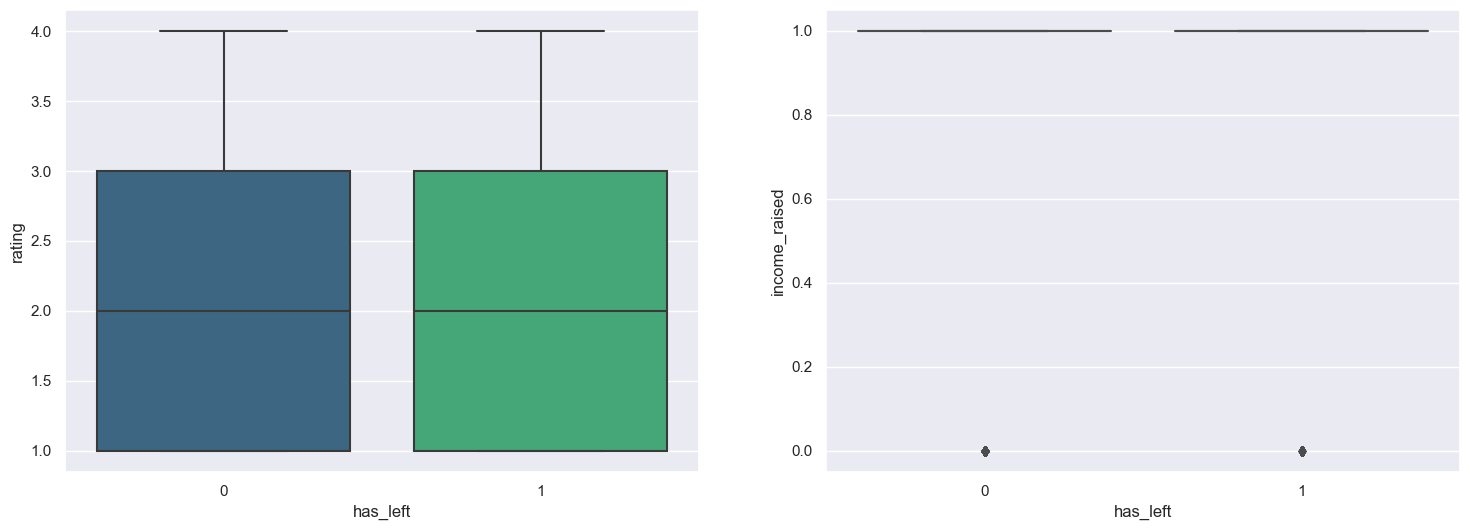

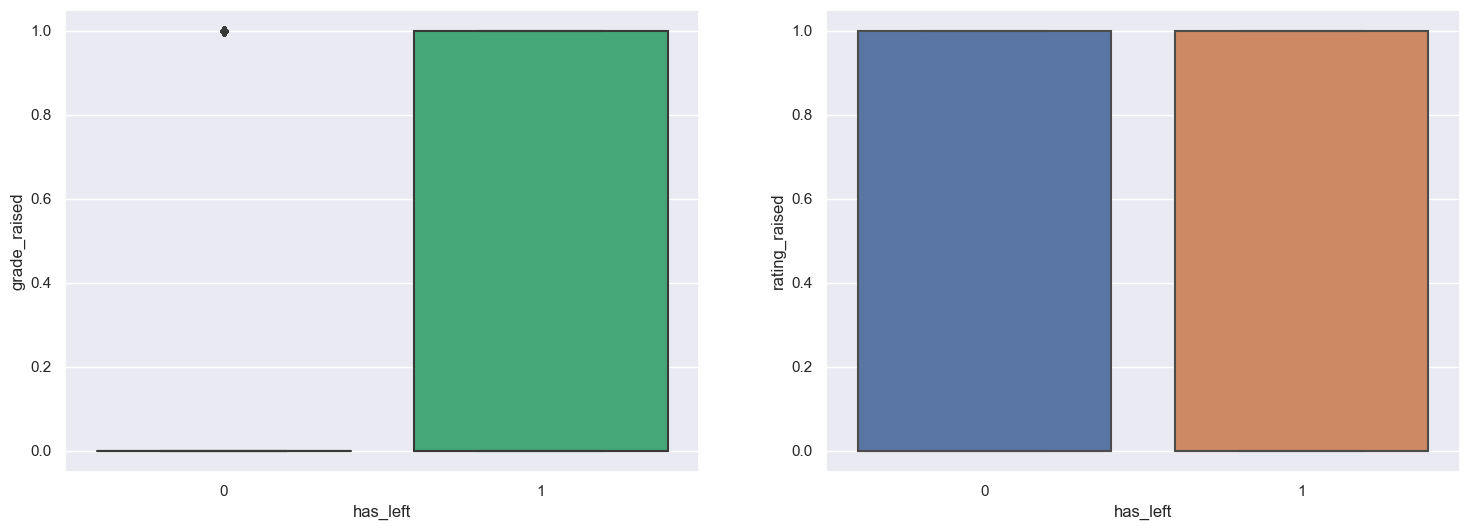

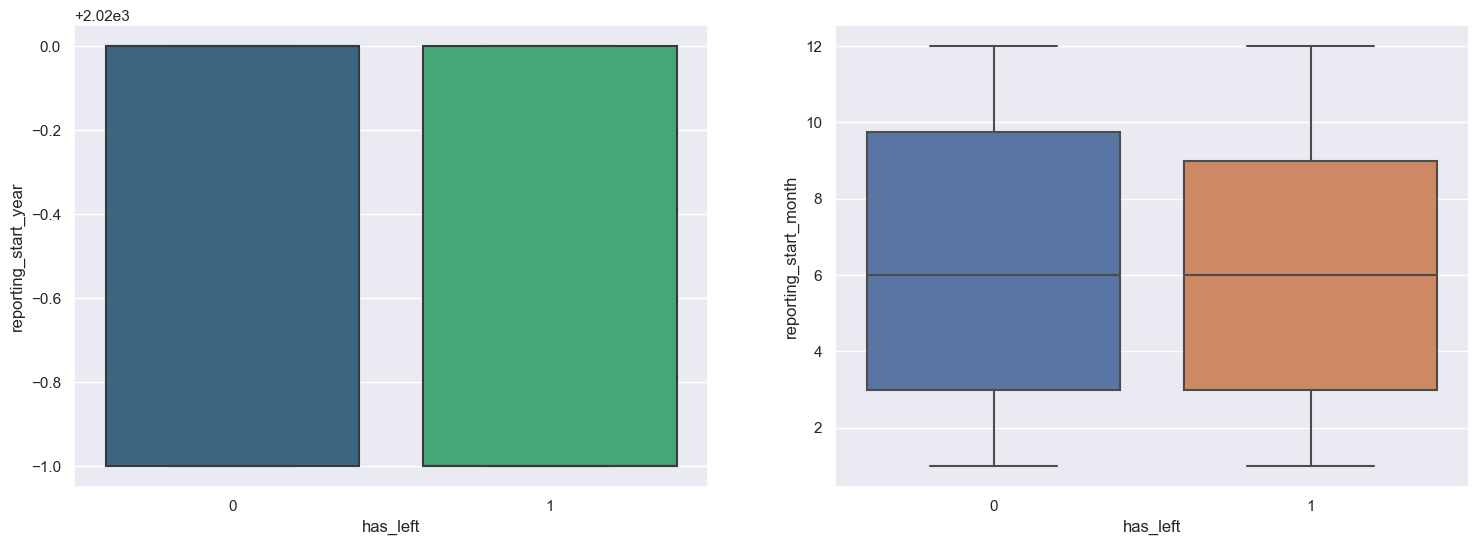

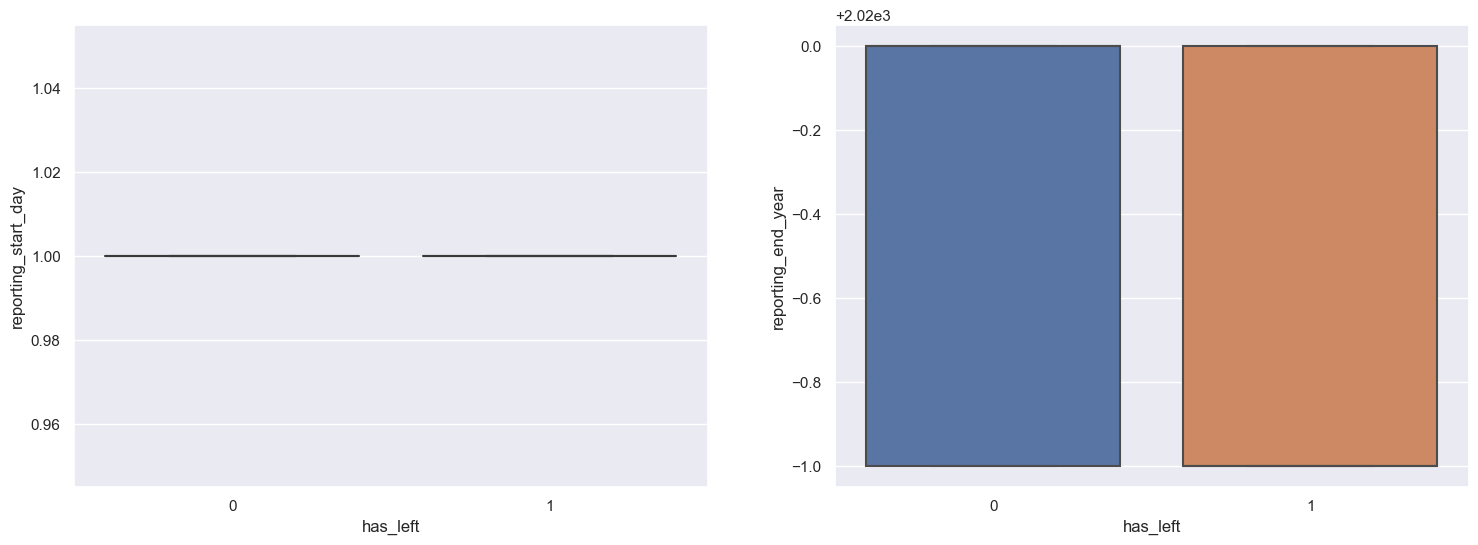

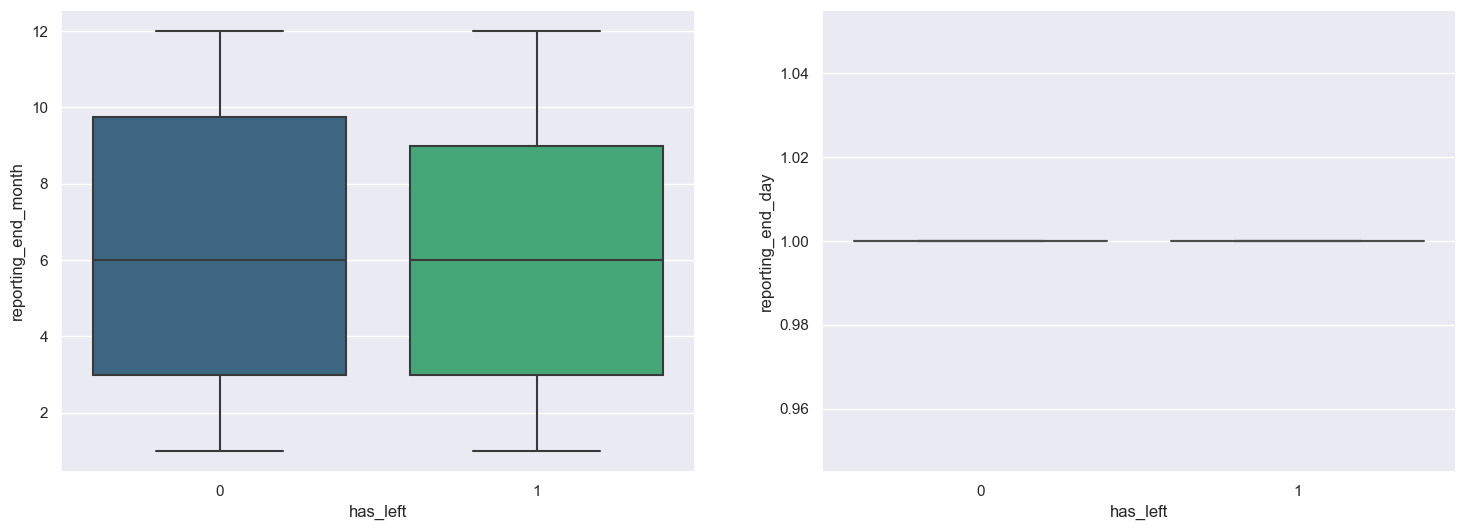

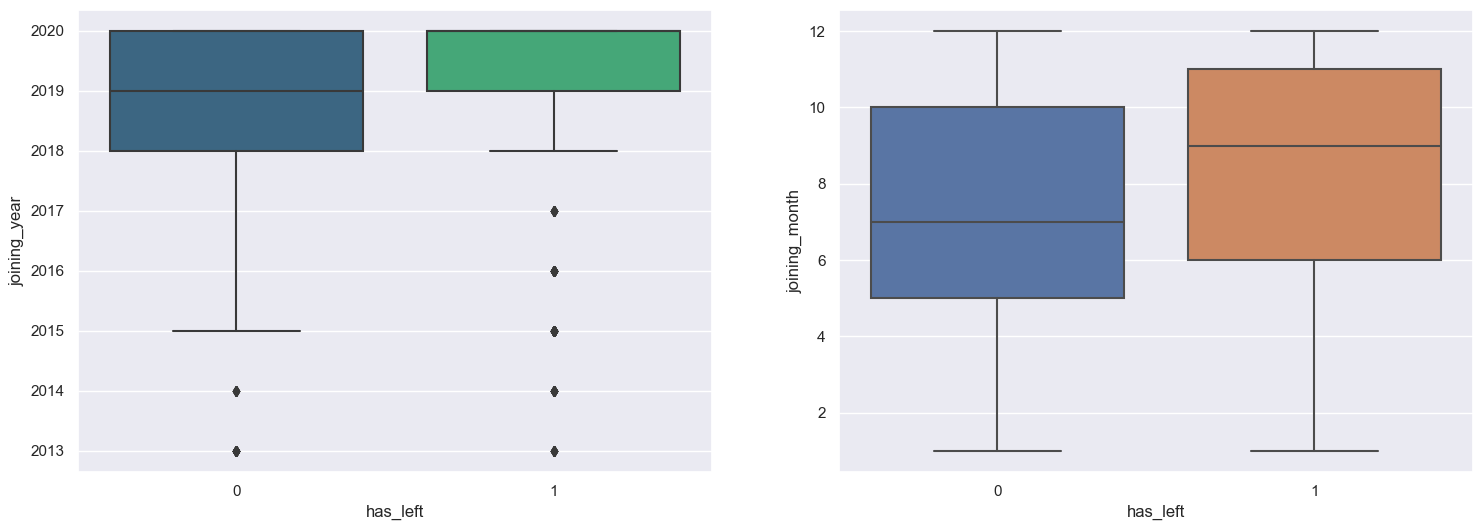

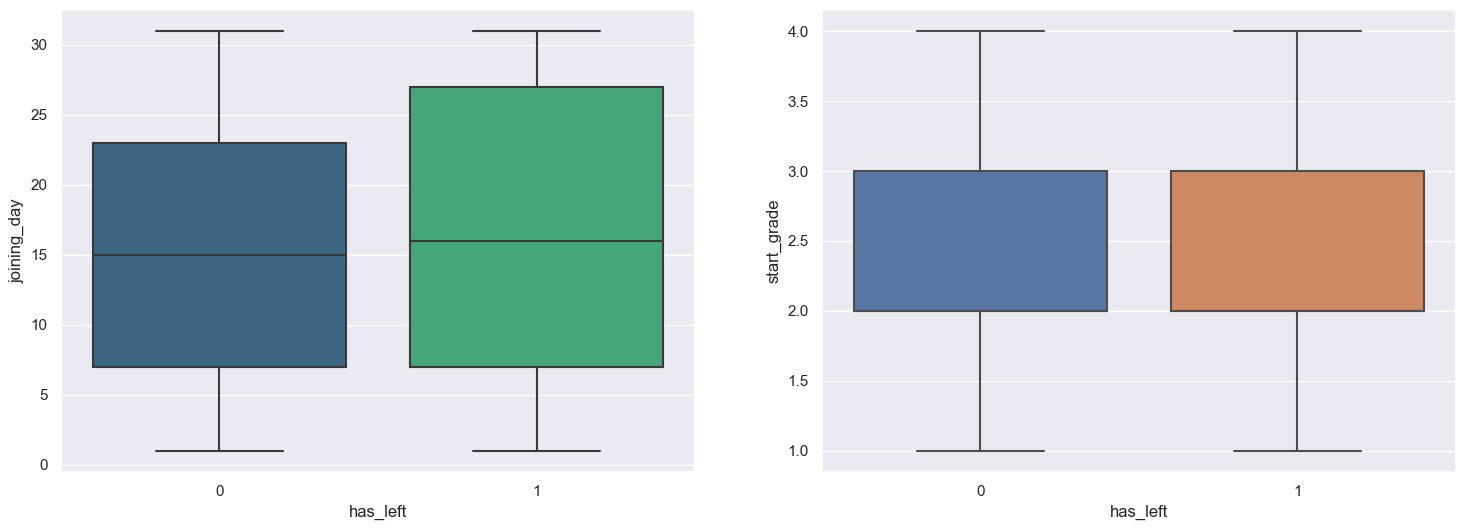

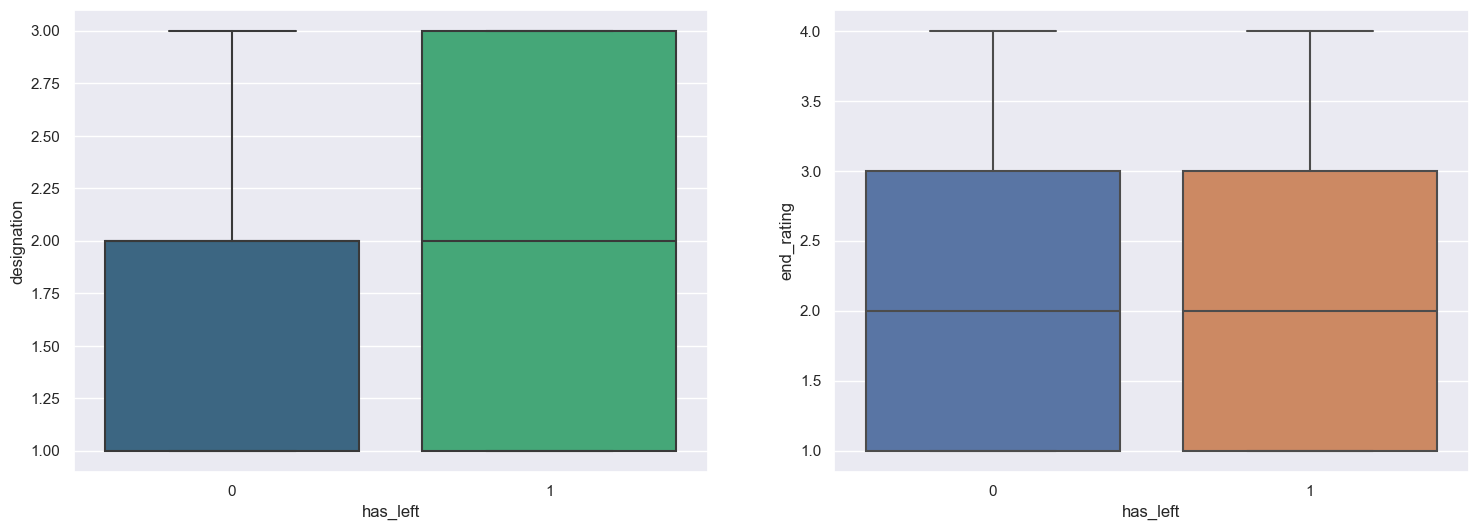

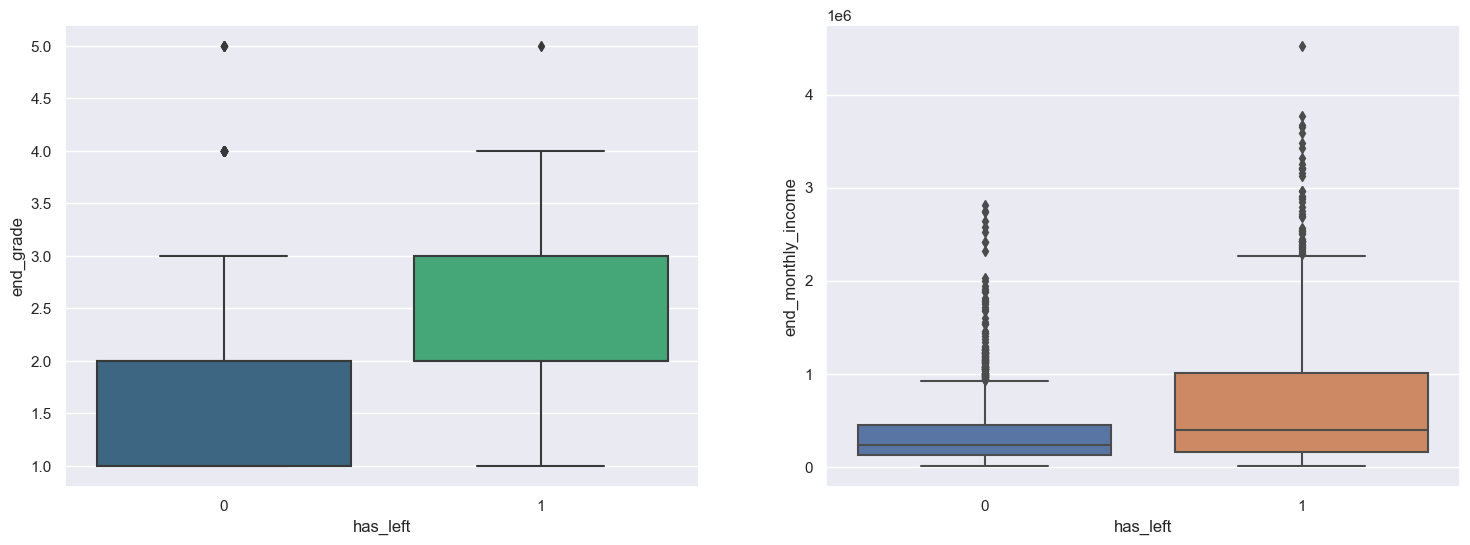

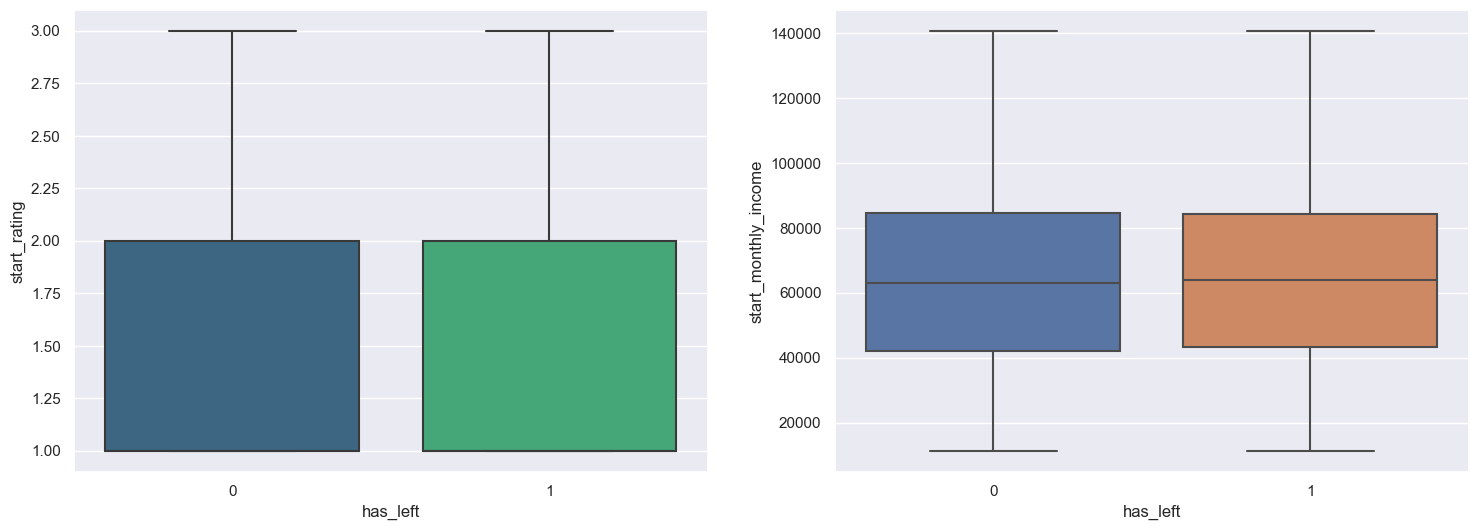

In [82]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="teal")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category, palette='viridis')
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

# 6 Analysis of Correlation Between Data

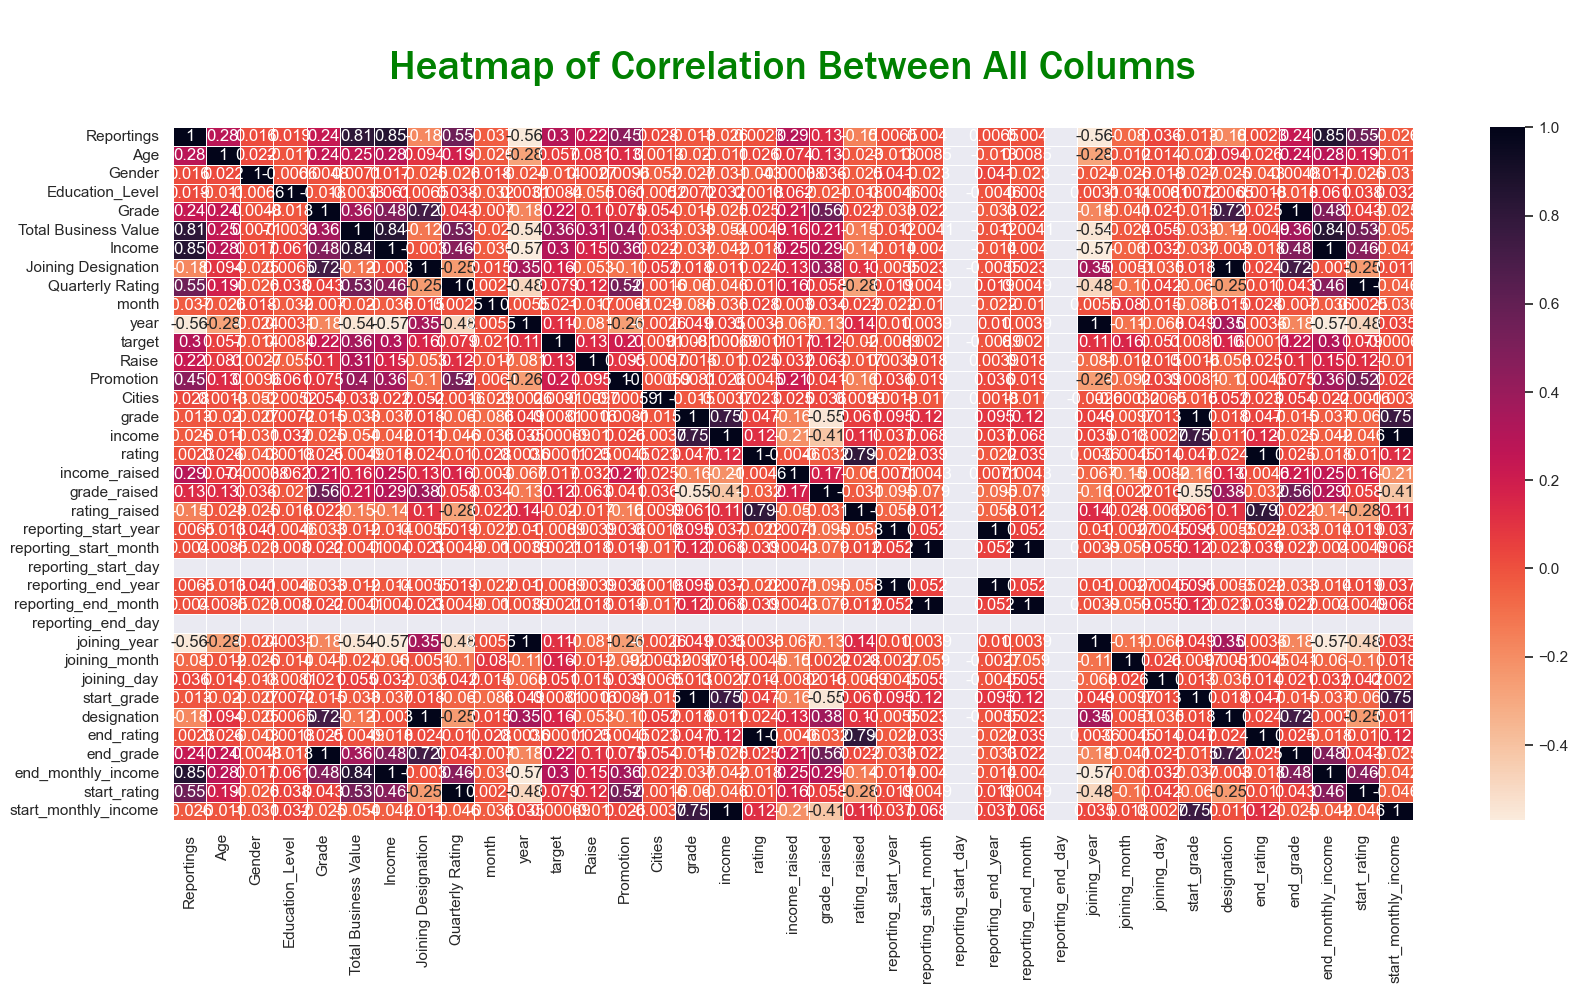

In [83]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n",fontname='Franklin Gothic Medium',fontsize=30, color="green")
plt.show()

1. Since start_grade is highly correlated with end_grade, removing start_grade column.
2. Since start_monthly_income is highly correlated with end_monthly_income, removing start_monthly_income column.
3. Since reporting_start_day and reporting_end_day have only one values, removing both the fields..

In [84]:
df = df.drop(['reporting_start_day', 'reporting_end_day', 'start_monthly_income', 'start_grade'], axis=1)

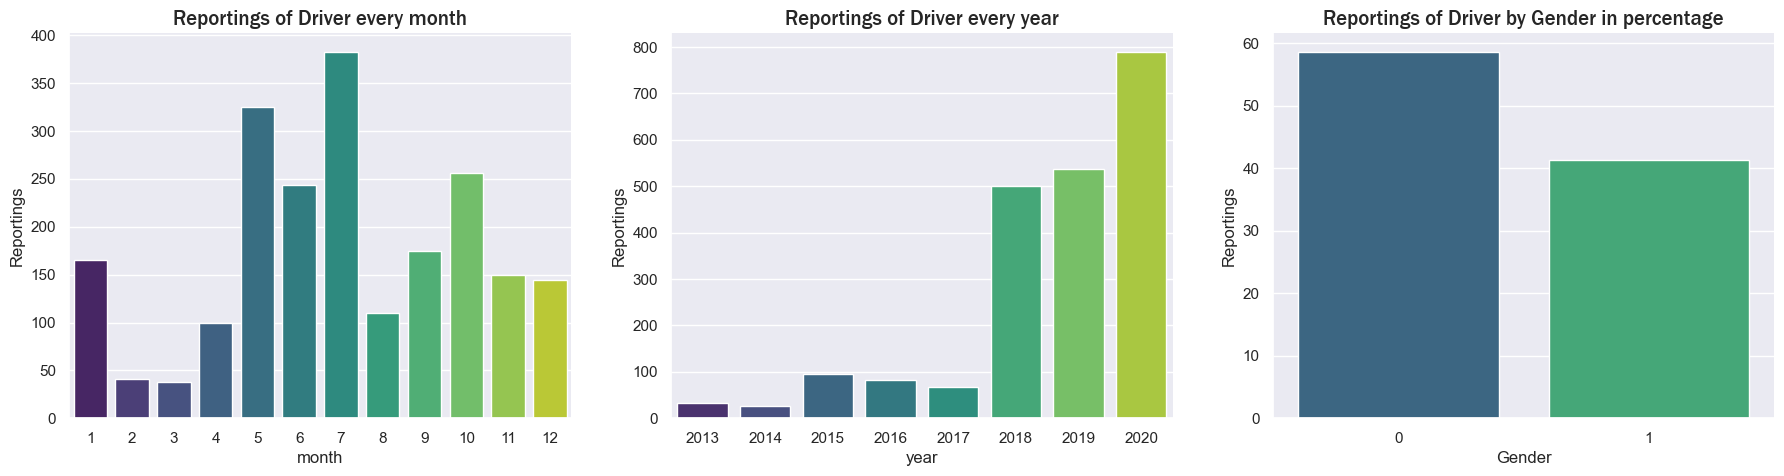

In [85]:
fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(1,3,1)
grouped_months = df.groupby(['month'])['Reportings'].count().reset_index()
sns.barplot(data=grouped_months,x='month',y='Reportings',palette='viridis')
plt.title('Reportings of Driver every month',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,3,2)
grouped_years = df.groupby(['year'])['Reportings'].count().reset_index()
sns.barplot(x='year', y='Reportings', data=grouped_years,palette='viridis')
plt.title('Reportings of Driver every year',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,3,3)
grouped_gender = df.groupby('Gender')['Reportings'].sum().reset_index()
grouped_gender['Reportings'] =(grouped_gender['Reportings']/sum(df.Reportings)*100).round(2)
sns.barplot(x=grouped_gender['Gender'],y= grouped_gender['Reportings'],palette='viridis')
plt.title('Reportings of Driver by Gender in percentage',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
sns.despine()
plt.show()

In [86]:
grouped_gender

Gender  Reportings
0       0       58.66
1       1       41.34

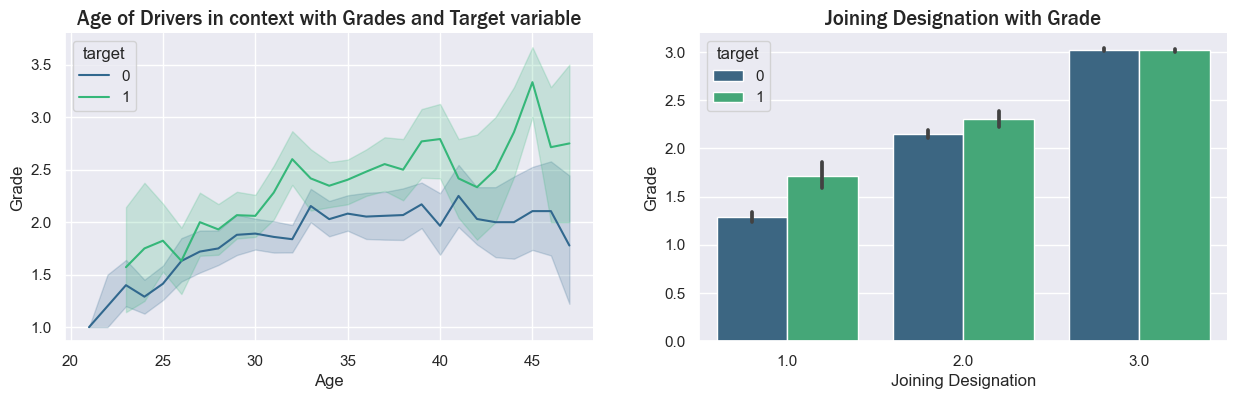

In [87]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
sns.lineplot(x=df.Age,y=df.Grade,hue=df.target,palette='viridis')
plt.title('Age of Drivers in context with Grades and Target variable',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,2,2)
sns.barplot(data=df, x="Joining Designation", y="Grade",palette='viridis',hue='target')
plt.title('Joining Designation with Grade',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

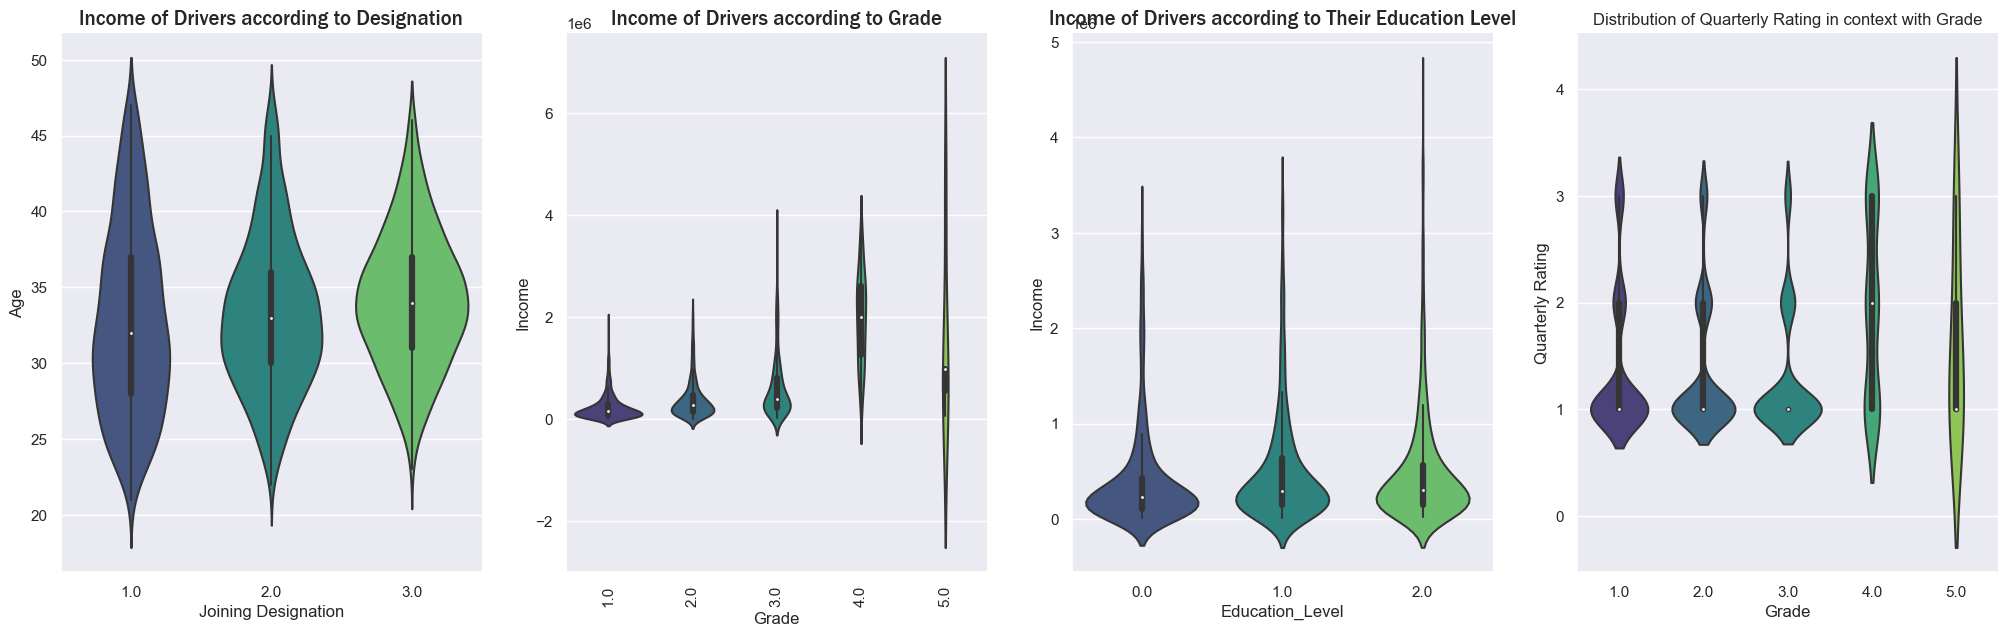

In [88]:
plt.figure(figsize=(25,7))
plt.subplot(1,4,1)
sns.violinplot(y=df.Age,x=df['Joining Designation'],palette='viridis')
plt.title('Income of Drivers according to Designation',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(1,4,2)
sns.violinplot(x=df.Grade,y=df.Income,palette='viridis')
plt.title('Income of Drivers according to Grade',fontname='Franklin Gothic Medium', fontsize=15)
plt.xticks(rotation=90)
plt.subplot(1,4,3)
sns.violinplot(x=df.Education_Level,y=df.Income,palette='viridis')
plt.title('Income of Drivers according to Their Education Level',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(1,4,4)
sns.violinplot(x=df['Grade'],y=df["Quarterly Rating"],palette='viridis')
plt.title('Distribution of Quarterly Rating in context with Grade')
sns.despine()
sns.despine()
plt.show()

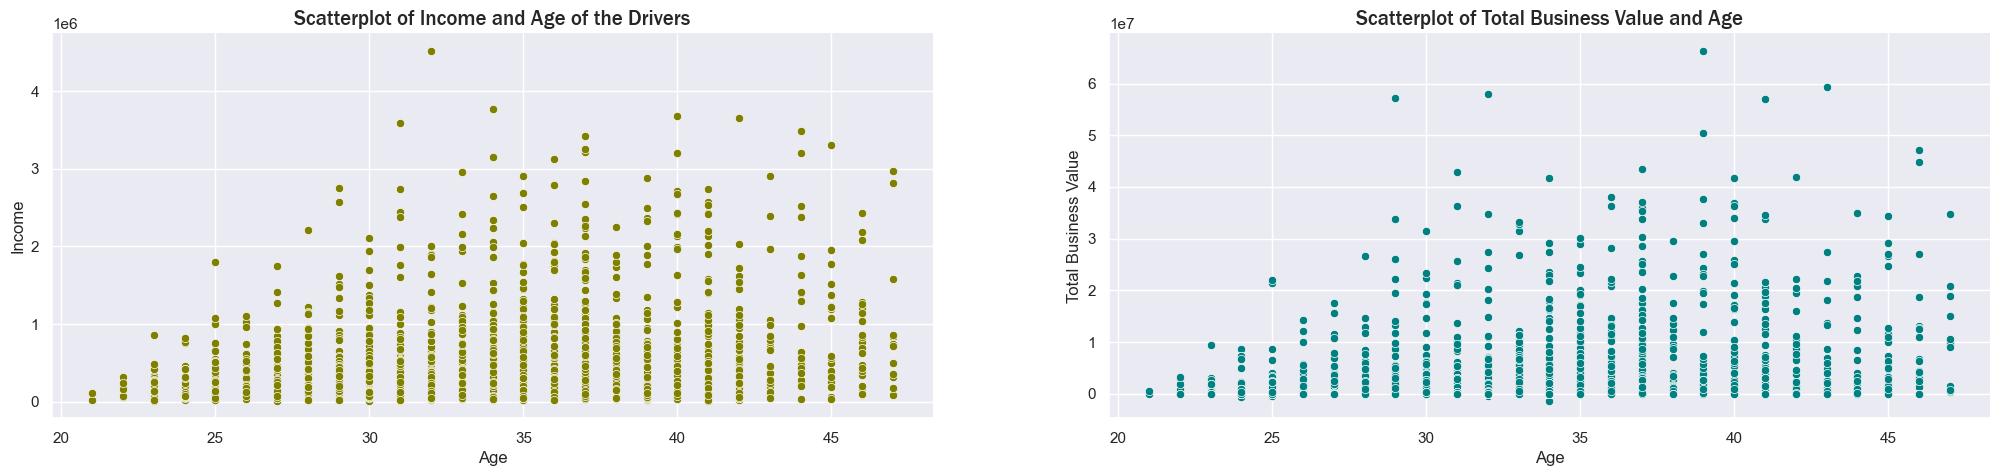

In [89]:
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
sns.scatterplot(x=df.Age,y=df.Income,color='olive')
plt.title('Scatterplot of Income and Age of the Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(1,2,2)
sns.scatterplot(x=df.Age,y=df['Total Business Value'],color='teal')
plt.title('Scatterplot of Total Business Value and Age',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

In [90]:
grouped_gender = df.groupby('Gender')['Income'].sum().reset_index()
grouped_education = df.groupby('Education_Level')['Income'].sum().reset_index()
grouped_grade = df.groupby('Grade')['Income'].sum().reset_index()
grouped_desig = df.groupby('Joining Designation')['Income'].sum().reset_index()
grouped_QR = df.groupby('Quarterly Rating')['Income'].sum().reset_index()
grouped_target = df.groupby('target')['Income'].sum().reset_index()
grouped_raise = df.groupby('Raise')['Income'].sum().reset_index()
grouped_promote = df.groupby('Promotion')['Income'].sum().reset_index()

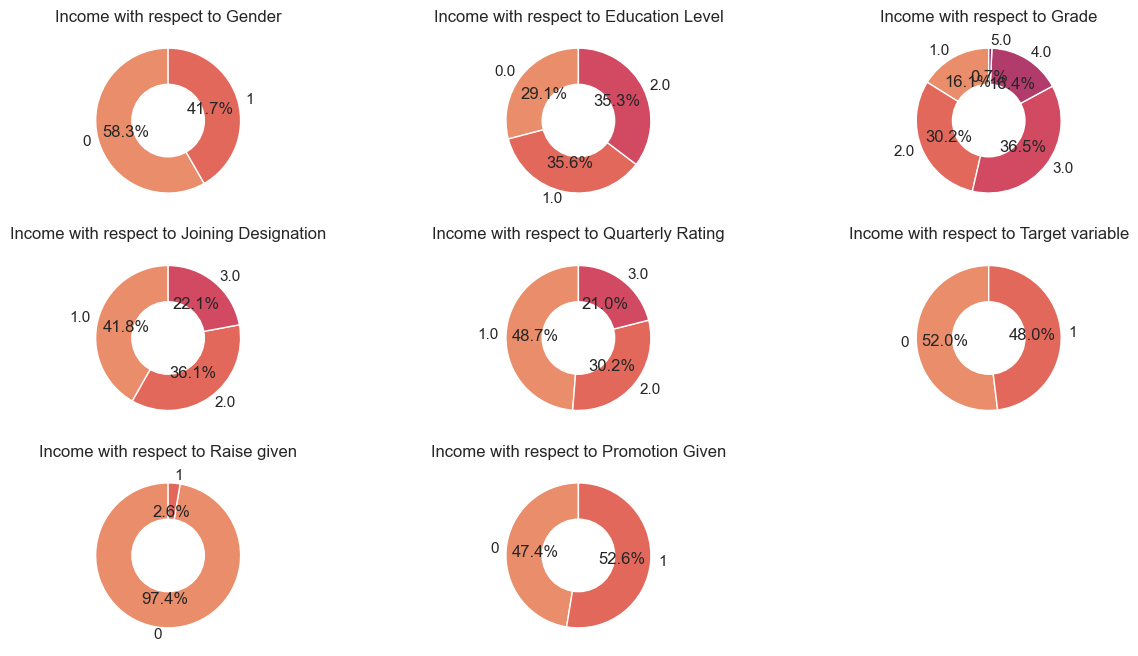

In [91]:
plt.figure(figsize=(15,8))
plt.subplot(3,3,1)
plt.pie(grouped_gender['Income'], labels=grouped_gender['Gender'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Gender')
plt.subplot(3,3,2)
plt.pie(grouped_education['Income'], labels=grouped_education['Education_Level'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Education Level')
plt.subplot(3,3,3)
plt.pie(grouped_grade['Income'], labels=grouped_grade['Grade'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Grade')
plt.subplot(3,3,4)
plt.pie(grouped_desig['Income'], labels=grouped_desig['Joining Designation'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Joining Designation')
plt.subplot(3,3,5)
plt.pie(grouped_QR['Income'], labels=grouped_QR['Quarterly Rating'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Quarterly Rating')
plt.subplot(3,3,6)
plt.pie(grouped_target['Income'], labels=grouped_target['target'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Target variable')
plt.subplot(3,3,7)
plt.pie(grouped_raise['Income'], labels=grouped_raise['Raise'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Raise given')
plt.subplot(3,3,8)
plt.pie(grouped_promote['Income'], labels=grouped_promote['Promotion'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Promotion Given')
sns.despine()
plt.show()

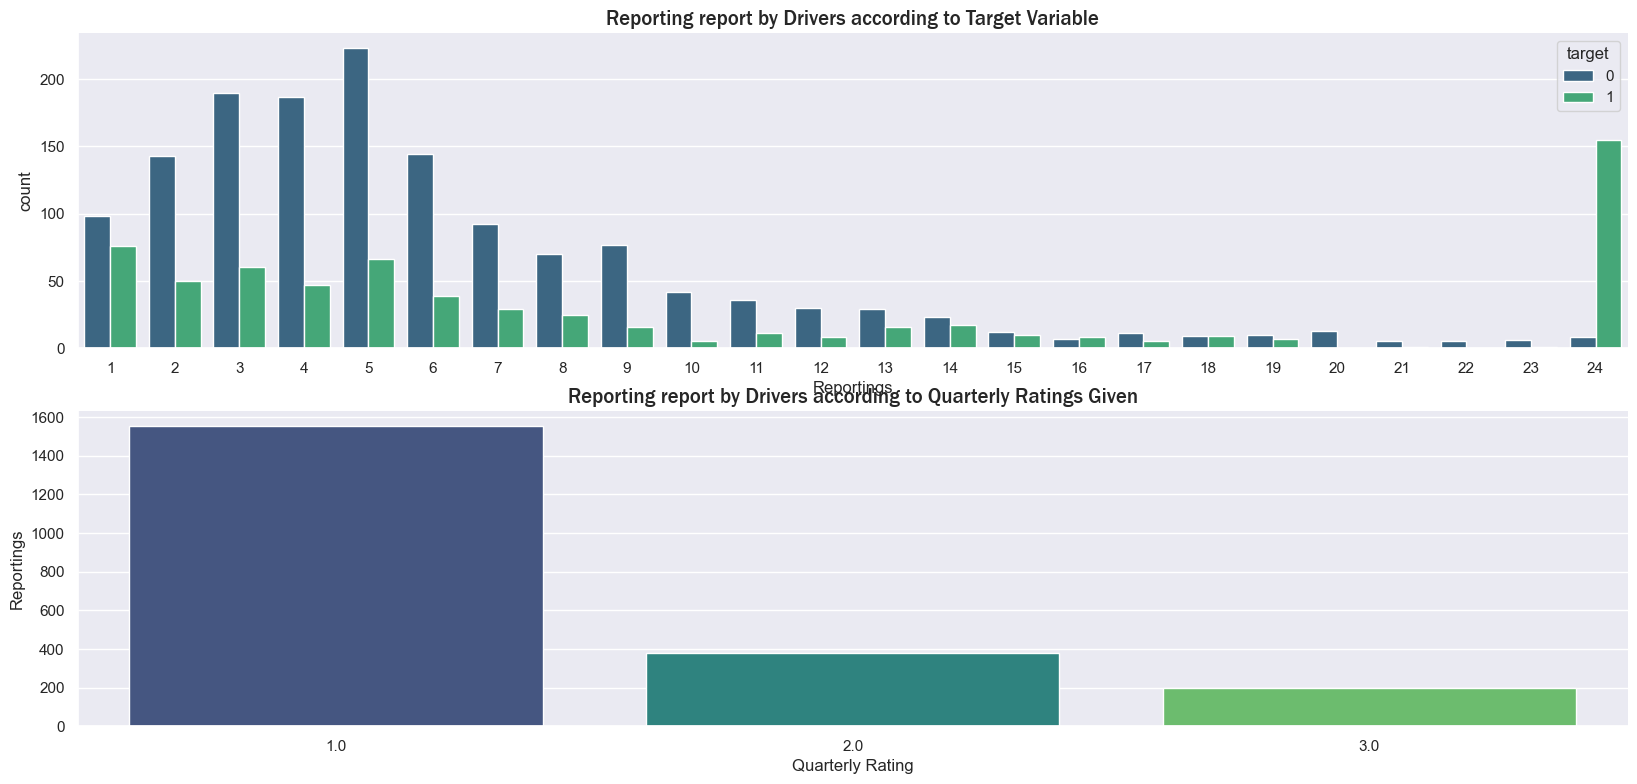

In [92]:
plt.figure(figsize=(20,9))
plt.subplot(2,1,1)
sns.countplot(x=df['Reportings'],hue=df.target,palette='viridis')
plt.title('Reporting report by Drivers according to Target Variable',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(2,1,2)
grouped_rating = df.groupby('Quarterly Rating')['Reportings'].count().reset_index()
sns.barplot(data = grouped_rating,y='Reportings',x='Quarterly Rating',palette='viridis')
plt.title('Reporting report by Drivers according to Quarterly Ratings Given',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

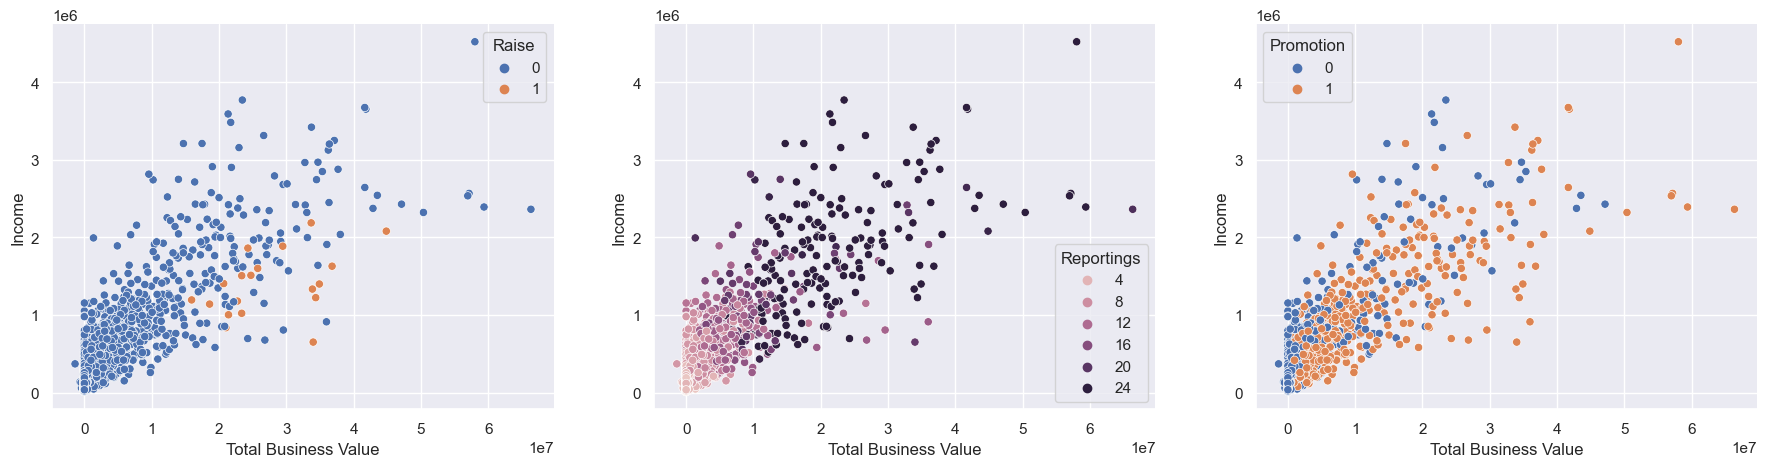

In [93]:
plt.figure(figsize=(22,5))
plt.subplot(1,3,1)
sns.scatterplot(x=df['Total Business Value'],y=df.Income,hue=df.Raise)
plt.subplot(1,3,2)
sns.scatterplot(x=df['Total Business Value'],y=df.Income,hue=df.Reportings)
plt.subplot(1,3,3)
sns.scatterplot(x=df['Total Business Value'],y=df.Income,hue=df.Promotion)
sns.despine()
plt.show()

- There are 57% male employees and 43% female employees.
- The percentages of employees with different education levels are almost same for level 1 & 2.
- 97.3% of the employees who did not get a raise.
- Almost 43% of the employees joined at lowest designation (1). 34% joined at level 2, 20% at level 3 and below 2% joined at higher levels.
- Majority (35%) of the employees currently are at designation level 2, followed by designation level 1 (31%) and 3 (26%). Less than 5% of the employees are currently in higher designations.
- Only 54.6% of the employees received a promotion, while 45.4% did not. However, only 2.6% received a raise in income.
- Number of employees has been increase with increase in year as well as number of reportings.
- The majority of the employees seem to be associated with city C20.
- Scatter plot of Income shows that Income increases with increase in age but after 45-50, we see a subtle decline.
- Scatter plot of Total Business Value shows an increase with increase in Age yet we notice a decline after 45.
- Income decreses with increase in Destination as about 4% of the employees hold higher designations.
- The median of the Income for employees having higher Grades is greater.
- Distribution of Income for enployes at different Education level is about a change of 3-5% with level 0.
- Joining Designation Increases with increase in Grade.
- Max reporting days is 24 days.
- About 55% of the reportings of the employees has got Quarlerly Rating 1.
- Number of reportings increases with increase in Income as well as Total Business Value.

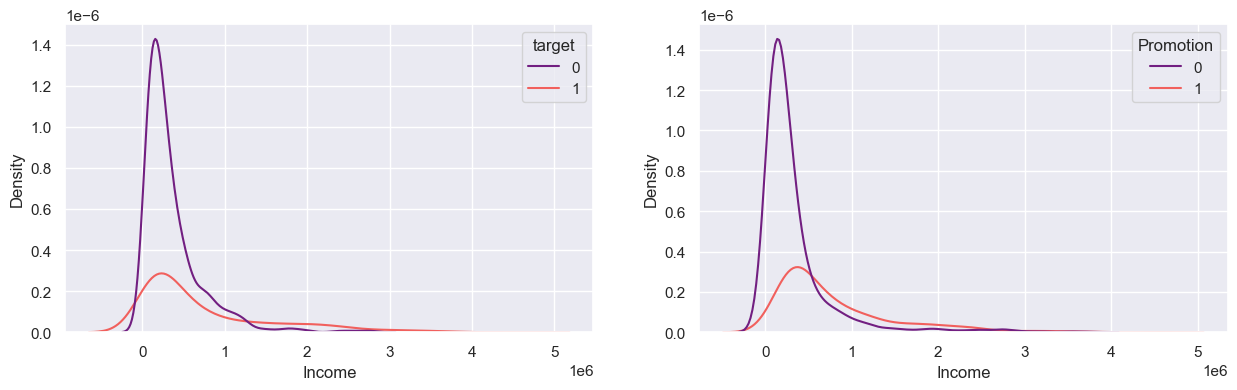

In [94]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.kdeplot(x=df.Income,hue=df['target'],palette='magma')
plt.subplot(1,2,2)
sns.kdeplot(x=df.Income,hue=df['Promotion'],palette='magma')
plt.show()

# 9 Treat Target Variable Imbalance

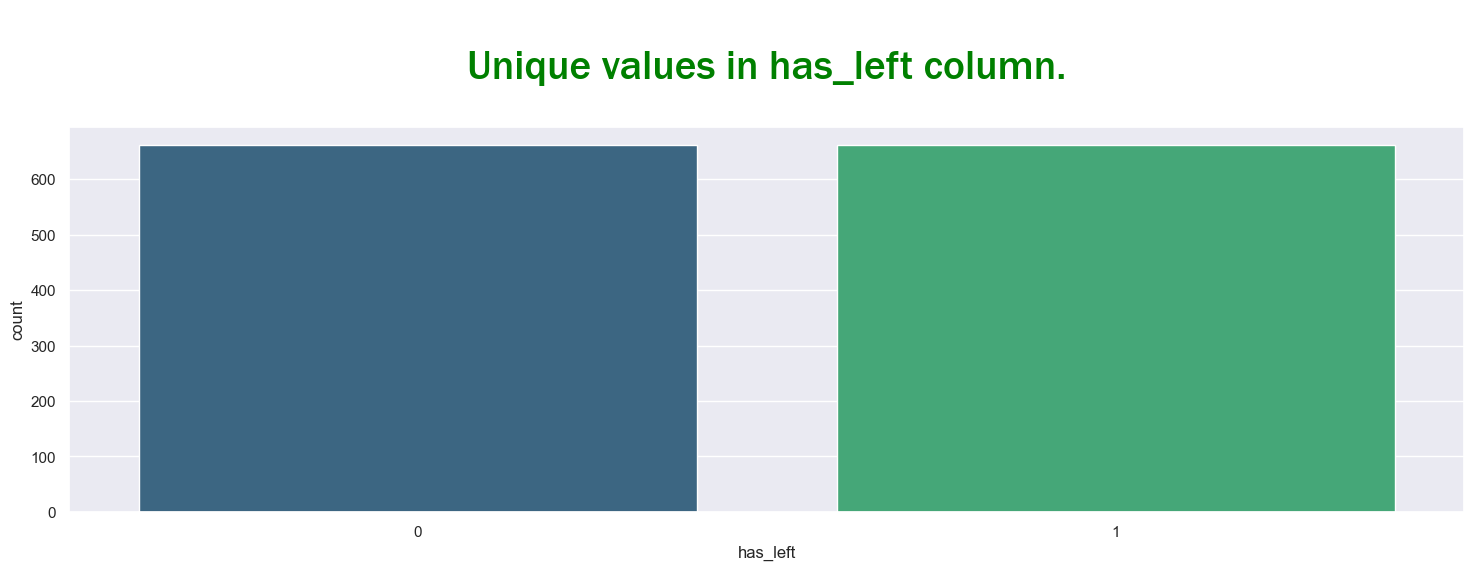

In [96]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_over, y_over = undersample.fit_resample(df.drop('has_left', axis=1), df['has_left'])
df = pd.concat([X_over, y_over], axis=1)
fig, axes = plt.subplots(figsize=(18,5))
sns.countplot(data=df, x='has_left', palette='viridis')
plt.title(f"\nUnique values in has_left column.\n",fontname='Franklin Gothic Medium', fontsize=30, color="green")
plt.show()

# 10 Train-Test Split

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 1771 to 2380
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Reportings             1322 non-null   int64   
 1   Age                    1322 non-null   int64   
 2   Gender                 1322 non-null   int64   
 3   Education_Level        1322 non-null   float64 
 4   Grade                  1322 non-null   float64 
 5   Total Business Value   1322 non-null   float64 
 6   Income                 1322 non-null   float64 
 7   Joining Designation    1322 non-null   float64 
 8   Quarterly Rating       1322 non-null   float64 
 9   month                  1322 non-null   int64   
 10  year                   1322 non-null   int64   
 11  target                 1322 non-null   int64   
 12  Raise                  1322 non-null   int32   
 13  Promotion              1322 non-null   int32   
 14  Cities                 1322 non-null 

In [98]:
df = df.drop(['Joining Designation','month','year','target','Reportings','Promotion','Raise','rating','income'], axis=1)

In [99]:
for category in get_columns_by_types(df, categorical_types):
    df[category] = df[category].astype(int)
for column in get_columns_by_types(df, ['string']):
    df[column] = pd.Categorical(df[column])

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['has_left'], axis=1), df['has_left'], random_state=0, test_size = .2)

# 11 Feature Encoding and Feature Scaling

## 11.1 On Train Data

In [101]:
target_encoder = TargetEncoder(return_df=True)
X_train = target_encoder.fit_transform(X_train, y_train)

In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057 entries, 2040 to 85
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1057 non-null   int64  
 1   Gender                 1057 non-null   int64  
 2   Education_Level        1057 non-null   float64
 3   Grade                  1057 non-null   float64
 4   Total Business Value   1057 non-null   float64
 5   Income                 1057 non-null   float64
 6   Quarterly Rating       1057 non-null   float64
 7   Cities                 1057 non-null   int32  
 8   grade                  1057 non-null   int64  
 9   income_raised          1057 non-null   int64  
 10  grade_raised           1057 non-null   int64  
 11  rating_raised          1057 non-null   int64  
 12  reporting_start_year   1057 non-null   int64  
 13  reporting_start_month  1057 non-null   int64  
 14  reporting_end_year     1057 non-null   int64  
 15  rep

In [103]:
X_train_columns=X_train.columns
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_train=pd.DataFrame(X_train_std, columns=X_train_columns)
X_train.head()

Age    Gender  Education_Level     Grade  Total Business Value    Income  Quarterly Rating    Cities     grade  income_raised  grade_raised  rating_raised  reporting_start_year  reporting_start_month  reporting_end_year  reporting_end_month  joining_year  joining_month  joining_day  designation  end_rating  end_grade  end_monthly_income  start_rating
0  0.086239 -0.842826         1.181908 -0.172884             -0.533337 -0.257444         -0.596172  1.273749 -0.290889       0.317871     -0.676706       1.124003              0.993399               1.620281            0.993399             1.620281      0.773237      -0.516253     0.535725     0.161290    1.985730  -0.172884           -0.257444     -0.596172
1 -1.234846 -0.842826         1.181908 -1.307906             -0.533337 -0.731789         -0.596172 -0.739799  1.866793      -3.145935     -0.676706      -0.889677              0.993399               0.758505            0.993399             0.758505      0.773237       1.147405     1.278433    -1.110973   -0.890812  -1.307906           -0.731789     -0.596172
2 -0.668666 -0.842826        -1.274880  0.962138             -0.500937 -0.432572         -0.596172  0.444641 -1.369730       0.317871      1.477747       1.124003              0.993399              -1.252307            0.993399            -1.252307      0.773237       0.481941    -0.100881     1.433552    1.026883   0.962138           -0.432572     -0.596172
3  0.652418 -0.842826        -0.046486 -1.307906             -0.400542 -0.338044         -0.596172 -1.450463 -0.290889       0.317871     -0.676706       1.124003             -1.006645               0.471246           -1.006645             0.471246      0.773237      -0.516253    -0.419185    -1.110973    1.026883  -1.307906           -0.338044     -0.596172
4 -0.291214 -0.842826         1.181908  0.962138             -0.004143  0.033876         -0.596172 -1.095131  0.787952       0.317871     -0.676706       1.124003              0.993399              -0.390531            0.993399            -0.390531      0.773237      -0.848985     1.596736     1.433552    1.985730   0.962138            0.033876     -0.596172

In [104]:
X_train.shape, y_train.shape

((1057, 24), (1057,))

## 11.2 On Train Data

In [105]:
X_test = target_encoder.transform(X_test)

In [106]:
X_test_columns=X_test.columns
X_test_std=std.transform(X_test)
X_test=pd.DataFrame(X_test_std, columns=X_test_columns)

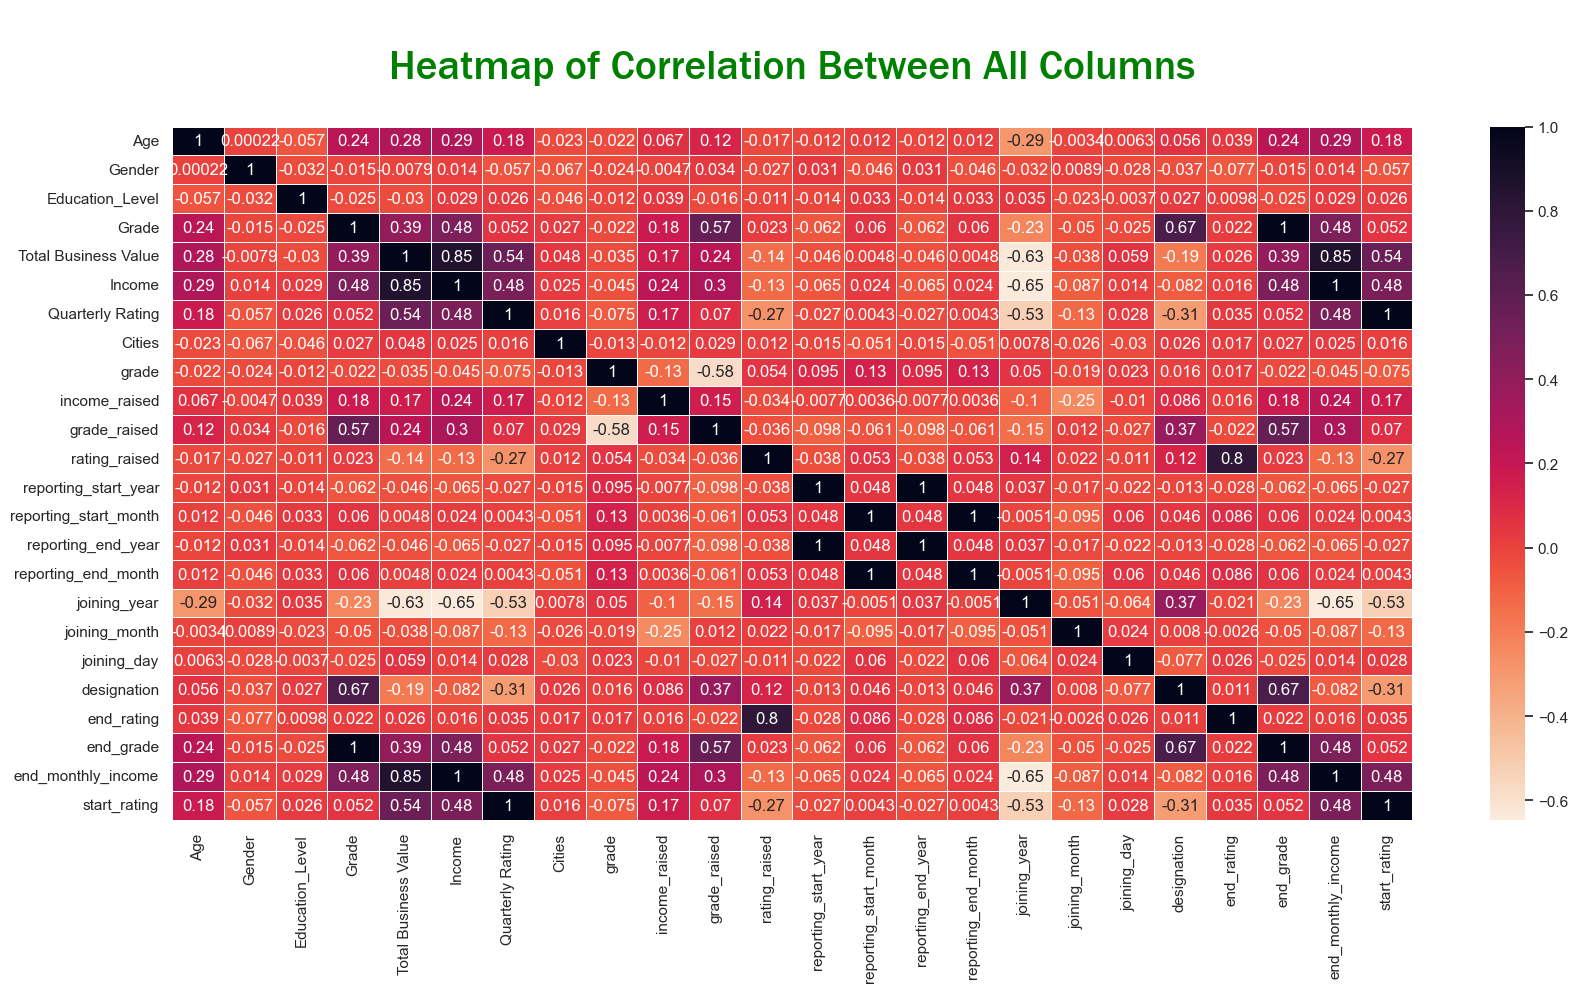

In [107]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(X_train.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n",fontname='Franklin Gothic Medium', fontsize=30, color="green")
plt.show()

# 12 Bagging - Random Forest

## 12.1 Hyperparameter Tuning

In [108]:
params = {
          'n_estimators' : [5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
          'max_depth' : [1, 2, 3, 4, 5,10, 15, 20, 40],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [2, 4, 6, 8, 10, 15, 20]
         }

In [109]:
tuning_function = GridSearchCV(estimator = RandomForestClassifier(), 
                               param_grid = params,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs=-1
                               )

In [110]:
tuning_function.fit(X_train, y_train)

parameters = tuning_function.best_params_
score = tuning_function.best_score_
print(parameters)
print(score)  

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 20, 'n_estimators': 20}
0.8940466992874924


## 12.2 Threefold Cross Validation

In [111]:
tree_clf = RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini', max_depth=10, max_features=4, n_estimators=50)
kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(tree_clf, X_train, y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)

print(f"K-Fold Accuracy Mean: Train: {cv_acc_results['train_score'].mean()*100} Validation: {cv_acc_results['test_score'].mean()*100}")
print(f"K-Fold Accuracy Std: Train: {cv_acc_results['train_score'].std()*100} Validation: {cv_acc_results['test_score'].std()*100}")

K-Fold Accuracy Mean: Train: 99.7687418816107 Validation: 88.36118598382751
K-Fold Accuracy Std: Train: 0.1030099927056933 Validation: 2.3240976674779117


## 12.3 Training the model on best hyperparameters

In [112]:
tree_clf = RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini', max_depth=10, max_features=4, n_estimators=50)

In [113]:
tree_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features=4,
                       n_estimators=50, random_state=7)

## 12.4 Confusion Matrix

In [114]:
X1_train,y1_train = X_train,y_train
X1_test,y1_test = X_test,y_test

In [115]:
RF = RandomForestClassifier(n_estimators=100,
    criterion='entropy',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight="balanced",
    ccp_alpha=0.0085,
    max_samples=None,)

In [116]:
RF.fit(X1_train,y1_train)

RandomForestClassifier(ccp_alpha=0.0085, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt')

In [117]:
RF.score(X1_train,y1_train),RF.score(X1_test,y1_test)

(0.9271523178807947, 0.9320754716981132)

In [118]:
RF.feature_importances_

array([0.02168941, 0.00281397, 0.00432513, 0.02135692, 0.20576762,
       0.11136831, 0.00904488, 0.01587386, 0.00479959, 0.00394543,
       0.00318692, 0.00086718, 0.00168416, 0.00927269, 0.00230304,
       0.0080238 , 0.26730199, 0.12353998, 0.0248364 , 0.02282718,
       0.00373657, 0.01433519, 0.10418595, 0.01291384])

In [119]:
confusion_matrix(y1_test,RF.predict(X1_test) )

array([[116,  11],
       [  7, 131]], dtype=int64)

In [120]:
confusion_matrix(y1_train,RF.predict(X1_train) )

array([[481,  53],
       [ 24, 499]], dtype=int64)

## 12.5 Model Accuracy and Classification Report on Test Data

In [121]:
tree_clf.score(X_test, y_test)

0.9245283018867925

In [122]:
print(classification_report(y_test, tree_clf.predict(X_test), target_names=['Not left', 'Left']))

              precision    recall  f1-score   support

    Not left       0.93      0.91      0.92       127
        Left       0.92      0.93      0.93       138

    accuracy                           0.92       265
   macro avg       0.92      0.92      0.92       265
weighted avg       0.92      0.92      0.92       265



## 12.6 Precision Recall Curve

In [123]:
y_score = tree_clf.predict_proba(X_test)[:, 1]

In [124]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

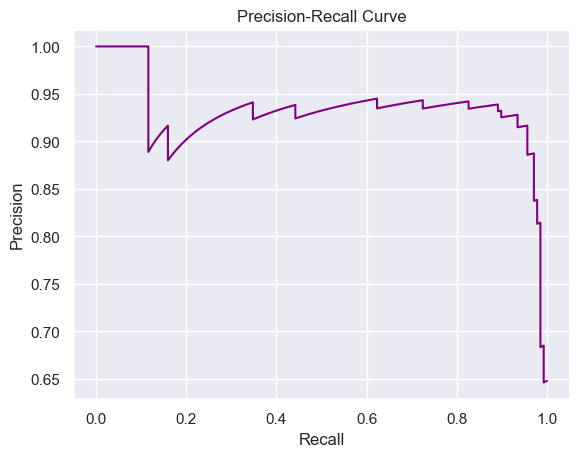

In [125]:
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [126]:
print(f"Area under precision Recall curve is {auc(recall, precision)}")

Area under precision Recall curve is 0.9317094113196176


## 12.7 ROC AUC Curve

In [127]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

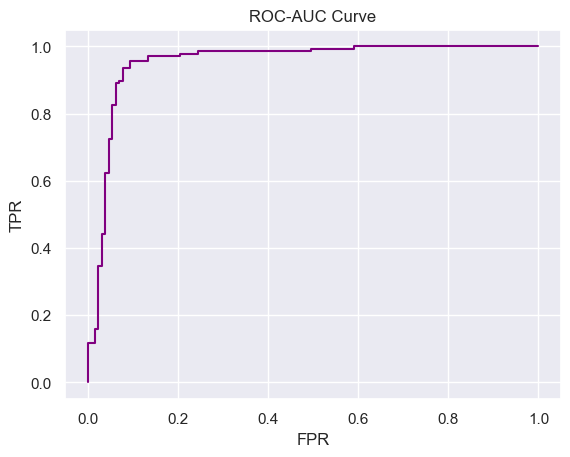

In [128]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='purple')
ax.set_title('ROC-AUC Curve')
ax.set_ylabel('TPR')
ax.set_xlabel('FPR')
plt.show()

In [129]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.9517859180645898


## 12.8 Accuracy Threshold Curve

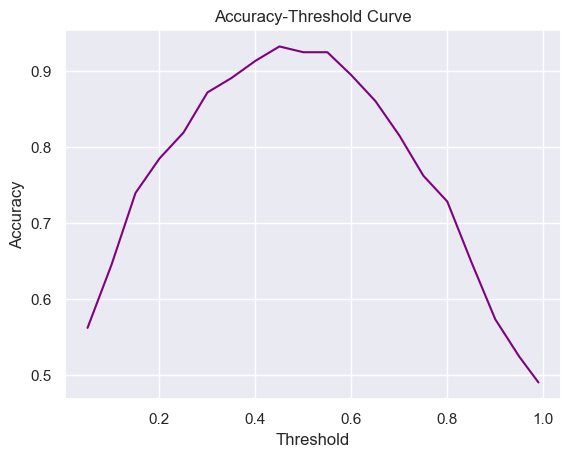

In [130]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [round((y_pred == y_test).sum()/y_pred.shape[0], 4)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('Accuracy-Threshold Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
plt.show()

In [131]:
np.max(scores), np.argmax(scores)

(0.9321, 8)

In [132]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.45


## 12.9 F1-Score Threshold Curve

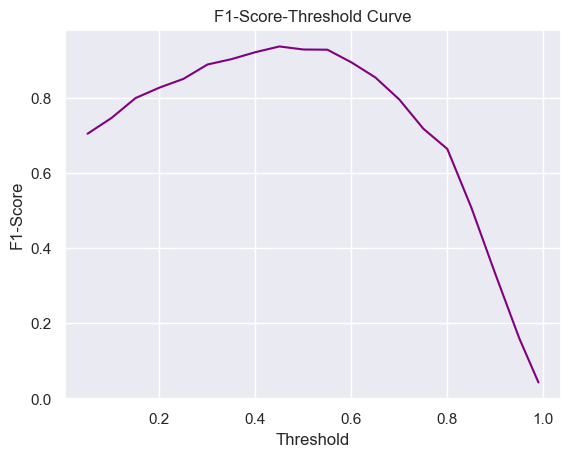

In [133]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [f1_score(y_test, y_pred)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('F1-Score-Threshold Curve')
ax.set_ylabel('F1-Score')
ax.set_xlabel('Threshold')
plt.show()

In [134]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.9517859180645898


In [135]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.45


## 12.10 Feature Importance

# 13 Boosting - GBDT

## 13.1 Hyperparameter Tuning

In [136]:
importances = tree_clf.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

joining_year             0.198700
Total Business Value     0.179921
Income                   0.122847
joining_month            0.111600
end_monthly_income       0.089110
joining_day              0.034501
Age                      0.034221
Cities                   0.032221
Grade                    0.022345
end_grade                0.021636
reporting_end_month      0.019456
reporting_start_month    0.019156
designation              0.017505
start_rating             0.013627
Quarterly Rating         0.013190
grade                    0.012608
Education_Level          0.012130
end_rating               0.011918
Gender                   0.008343
grade_raised             0.006593
rating_raised            0.005202
reporting_start_year     0.005167
reporting_end_year       0.004557
income_raised            0.003444
dtype: float64

In [137]:
params = {
          'n_estimators' : [5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
          'max_depth' : [1, 2, 3, 4, 5,10, 15, 20, 40],
          'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
         }

In [138]:
tuning_function = GridSearchCV(estimator = GradientBoostingClassifier(), 
                               param_grid = params,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs=-1
                               )

In [139]:
tuning_function.fit(X_train, y_train)

parameters = tuning_function.best_params_
score = tuning_function.best_score_
print(parameters)
print(score)  

{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 400}
0.8940440166537901


## 13.2 Threefold Cross Validation

In [140]:
gbdt_clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=4, random_state=0)
kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(gbdt_clf, X_train, y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)

print(f"K-Fold Accuracy Mean: Train: {cv_acc_results['train_score'].mean()*100} Validation: {cv_acc_results['test_score'].mean()*100}")
print(f"K-Fold Accuracy Std: Train: {cv_acc_results['train_score'].std()*100} Validation: {cv_acc_results['test_score'].std()*100}")

K-Fold Accuracy Mean: Train: 93.20923795385661 Validation: 89.68194070080864
K-Fold Accuracy Std: Train: 0.32065452108711084 Validation: 2.078267138006796


## 13.3 Training the model on best hyperparameters

In [141]:
gbdt_clf = GradientBoostingClassifier(n_estimators=30, learning_rate=0.2, max_depth=3, random_state=0)
gbdt_clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=30, random_state=0)

## 13.4 Confusion Matrix

In [142]:
def GradientBoostingClassifier(X, y):
    from sklearn.ensemble import  GradientBoostingClassifier
    from sklearn.metrics import f1_score, accuracy_score , roc_auc_score,auc,recall_score,precision_score
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=1)
    
    lr = GradientBoostingClassifier()
    scaler = StandardScaler()
    scaler.fit(X_train) 
    X1_train = scaler.transform(X_train)
    X1_test = scaler.transform(X_test)
    
    lr.fit(X1_train, y_train)
    y_pred = lr.predict(X1_test)
    prob = lr.predict_proba(X1_test)
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix: \n',cm)

## 13.5 Model Accuracy and Classification Report on Test Data

In [143]:
gbdt_clf.score(X_test, y_test)

0.9245283018867925

In [144]:
print(classification_report(y_test, gbdt_clf.predict(X_test), target_names=['Not left', 'Left']))

              precision    recall  f1-score   support

    Not left       0.93      0.91      0.92       127
        Left       0.92      0.94      0.93       138

    accuracy                           0.92       265
   macro avg       0.93      0.92      0.92       265
weighted avg       0.92      0.92      0.92       265



## 13.6 Precision Recall Curve

In [145]:
y_score = gbdt_clf.predict_proba(X_test)[:, 1]

In [146]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

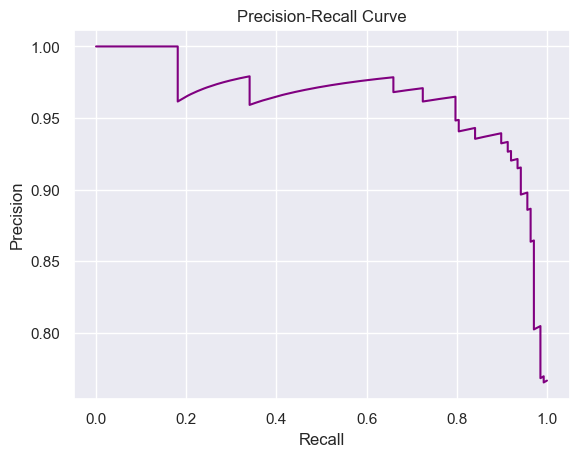

In [147]:
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [148]:
print(f"Area under precision Recall curve is {auc(recall, precision)}")

Area under precision Recall curve is 0.9627345361274895


## 13.7 ROC AUC Curve

In [149]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

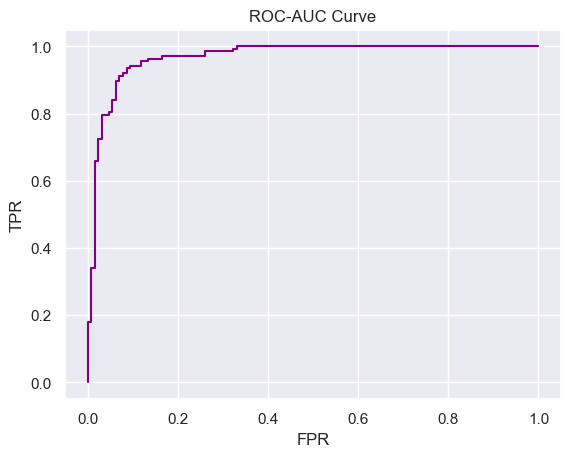

In [150]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='purple')
ax.set_title('ROC-AUC Curve')
ax.set_ylabel('TPR')
ax.set_xlabel('FPR')
plt.show()

In [151]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.967990414241698


## 13.8 Accuracy Threshold Curve

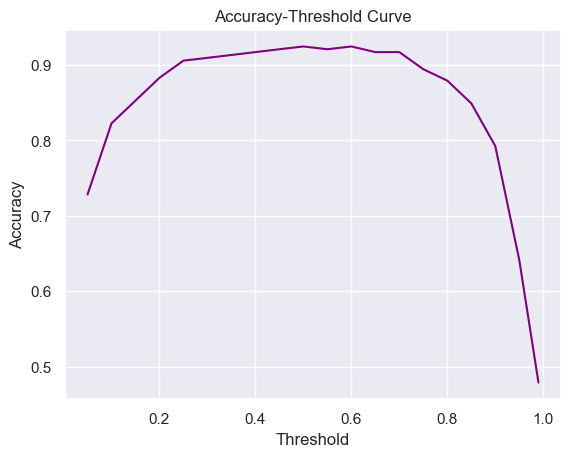

In [152]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [round((y_pred == y_test).sum()/y_pred.shape[0], 4)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('Accuracy-Threshold Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
plt.show()

In [153]:
np.max(scores), np.argmax(scores)

(0.9245, 9)

In [154]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.5


## 13.9 F1-Score Threshold Curve

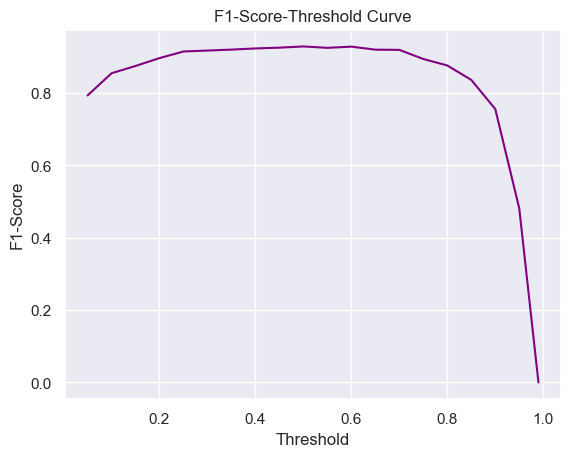

In [155]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [f1_score(y_test, y_pred)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('F1-Score-Threshold Curve')
ax.set_ylabel('F1-Score')
ax.set_xlabel('Threshold')
plt.show()

In [156]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.967990414241698


In [157]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.5


## 13.10 Feature Importance

In [158]:
pd.concat([pd.Series(gbdt_clf.feature_importances_), pd.Series(list(X_train.columns))], axis =1).sort_values(by=0, ascending=False)

0                      1
16  0.401609           joining_year
4   0.296091   Total Business Value
17  0.212985          joining_month
5   0.018603                 Income
18  0.014044            joining_day
22  0.012955     end_monthly_income
3   0.007094                  Grade
23  0.006318           start_rating
0   0.005654                    Age
21  0.004970              end_grade
8   0.004841                  grade
7   0.003426                 Cities
15  0.002658    reporting_end_month
2   0.002381        Education_Level
1   0.001651                 Gender
13  0.001555  reporting_start_month
6   0.001162       Quarterly Rating
10  0.000925           grade_raised
20  0.000847             end_rating
12  0.000230   reporting_start_year
9   0.000000          income_raised
11  0.000000          rating_raised
14  0.000000     reporting_end_year
19  0.000000            designation

# 14 Business Insights
A. There are more Male drivers than Female drivers.  
B. 99.7% drivers didn't get income raise or grade raise.  
C. 88.54% of drivers saw their rating getting improved.  
D. 30.67% of drivers left OLA.  
E. Number of drivers joining OLA increased significantly since 2018.  
F. Male drivers have lost more rating compared to Female drives.  
G. Drivers who  
   1. worked for more years with OLA
   2. older in age
   3. have lower education
   4. have very high ratings
   5. generated high total revenue for OLA  
Saw their income and grade increased significantly compared to other drivers.  

H. Drivers with higher grade and higher ratings left OLA more in numbers compared to other drivers.  
I. Most of the drivers who left OLA had joined OLA in recent years compared other drivers who decided to stay and not leave OLA.  
J. Surprisingly, most of the drivers who left OLA have their last reporting month and year as December 2020.  
K. Test model accuracy achieved for 'Bagging' and 'Boosting' is 95% and 94% respectively.  
L. Area under ROC-AUC curve for 'Bagging' and 'Boosting' is 95% and 96% respectively.  
M. F1-Score is betwwen 95% for both 'Bagging' and 'Boosting' models and for both target labels.  
N. Precision and Recall Scores are between 94% to 96% for both 'Bagging' and 'Boosting' models and for both target labels.  
O. Churning of the drivers is most affected by reporting_end_month, reporting_end_year, joining_month and age in this exact order from highest importance to lowest.  

- There are 57% male employees and 43% female employees.
- The percentages of employees with different education levels are almost same for level 1 & 2.
- 97.3% of the employees who did not get a raise.
- Almost 43% of the employees joined at lowest designation (1). 34% joined at level 2, 20% at level 3 and below 2% joined at higher levels.
- Majority (35%) of the employees currently are at designation level 2, followed by designation level 1 (31%) and 3 (26%). Less than 5% of the employees are currently in higher designations.
- Only 54.6% of the employees received a promotion, while 45.4% did not. However, only 2.6% received a raise in income.
- Number of employees has been increase with increase in year as well as number of reportings.
- The majority of the employees seem to be associated with city C20.
- Scatter plot of Income shows that Income increases with increase in age but after 45-50, we see a subtle decline.
- Scatter plot of Total Business Value shows an increase with increase in Age yet we notice a decline after 45.
- Income decreses with increase in Destination as about 4% of the employees hold higher designations.
- The median of the Income for employees having higher Grades is greater.
- Distribution of Income for enployes at different Education level is about a change of 3-5% with level 0.
- Joining Designation Increases with increase in Grade.
- Top reporting days is 24 days.
- About 55% of the reportings of the employees has got Quarlerly Rating 1.
- Number of reportings increases with increase in Income as well as Total Business Value.
- Recall increased after treatment of data imbalance and is performing bettee in Gradient Boosting.
- Precision dropped after treatment of data imbalance and is performing better in Random Forest.
- F1_score incresed after the treatment of imabalanced data and in Gradient Boosting.

# 15 Recommendation

A. To predict chrning of the driver, the columns reporting_end_month, reporting_end_year, joining_month and age should be considered.  
B. More data points should be gathered to analyze why many drivers who reported last in December 2020 left OLA.  
C. We saw that the high performing drivers leave more often than the rest. OLA can start a program to reward high performers and recognize their work more often.  
D. OLA can conduct periodic surveys to obtain more data points so as to make prediction model better and more accurate.  
F. We could also see that the drivers who joined OLA recently, left in more numbers. So OLA can focus more on these new drivers to make them stop leaving.  